### **Dataset Load and Import Library**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d sushmit0109/subescobangla-speech-emotion-dataset

from zipfile import ZipFile
dataset = '/content/subescobangla-speech-emotion-dataset.zip'

with ZipFile(dataset,'r') as zip:
  zip.extractall()
  print('The dataset is extracted')

100% 1.55G/1.55G [00:19<00:00, 94.0MB/s]
100% 1.55G/1.55G [00:19<00:00, 84.1MB/s]
The dataset is extracted


In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import tensorflow_hub as hub
import librosa
import builtins
import librosa.display
import matplotlib.pyplot as plt
from scipy.io.wavfile import write
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential, Model,load_model
from tensorflow.keras.layers import Conv1D, Activation, MaxPooling1D, BatchNormalization, Dropout, Flatten, Dense
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from keras.utils import to_categorical
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

In [6]:
paths =[]
labels =[]
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Colab Notebooks/CSV/SUBESCO/SUBESCO_dataset'):
   for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-2]
        labels.append(label.lower())

print("Dataset is Loaded")

Dataset is Loaded


In [7]:
emotions=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

### **Preprocessing the data**

In [9]:
def envelope(y, rate, threshold):
    mask = []
    y = pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/10), min_periods=1, center=True).mean()
    for mean in y_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask

# Directory containing your SUBESCO audio files
subesco_data_dir = '/content/drive/MyDrive/Colab Notebooks/CSV/SUBESCO/SUBESCO_dataset'

# Directory to save cleaned audio files
cleaned_data_dir = '/content/drive/MyDrive/Colab Notebooks/CSV/SUBESCO/cleaned_data'

# Create the cleaned data directory if it doesn't exist
os.makedirs(cleaned_data_dir, exist_ok=True)

# Parameters for envelope filtering
threshold_value = 0.005

# Loop through each audio file in the SUBESCO dataset
for filename in os.listdir(subesco_data_dir):
    if filename.endswith(".wav"):
        # Load the audio file
        filepath = os.path.join(subesco_data_dir, filename)
        y, sr = librosa.load(filepath, sr=None)

        # Apply envelope filtering
        mask = envelope(y, sr, threshold_value)
        cleaned_audio = y[mask]

        # Save the cleaned audio file
        cleaned_filepath = os.path.join(cleaned_data_dir, f"cleaned_{filename}")
        write(cleaned_filepath, sr, cleaned_audio)


In [11]:
import os
import numpy as np
import librosa
import soundfile as sf

def add_gaussian_noise(audio, noise_amplitude):
    # Generate Gaussian noise
    noise = np.random.normal(0, 1, len(audio))

    # Scale the noise by the given amplitude
    noise *= noise_amplitude

    # Add the noise to the audio
    audio_noisy = audio + noise

    return audio_noisy

def preprocess_dataset(input_dir, output_dir, noise_amplitude):
    # Create output directory if it does not exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Iterate through all audio files in the input directory
    for filename in os.listdir(input_dir):
        if filename.endswith('.wav'):
            input_path = os.path.join(input_dir, filename)
            output_path = os.path.join(output_dir, filename)

            # Load the original audio
            audio, sr = librosa.load(input_path, sr=None)

            # Add Gaussian noise to the audio
            audio_noisy = add_gaussian_noise(audio, noise_amplitude)

            # Save the noisy audio using soundfile
            sf.write(output_path, audio_noisy, sr)

input_dir = '/content/drive/MyDrive/Colab Notebooks/CSV/SUBESCO/SUBESCO_dataset'
output_dir = '/content/drive/MyDrive/Colab Notebooks/CSV/SUBESCO/New_SUBESCO'
noise_amplitude = 0.1

preprocess_dataset(input_dir, output_dir, noise_amplitude)


### **Data Visualization**

#### **Before Preprocessing**

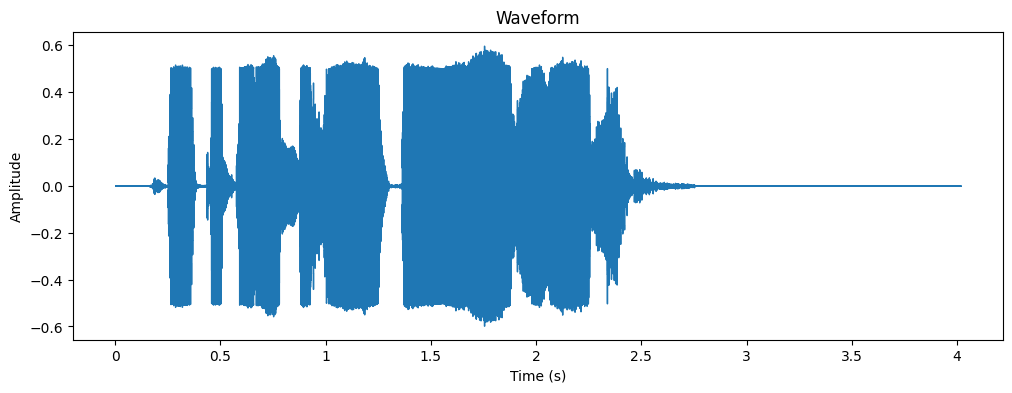

In [14]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Load audio file
audio_path = '/content/drive/MyDrive/Colab Notebooks/CSV/SUBESCO/SUBESCO_dataset/F_01_OISHI_S_10_DISGUST_1.wav'
y, sr = librosa.load(audio_path)

# Plot the waveform
plt.figure(figsize=(12, 4))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

#### **After Preprocessing**

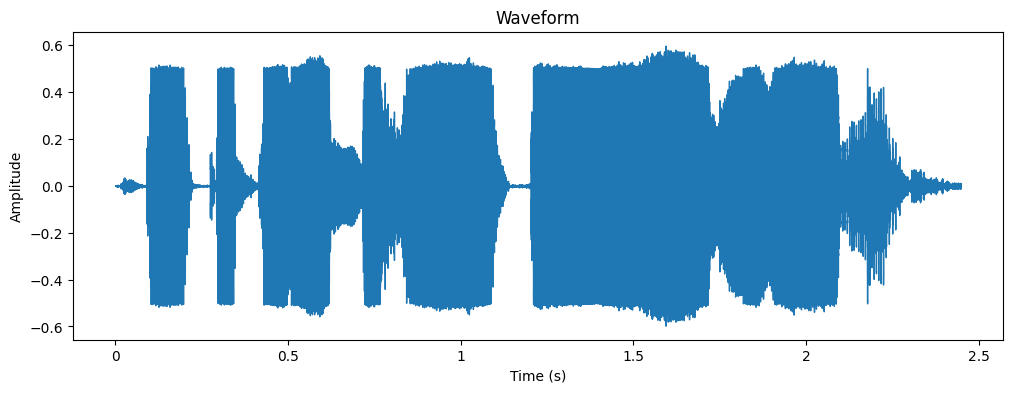

In [15]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Load audio file
audio_path = '/content/drive/MyDrive/Colab Notebooks/CSV/SUBESCO/cleaned_data/cleaned_F_01_OISHI_S_10_DISGUST_1.wav'
y, sr = librosa.load(audio_path)

# Plot the waveform
plt.figure(figsize=(12, 4))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

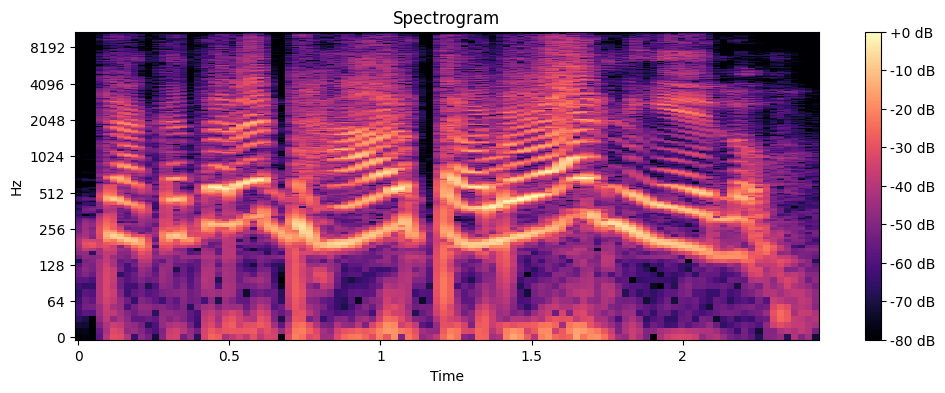

In [16]:
# Plot the spectrogram
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
plt.figure(figsize=(12, 4))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.show()

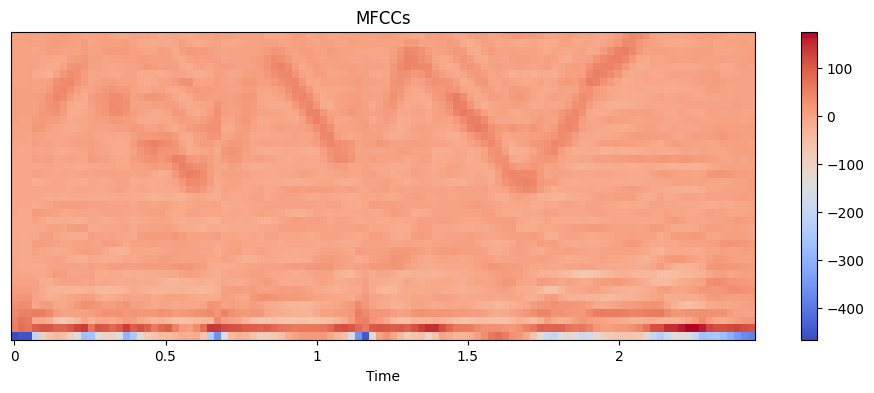

In [17]:
# Compute MFCCs
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)

# Display the MFCCs as a bar plot
plt.figure(figsize=(12, 4))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCCs')
plt.show()

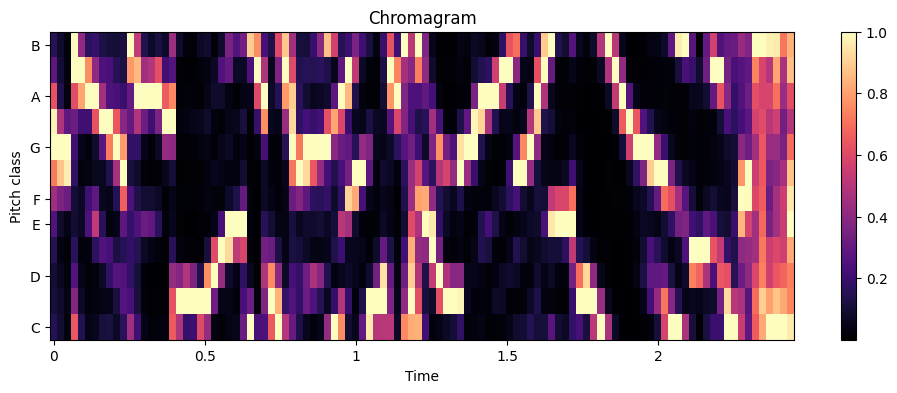

In [18]:
# Compute chromagram
chromagram = librosa.feature.chroma_stft(y=y, sr=sr)

# Display the chromagram
plt.figure(figsize=(12, 4))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma')
plt.colorbar()
plt.title('Chromagram')
plt.show()

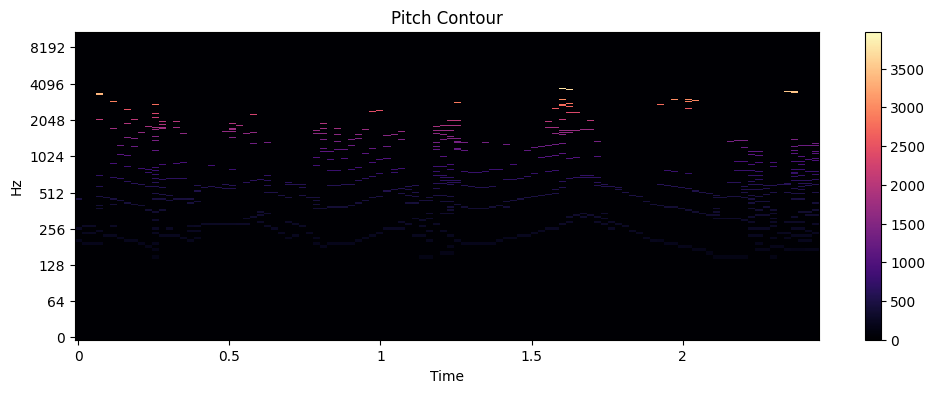

In [19]:
# Compute pitch
pitches, magnitudes = librosa.core.piptrack(y=y, sr=sr)

# Display pitch contour
plt.figure(figsize=(12, 4))
librosa.display.specshow(pitches, y_axis='log', x_axis='time')
plt.colorbar()
plt.title('Pitch Contour')
plt.show()

In [20]:
df = pd.DataFrame()
df['speech']=paths
df['label']=labels
df.head()

speech    label
0  /content/drive/MyDrive/Colab Notebooks/CSV/SUB...     fear
1  /content/drive/MyDrive/Colab Notebooks/CSV/SUB...  disgust
2  /content/drive/MyDrive/Colab Notebooks/CSV/SUB...     fear
3  /content/drive/MyDrive/Colab Notebooks/CSV/SUB...    happy
4  /content/drive/MyDrive/Colab Notebooks/CSV/SUB...  neutral

In [21]:
df['label'].value_counts()

label
neutral     14
surprise    14
disgust     13
happy       12
fear        12
angry       12
sad         10
Name: count, dtype: int64

<Axes: xlabel='label', ylabel='count'>

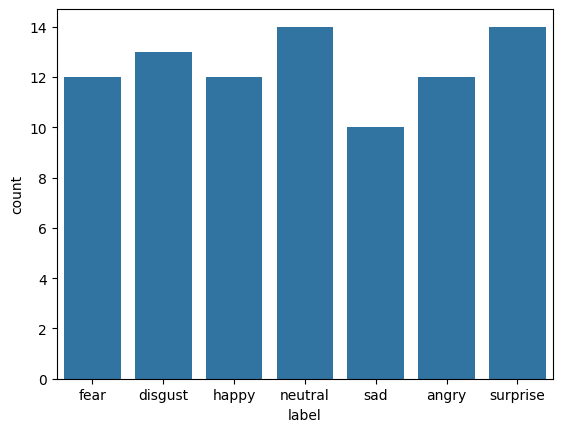

In [22]:
sns.countplot(x= df['label'])

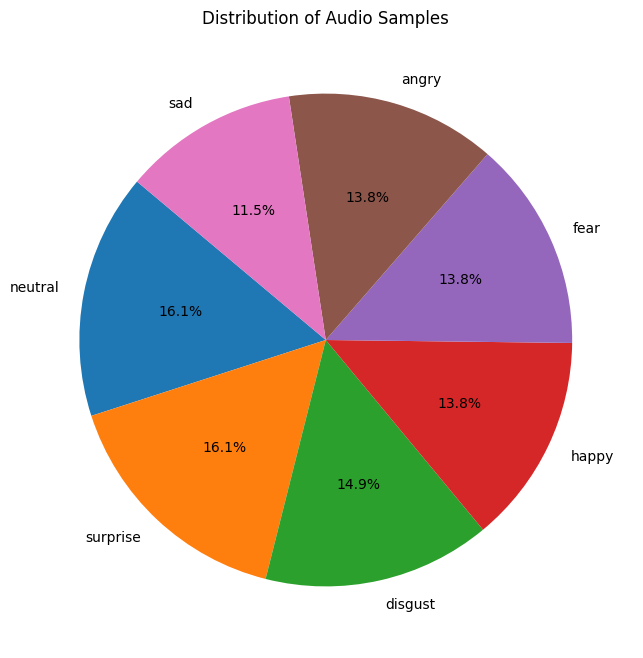

In [23]:
# Count the occurrences of each class
class_counts = df['label'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Audio Samples')
plt.show()

### **Performance Measure Declaration**

In [25]:
def curve():
   plt.figure(figsize=(10, 4))
   plt.subplot(1, 2, 1)
   plt.plot(history.history['loss'], label='Training Loss')
   plt.plot(history.history['val_loss'], label='Validation Loss')
   plt.legend(loc='upper right')
   plt.title('Training & Validation Loss')


   plt.subplot(1, 2, 2)
   plt.plot(history.history['accuracy'], label='Training Accuracy')
   plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
   plt.legend(loc='lower right')
   plt.title('Training & Validation Accuracy')

   plt.show()

def accuracy_curve():
  h = history
  plt.plot(h.history['accuracy'],label='train accuracy')
  plt.plot(h.history['val_accuracy'],label = 'validation accuracy')
  plt.legend()
  plt.show()

def loss_curve():
    h = history
    plt.plot(h.history['loss'],label = 'train loss')
    plt.plot(h.history['val_loss'],label = 'validation loss')
    plt.legend()
    plt.show()

def performance_measure():
  y_pred = model.predict(X_test)
  y_pred_labels = np.argmax(y_pred, axis=1)
  accuracy = accuracy_score(y_test, y_pred_labels)
  print("Accuracy:", accuracy)
  precision = precision_score(y_test, y_pred_labels, average='macro')
  recall = recall_score(y_test, y_pred_labels, average='macro')
  f1 = f1_score(y_test, y_pred_labels, average='macro')

  print("Precision:", precision)
  print("Recall:", recall)
  print("F1 Score:", f1)

def confusion_matrices():
  y_pred = model.predict(X_test)
  y_pred_labels = np.argmax(y_pred, axis=1)
  cm = confusion_matrix(y_test, y_pred_labels)
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, cmap = 'Greens', fmt='d', square=True, xticklabels=np.unique(emotions), yticklabels=np.unique(emotions))
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('Confusion Matrix')
  plt.show()

def classification_report_custom():
  y_pred = model.predict(X_test)
  y_pred_labels = np.argmax(y_pred, axis=1)
  report = classification_report(y_test, y_pred_labels,target_names = np.unique(emotions))
  print(report)

def Roc_curve():
  y_pred = model.predict(X_test)
  predictions = np.array(list(map(lambda x: np.round(x), y_pred)))

  y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
  predictions_bin = label_binarize(predictions, classes=np.unique(y_test))

  fpr = dict()
  tpr = dict()
  roc_auc = dict()

  n_classes = len(np.unique(y_test))
  for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], predictions_bin[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  plt.figure(figsize=(6, 5))

  for i in range(n_classes):
      plt.plot(fpr[i], tpr[i], label=f' {emotions[i]} (AUC = {roc_auc[i]:.2f})')

  plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic for each class')
  plt.legend(loc="lower right")
  plt.show()


def results():
  performance_measure()
  print('\n')
  curve()
  print('\n')
  confusion_matrices()
  print('\n')
  classification_report_custom()
  print('\n')
  Roc_curve()

### **Feature Extraction**

In [26]:
def extract_mfcc_features_from_file(file_name):
    # Load the audio file
    y, sr = librosa.load(file_name)

    # Extract MFCC features
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40), axis=1)

    return list(mfccs)

def extract_emotion_from_filename(filename):
    return filename.split('_')[-2]

In [28]:
DATASET_PATH = "/content/drive/MyDrive/Colab Notebooks/CSV/SUBESCO/cleaned_data"
X = []
y = []

for file in os.listdir(DATASET_PATH):
    if file.endswith(".wav"):
        features = extract_mfcc_features_from_file(os.path.join(DATASET_PATH, file))
        X.append(features)
        y.append(extract_emotion_from_filename(file))

X = np.array(X)
y = LabelEncoder().fit_transform(y)

In [30]:
import pandas as pd
import numpy as np

X_flat = X.reshape(X.shape[0], -1)

X_columns = [f"feature{i}" for i in range(1, X_flat.shape[1] + 1)]

X_df = pd.DataFrame(X_flat, columns=X_columns)
y_df = pd.DataFrame(y, columns=['label'])
data_df = pd.concat([X_df, y_df], axis=1)
csv_file_path = "/content/drive/MyDrive/Colab Notebooks/CSV/SUBESCO/features.csv"
data_df.to_csv(csv_file_path, index=False)
print("Data saved to:", csv_file_path)

Data saved to: /content/drive/MyDrive/Colab Notebooks/CSV/SUBESCO/features.csv


In [31]:
data_df

feature1   feature2   feature3   feature4  feature5   feature6  \
0  -224.211960  74.280640   6.932554  30.338224  4.828484 -20.459751   
1  -157.279373  91.216423   8.594330  21.938509  3.871883  -8.002938   
2  -157.444885  85.202515   3.494297  19.056702  3.788379  -3.729652   
3   -85.029709  69.093010 -16.812593  21.511229 -3.198798  -9.714724   
4  -161.015320  85.446785   4.207870  20.379007  3.556068  -7.953493   
..         ...        ...        ...        ...       ...        ...   
82 -162.676788  58.611832  -1.306150  27.072714  2.024909 -21.515968   
83 -170.814194  62.879349   6.774601  29.102077  5.242144 -17.021868   
84 -166.087769  66.617020 -28.872623  26.973276  3.174094 -24.185678   
85 -160.867477  55.010738 -12.504419  38.005444 -2.961844 -25.466898   
86 -157.340546  57.009399 -28.145535  27.990309 -1.343472 -23.944479   

     feature7  feature8   feature9  feature10  ...  feature32  feature33  \
0   -2.685703 -7.533785 -22.206644  -4.288244  ...  10.513907   1.989347   
1   -3.968093 -1.297584 -12.984770  -2.107200  ...   7.362521   0.537089   
2   -2.550086  3.195653 -10.882692  -0.091054  ...   9.808488   4.153485   
3  -18.593214 -8.668456 -16.046114  -7.617802  ...   3.261168  -4.461396   
4   -3.853722  2.098456  -9.109332  -1.005267  ...   7.965281   3.401708   
..        ...       ...        ...        ...  ...        ...        ...   
82 -18.395391  1.163763 -28.152653  -8.224265  ...   1.558680   1.146335   
83  -7.514952  1.230244 -25.843166  -1.505578  ...   5.256716  -3.057211   
84 -23.777296  0.761397 -28.051256  -8.762909  ...  -1.120553  -6.517430   
85 -11.172187  2.706502 -28.084211  -8.361679  ...   6.973977  -4.258524   
86 -21.930851  1.169912 -25.735935  -4.744120  ...   3.427340  -3.435232   

    feature34  feature35  feature36  feature37  feature38  feature39  \
0    4.365052  -1.047392   1.025357   1.726486   3.113096   0.668155   
1    2.775482  -2.578988   2.741813   0.003728   1.230721  -1.899472   
2    6.290352   1.638586   5.315249   5.753472   6.008615   2.067384   
3    1.917194  -3.282397   1.956454  -1.471203   1.781841   0.712783   
4    6.098769   1.912922   5.092400   4.856297   6.278295   4.776607   
..        ...        ...        ...        ...        ...        ...   
82   2.239755  -0.000894  -1.155131  -0.977629   2.449985  -0.510780   
83  -2.989144  -3.896589   1.825368  -0.377872  -0.555441  -0.821850   
84  -0.178857  -3.360276  -1.260061  -3.238678  -4.501682  -3.009921   
85  -3.406532  -6.307826   0.239544  -0.155618  -1.182524  -3.234529   
86  -2.752489  -3.202596   2.955689  -0.413428  -3.280205  -5.415727   

    feature40  label  
0   -0.075039      4  
1   -0.211146      4  
2   -0.045075      5  
3    4.621245      3  
4    3.455253      5  
..        ...    ...  
82   1.514284      1  
83   2.656978      6  
84  -1.226310      5  
85   3.862919      3  
86  -0.883628      5  

[87 rows x 41 columns]

### **Reading CSV**

In [32]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CSV/SUBESCO/features.csv')

In [33]:
df

feature1   feature2   feature3   feature4  feature5   feature6  \
0  -224.21196  74.280640   6.932554  30.338224  4.828484 -20.459751   
1  -157.27937  91.216420   8.594330  21.938509  3.871883  -8.002938   
2  -157.44489  85.202515   3.494297  19.056702  3.788379  -3.729652   
3   -85.02971  69.093010 -16.812593  21.511229 -3.198798  -9.714724   
4  -161.01532  85.446785   4.207870  20.379007  3.556068  -7.953493   
..        ...        ...        ...        ...       ...        ...   
82 -162.67679  58.611830  -1.306150  27.072714  2.024909 -21.515968   
83 -170.81420  62.879350   6.774601  29.102077  5.242144 -17.021868   
84 -166.08777  66.617020 -28.872623  26.973276  3.174094 -24.185678   
85 -160.86748  55.010740 -12.504419  38.005444 -2.961844 -25.466898   
86 -157.34055  57.009400 -28.145535  27.990309 -1.343472 -23.944479   

     feature7  feature8   feature9  feature10  ...  feature32  feature33  \
0   -2.685703 -7.533785 -22.206644  -4.288244  ...  10.513907   1.989347   
1   -3.968093 -1.297584 -12.984770  -2.107200  ...   7.362521   0.537089   
2   -2.550086  3.195653 -10.882692  -0.091054  ...   9.808488   4.153485   
3  -18.593214 -8.668456 -16.046114  -7.617802  ...   3.261168  -4.461396   
4   -3.853722  2.098456  -9.109332  -1.005267  ...   7.965281   3.401708   
..        ...       ...        ...        ...  ...        ...        ...   
82 -18.395391  1.163763 -28.152653  -8.224265  ...   1.558680   1.146335   
83  -7.514952  1.230244 -25.843166  -1.505578  ...   5.256716  -3.057211   
84 -23.777296  0.761397 -28.051256  -8.762909  ...  -1.120553  -6.517430   
85 -11.172187  2.706502 -28.084211  -8.361679  ...   6.973977  -4.258524   
86 -21.930851  1.169912 -25.735935  -4.744120  ...   3.427340  -3.435232   

    feature34  feature35  feature36  feature37  feature38  feature39  \
0    4.365052  -1.047392   1.025357   1.726486   3.113096   0.668155   
1    2.775482  -2.578988   2.741813   0.003728   1.230722  -1.899472   
2    6.290352   1.638586   5.315249   5.753472   6.008615   2.067384   
3    1.917194  -3.282397   1.956454  -1.471203   1.781841   0.712783   
4    6.098769   1.912922   5.092400   4.856297   6.278295   4.776607   
..        ...        ...        ...        ...        ...        ...   
82   2.239755  -0.000894  -1.155131  -0.977629   2.449985  -0.510780   
83  -2.989144  -3.896589   1.825368  -0.377872  -0.555441  -0.821850   
84  -0.178857  -3.360276  -1.260061  -3.238678  -4.501682  -3.009921   
85  -3.406532  -6.307826   0.239544  -0.155618  -1.182524  -3.234529   
86  -2.752489  -3.202596   2.955689  -0.413428  -3.280206  -5.415727   

    feature40  label  
0   -0.075039      4  
1   -0.211146      4  
2   -0.045075      5  
3    4.621245      3  
4    3.455253      5  
..        ...    ...  
82   1.514284      1  
83   2.656978      6  
84  -1.226310      5  
85   3.862919      3  
86  -0.883628      5  

[87 rows x 41 columns]

In [34]:
X = df.drop(columns = 'label')
y = df['label']

In [35]:
from sklearn.utils import shuffle
X,y = shuffle(X,y,random_state = 101)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train.shape

(5600, 40)

##**CNN**

In [37]:
model = Sequential()

model.add(Conv1D(512, 5, padding='same', input_shape=(X_train.shape[1],1)))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Conv1D(256, 5, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv1D(128, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(7, activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 40, 512)        │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 40, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 20, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 20, 512)        │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 20, 256)        │       655,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 20, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 10, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 128)        │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 5, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 640)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 966,407 (3.69 MB)

 Trainable params: 964,615 (3.68 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [38]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test),batch_size=64)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 6s/step - accuracy: 0.1234 - loss: 2.6333 - val_accuracy: 0.0556 - val_loss: 2.1111
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.1732 - loss: 2.0405 - val_accuracy: 0.1667 - val_loss: 2.1665
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.1680 - loss: 2.1270 - val_accuracy: 0.0556 - val_loss: 2.4515
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.1978 - loss: 2.0679 - val_accuracy: 0.0556 - val_loss: 3.1843
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.2625 - loss: 1.9796 - val_accuracy: 0.0556 - val_loss: 3.6949
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.2625 - loss: 2.0015 - val_accuracy: 0.0556 - val_loss: 4.1505
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.3219 - loss: 1.7695 - val_accuracy: 0.0556 - val_loss: 4.3856
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.2721 - loss: 1.8254 - val_accuracy: 0.0556 - val_loss: 

44/44 [==============================] - 0s 2ms/step
Accuracy: 0.9292857142857143
Precision: 0.9291676710061312
Recall: 0.9286085477454813
F1 Score: 0.9285381729636777




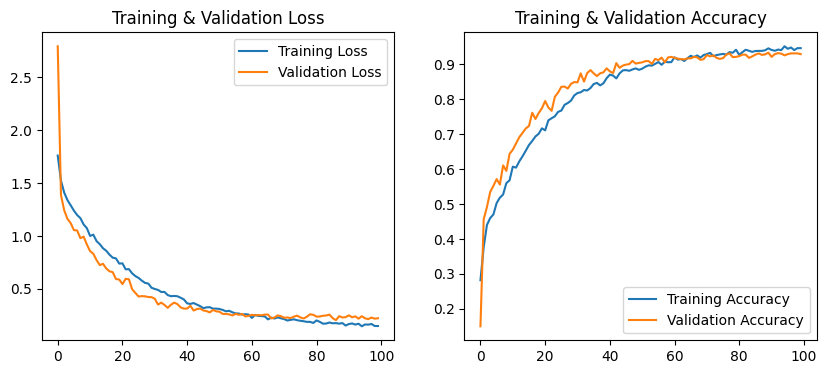



44/44 [==============================] - 0s 4ms/step


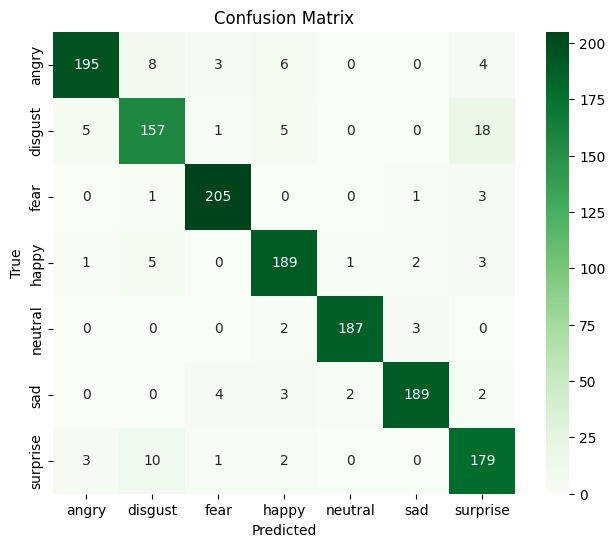



44/44 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

       angry       0.96      0.90      0.93       216
     disgust       0.87      0.84      0.86       186
        fear       0.96      0.98      0.97       210
       happy       0.91      0.94      0.93       201
     neutral       0.98      0.97      0.98       192
         sad       0.97      0.94      0.96       200
    surprise       0.86      0.92      0.89       195

    accuracy                           0.93      1400
   macro avg       0.93      0.93      0.93      1400
weighted avg       0.93      0.93      0.93      1400



44/44 [==============================] - 0s 4ms/step


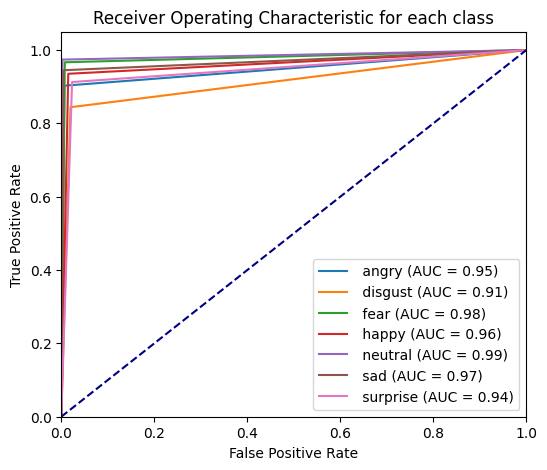

In [ ]:
results()

In [39]:
model = Sequential()

model.add(Conv1D(512, 5, padding='same', input_shape=(X_train.shape[1],1)))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Conv1D(256, 5, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv1D(128, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(7, activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 40, 512)        │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 40, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 20, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 20, 512)        │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 20, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 20, 256)        │       655,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 20, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 10, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 10, 128)        │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 5, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 640)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 966,407 (3.69 MB)

 Trainable params: 964,615 (3.68 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [40]:
history = model.fit(X_train, y_train, epochs=150, validation_data=(X_test, y_test),batch_size=64)

Epoch 1/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 6s/step - accuracy: 0.0840 - loss: 2.5656 - val_accuracy: 0.0556 - val_loss: 3.3165
Epoch 2/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.1829 - loss: 2.1409 - val_accuracy: 0.0556 - val_loss: 3.9466
Epoch 3/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.1978 - loss: 1.9460 - val_accuracy: 0.0556 - val_loss: 4.9861
Epoch 4/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.2178 - loss: 2.0100 - val_accuracy: 0.0556 - val_loss: 6.0553
Epoch 5/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.2231 - loss: 1.8537 - val_accuracy: 0.0556 - val_loss: 7.0460
Epoch 6/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.3613 - loss: 1.8837 - val_accuracy: 0.0556 - val_loss: 7.3837
Epoch 7/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.2074 - loss: 1.9810 - val_accuracy: 0.0556 - val_loss: 7.5947
Epoch 8/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.3019 - loss: 1.7896 - val_accuracy: 0.0556 - val_loss:

44/44 [==============================] - 1s 7ms/step
Accuracy: 0.935
Precision: 0.9346025492718321
Recall: 0.9343691526409131
F1 Score: 0.9342317669184202




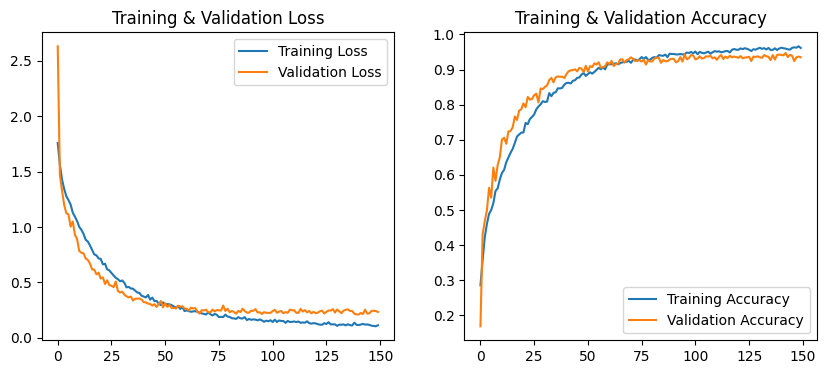



44/44 [==============================] - 0s 5ms/step


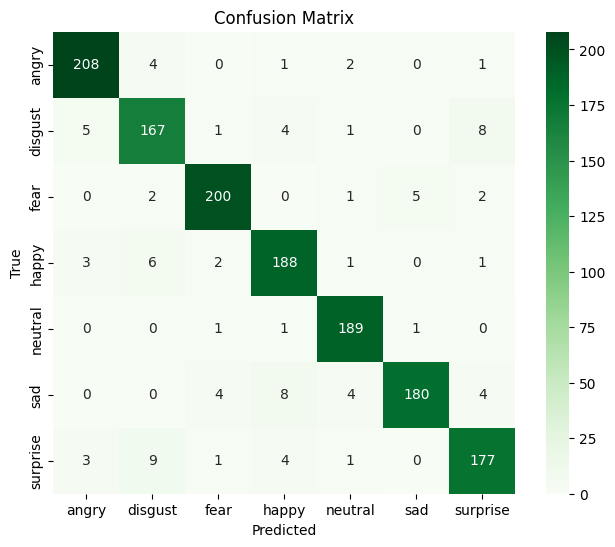



44/44 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

       angry       0.95      0.96      0.96       216
     disgust       0.89      0.90      0.89       186
        fear       0.96      0.95      0.95       210
       happy       0.91      0.94      0.92       201
     neutral       0.95      0.98      0.97       192
         sad       0.97      0.90      0.93       200
    surprise       0.92      0.91      0.91       195

    accuracy                           0.94      1400
   macro avg       0.93      0.93      0.93      1400
weighted avg       0.94      0.94      0.93      1400



44/44 [==============================] - 0s 6ms/step


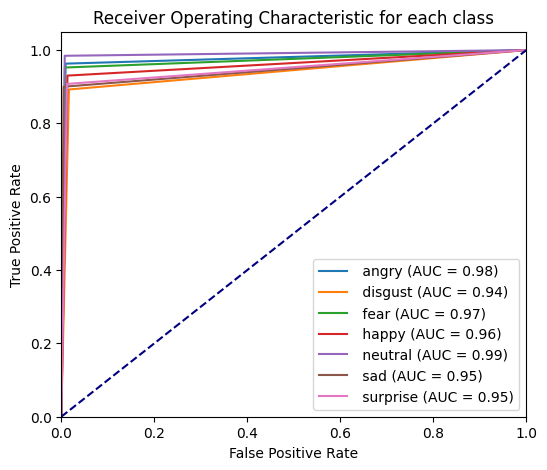

In [ ]:
results()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train= scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
model = Sequential()

model.add(Conv1D(512, 5, padding='same', input_shape=(X_train.shape[1],1)))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Conv1D(256, 5, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv1D(128, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(7, activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 40, 512)           3072      
                                                                 
 activation_9 (Activation)   (None, 40, 512)           0         
                                                                 
 max_pooling1d_9 (MaxPoolin  (None, 20, 512)           0         
 g1D)                                                            
                                                                 
 batch_normalization_9 (Bat  (None, 20, 512)           2048      
 chNormalization)                                                
                                                                 
 dropout_18 (Dropout)        (None, 20, 512)           0         
                                                                 
 conv1d_10 (Conv1D)          (None, 20, 256)          

In [ ]:
history = model.fit(X_train, y_train, epochs=150, validation_data=(X_test, y_test),batch_size=64)

Epoch 1/150
88/88 [==============================] - 8s 22ms/step - loss: 1.6640 - accuracy: 0.3368 - val_loss: 2.0307 - val_accuracy: 0.1557
Epoch 2/150
88/88 [==============================] - 2s 17ms/step - loss: 1.3978 - accuracy: 0.4448 - val_loss: 2.1960 - val_accuracy: 0.1514
Epoch 3/150
88/88 [==============================] - 1s 17ms/step - loss: 1.2673 - accuracy: 0.4964 - val_loss: 2.0664 - val_accuracy: 0.2236
Epoch 4/150
88/88 [==============================] - 1s 15ms/step - loss: 1.1108 - accuracy: 0.5614 - val_loss: 2.0078 - val_accuracy: 0.2636
Epoch 5/150
88/88 [==============================] - 1s 10ms/step - loss: 1.0385 - accuracy: 0.5957 - val_loss: 1.1893 - val_accuracy: 0.5564
Epoch 6/150
88/88 [==============================] - 1s 9ms/step - loss: 0.9504 - accuracy: 0.6271 - val_loss: 0.9246 - val_accuracy: 0.6457
Epoch 7/150
88/88 [==============================] - 1s 9ms/step - loss: 0.8826 - accuracy: 0.6637 - val_loss: 0.7802 - val_accuracy: 0.6929
Epoch 8/

44/44 [==============================] - 0s 5ms/step
Accuracy: 0.9285714285714286
Precision: 0.9282377955938791
Recall: 0.9283486521859174
F1 Score: 0.9277620013133667




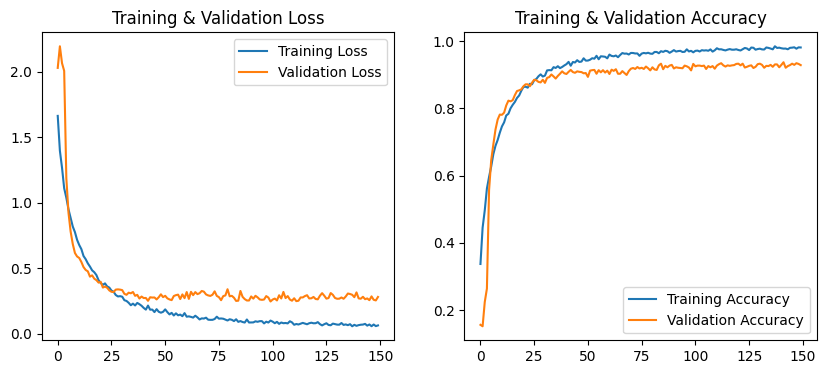



44/44 [==============================] - 0s 4ms/step


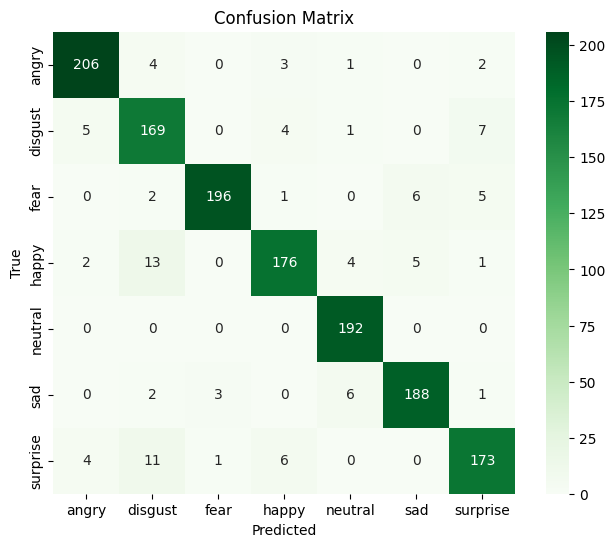



44/44 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

       angry       0.95      0.95      0.95       216
     disgust       0.84      0.91      0.87       186
        fear       0.98      0.93      0.96       210
       happy       0.93      0.88      0.90       201
     neutral       0.94      1.00      0.97       192
         sad       0.94      0.94      0.94       200
    surprise       0.92      0.89      0.90       195

    accuracy                           0.93      1400
   macro avg       0.93      0.93      0.93      1400
weighted avg       0.93      0.93      0.93      1400



44/44 [==============================] - 0s 4ms/step


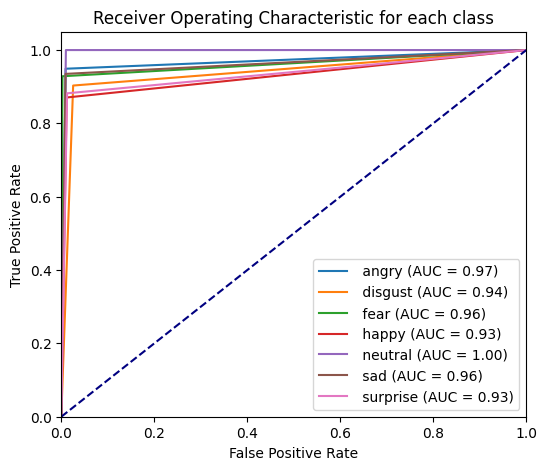

In [ ]:
results()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = Sequential()

model.add(Conv1D(512, 5, padding='same', input_shape=(X_train.shape[1],1)))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Conv1D(256, 5, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv1D(128, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(7, activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test),batch_size=64)

Epoch 1/200
88/88 [==============================] - 10s 19ms/step - loss: 1.7599 - accuracy: 0.2771 - val_loss: 2.5352 - val_accuracy: 0.1729
Epoch 2/200
88/88 [==============================] - 1s 14ms/step - loss: 1.5315 - accuracy: 0.3734 - val_loss: 1.7483 - val_accuracy: 0.3379
Epoch 3/200
88/88 [==============================] - 1s 15ms/step - loss: 1.4275 - accuracy: 0.4238 - val_loss: 1.3624 - val_accuracy: 0.4650
Epoch 4/200
88/88 [==============================] - 1s 15ms/step - loss: 1.3428 - accuracy: 0.4625 - val_loss: 1.2136 - val_accuracy: 0.5129
Epoch 5/200
88/88 [==============================] - 1s 14ms/step - loss: 1.2883 - accuracy: 0.4809 - val_loss: 1.0823 - val_accuracy: 0.5657
Epoch 6/200
88/88 [==============================] - 1s 13ms/step - loss: 1.2218 - accuracy: 0.5130 - val_loss: 1.0918 - val_accuracy: 0.5593
Epoch 7/200
88/88 [==============================] - 1s 15ms/step - loss: 1.1920 - accuracy: 0.5193 - val_loss: 1.0212 - val_accuracy: 0.5879
Epoch

44/44 [==============================] - 0s 3ms/step
Accuracy: 0.9335714285714286
Precision: 0.9334159079246781
Recall: 0.9328206585452185
F1 Score: 0.9327549657630732




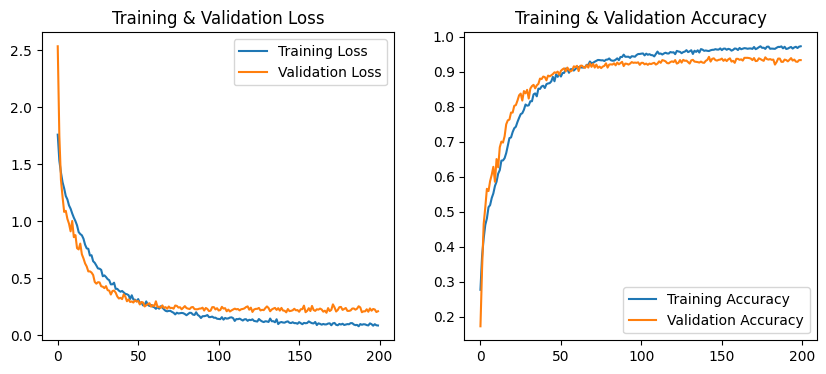



44/44 [==============================] - 0s 3ms/step


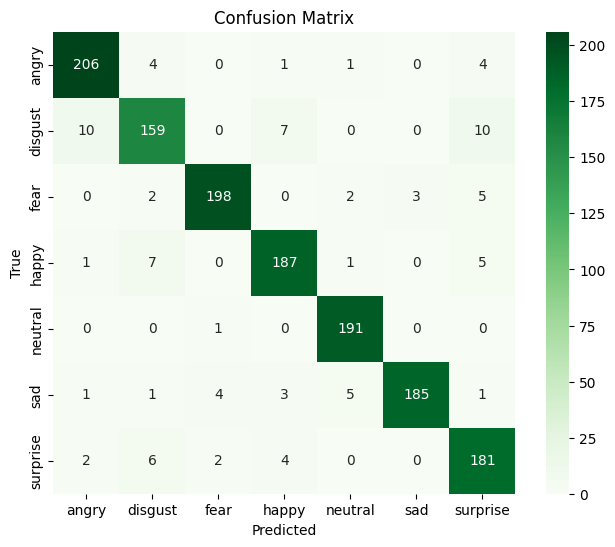



44/44 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

       angry       0.94      0.95      0.94       216
     disgust       0.89      0.85      0.87       186
        fear       0.97      0.94      0.95       210
       happy       0.93      0.93      0.93       201
     neutral       0.95      0.99      0.97       192
         sad       0.98      0.93      0.95       200
    surprise       0.88      0.93      0.90       195

    accuracy                           0.93      1400
   macro avg       0.93      0.93      0.93      1400
weighted avg       0.93      0.93      0.93      1400



44/44 [==============================] - 0s 4ms/step


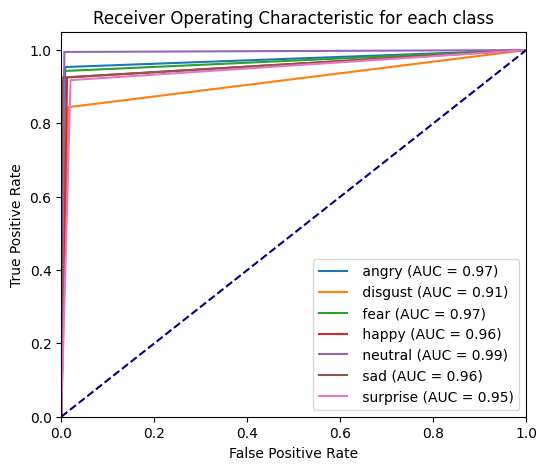

In [ ]:
results()

In [ ]:
model = Sequential()

model.add(Conv1D(512, 5, padding='same', input_shape=(X_train.shape[1],1)))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Conv1D(256, 5, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv1D(128, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(7, activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=500, validation_data=(X_test, y_test),batch_size=64)

Epoch 1/500
88/88 [==============================] - 4s 13ms/step - loss: 2.0019 - accuracy: 0.1979 - val_loss: 1.7606 - val_accuracy: 0.3271
Epoch 2/500
88/88 [==============================] - 1s 10ms/step - loss: 1.8078 - accuracy: 0.2546 - val_loss: 1.6524 - val_accuracy: 0.3671
Epoch 3/500
88/88 [==============================] - 1s 12ms/step - loss: 1.7304 - accuracy: 0.2843 - val_loss: 1.6308 - val_accuracy: 0.3243
Epoch 4/500
88/88 [==============================] - 1s 12ms/step - loss: 1.6768 - accuracy: 0.3032 - val_loss: 1.6368 - val_accuracy: 0.3321
Epoch 5/500
88/88 [==============================] - 1s 14ms/step - loss: 1.6554 - accuracy: 0.3095 - val_loss: 1.5821 - val_accuracy: 0.3486
Epoch 6/500
88/88 [==============================] - 1s 15ms/step - loss: 1.6036 - accuracy: 0.3313 - val_loss: 1.5721 - val_accuracy: 0.3407
Epoch 7/500
88/88 [==============================] - 1s 16ms/step - loss: 1.5536 - accuracy: 0.3586 - val_loss: 1.5237 - val_accuracy: 0.3614
Epoch 

44/44 [==============================] - 0s 2ms/step
Accuracy: 0.9492857142857143
Precision: 0.9493220911958288
Recall: 0.9486173036850095
F1 Score: 0.9488109003142793




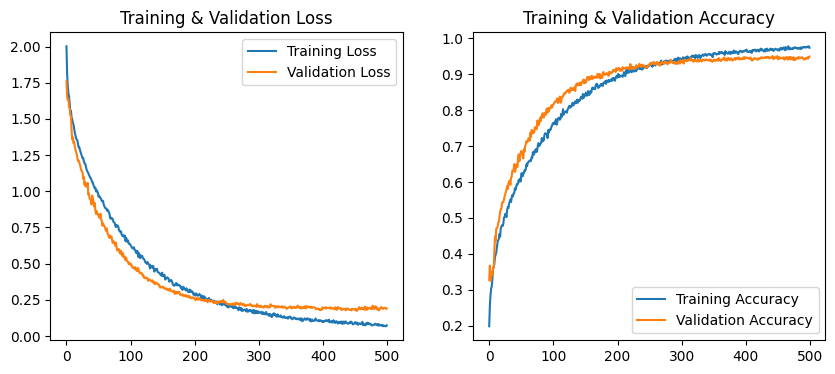



44/44 [==============================] - 0s 3ms/step


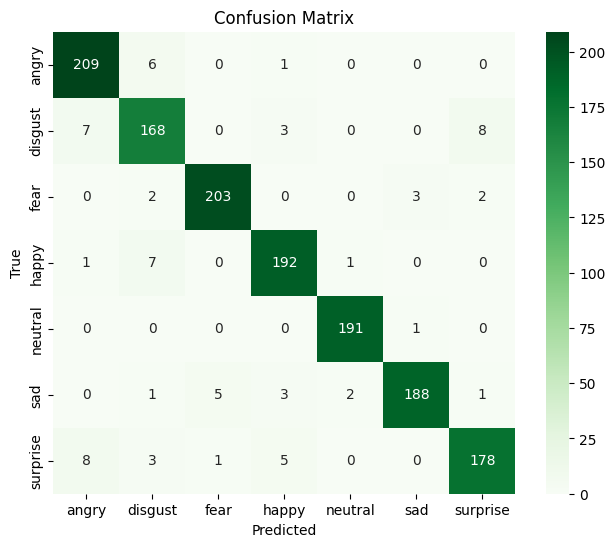



44/44 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

       angry       0.93      0.97      0.95       216
     disgust       0.90      0.90      0.90       186
        fear       0.97      0.97      0.97       210
       happy       0.94      0.96      0.95       201
     neutral       0.98      0.99      0.99       192
         sad       0.98      0.94      0.96       200
    surprise       0.94      0.91      0.93       195

    accuracy                           0.95      1400
   macro avg       0.95      0.95      0.95      1400
weighted avg       0.95      0.95      0.95      1400



44/44 [==============================] - 0s 4ms/step


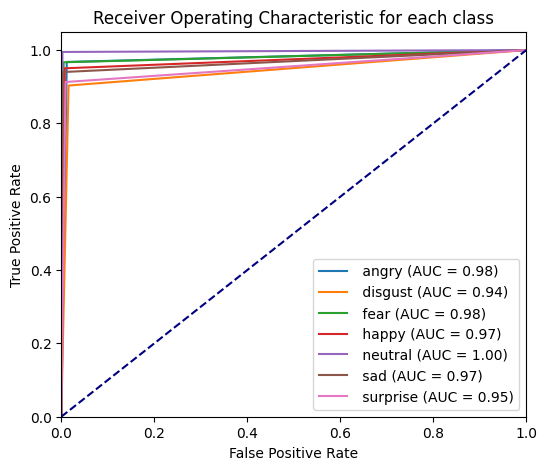

In [ ]:
results()

### **60-40**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [ ]:
model = Sequential()

model.add(Conv1D(512, 5, padding='same', input_shape=(X_train.shape[1],1)))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Conv1D(256, 5, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv1D(128, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(7, activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=150, validation_data=(X_test, y_test),batch_size=64)

Epoch 1/150
66/66 [==============================] - 10s 25ms/step - loss: 1.7876 - accuracy: 0.2802 - val_loss: 3.0313 - val_accuracy: 0.1396
Epoch 2/150
66/66 [==============================] - 1s 13ms/step - loss: 1.5657 - accuracy: 0.3529 - val_loss: 2.1614 - val_accuracy: 0.2582
Epoch 3/150
66/66 [==============================] - 1s 12ms/step - loss: 1.4574 - accuracy: 0.4145 - val_loss: 1.5036 - val_accuracy: 0.3939
Epoch 4/150
66/66 [==============================] - 1s 10ms/step - loss: 1.3938 - accuracy: 0.4326 - val_loss: 1.2403 - val_accuracy: 0.4964
Epoch 5/150
66/66 [==============================] - 1s 10ms/step - loss: 1.3163 - accuracy: 0.4788 - val_loss: 1.1901 - val_accuracy: 0.5139
Epoch 6/150
66/66 [==============================] - 1s 10ms/step - loss: 1.2877 - accuracy: 0.4764 - val_loss: 1.2486 - val_accuracy: 0.4954
Epoch 7/150
66/66 [==============================] - 1s 10ms/step - loss: 1.2500 - accuracy: 0.4919 - val_loss: 1.0938 - val_accuracy: 0.5621
Epoch

66/66 [==============================] - 1s 4ms/step
Accuracy: 0.9071428571428571
Precision: 0.9079595668938504
Recall: 0.9070086526948681
F1 Score: 0.9067770854835187




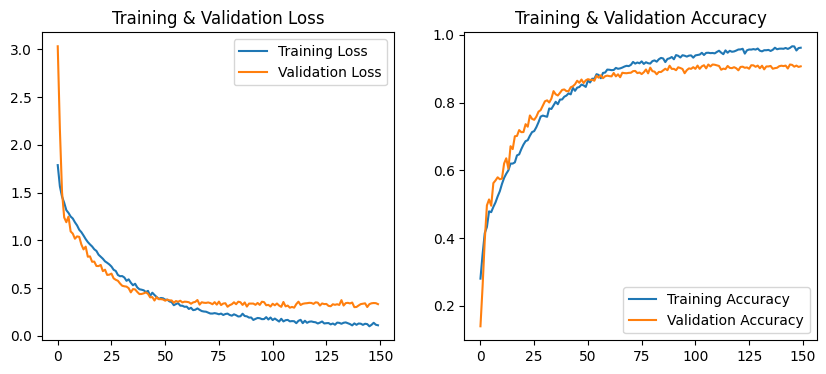



66/66 [==============================] - 0s 2ms/step


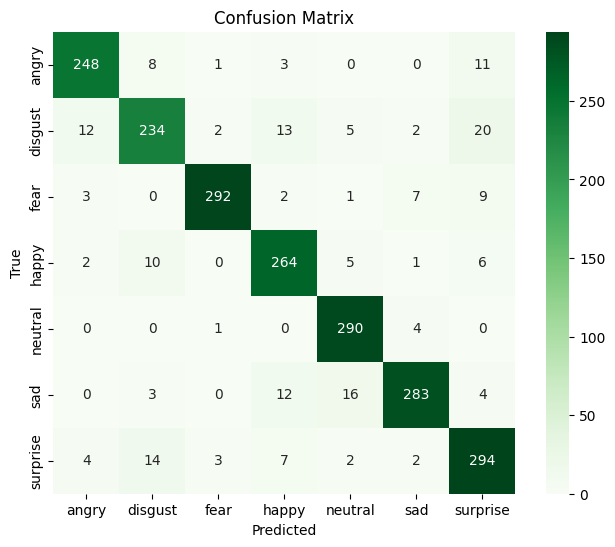



66/66 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

       angry       0.92      0.92      0.92       271
     disgust       0.87      0.81      0.84       288
        fear       0.98      0.93      0.95       314
       happy       0.88      0.92      0.90       288
     neutral       0.91      0.98      0.94       295
         sad       0.95      0.89      0.92       318
    surprise       0.85      0.90      0.88       326

    accuracy                           0.91      2100
   macro avg       0.91      0.91      0.91      2100
weighted avg       0.91      0.91      0.91      2100



66/66 [==============================] - 0s 2ms/step


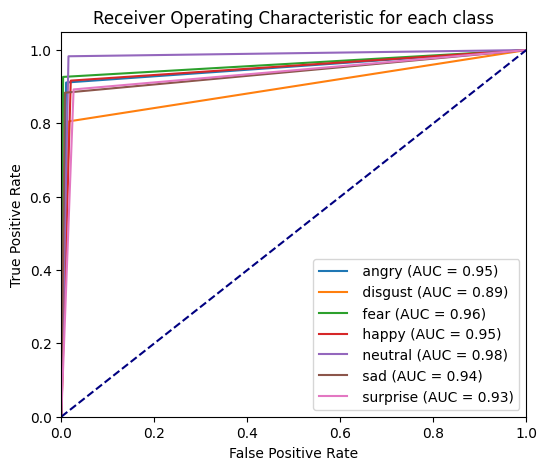

In [ ]:
results()

### **70-30**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
model = Sequential()

model.add(Conv1D(512, 5, padding='same', input_shape=(X_train.shape[1],1)))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Conv1D(256, 5, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv1D(128, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(7, activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=150, validation_data=(X_test, y_test),batch_size=64)

Epoch 1/150
77/77 [==============================] - 8s 26ms/step - loss: 1.7633 - accuracy: 0.2688 - val_loss: 2.4779 - val_accuracy: 0.1719
Epoch 2/150
77/77 [==============================] - 1s 9ms/step - loss: 1.5287 - accuracy: 0.3692 - val_loss: 1.6350 - val_accuracy: 0.3638
Epoch 3/150
77/77 [==============================] - 1s 10ms/step - loss: 1.4407 - accuracy: 0.4192 - val_loss: 1.3378 - val_accuracy: 0.4662
Epoch 4/150
77/77 [==============================] - 1s 10ms/step - loss: 1.3513 - accuracy: 0.4573 - val_loss: 1.2495 - val_accuracy: 0.5033
Epoch 5/150
77/77 [==============================] - 1s 9ms/step - loss: 1.2884 - accuracy: 0.4855 - val_loss: 1.1348 - val_accuracy: 0.5248
Epoch 6/150
77/77 [==============================] - 1s 10ms/step - loss: 1.2617 - accuracy: 0.4965 - val_loss: 1.1140 - val_accuracy: 0.5414
Epoch 7/150
77/77 [==============================] - 1s 10ms/step - loss: 1.2159 - accuracy: 0.5147 - val_loss: 1.0235 - val_accuracy: 0.5967
Epoch 8/

66/66 [==============================] - 0s 3ms/step
Accuracy: 0.9238095238095239
Precision: 0.9234956004204619
Recall: 0.9239970590340951
F1 Score: 0.923496067486452




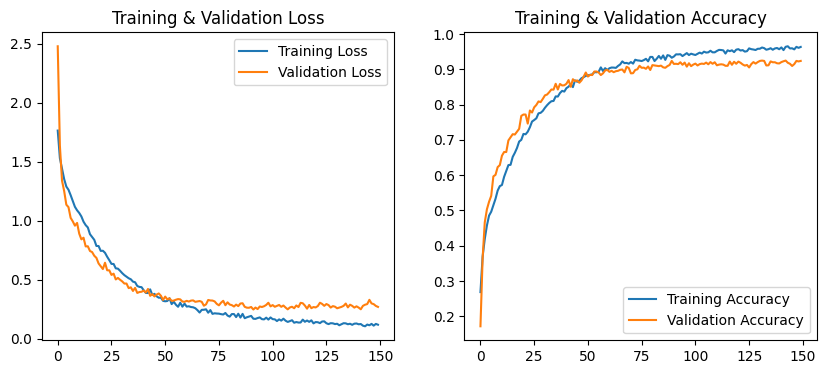



66/66 [==============================] - 0s 2ms/step


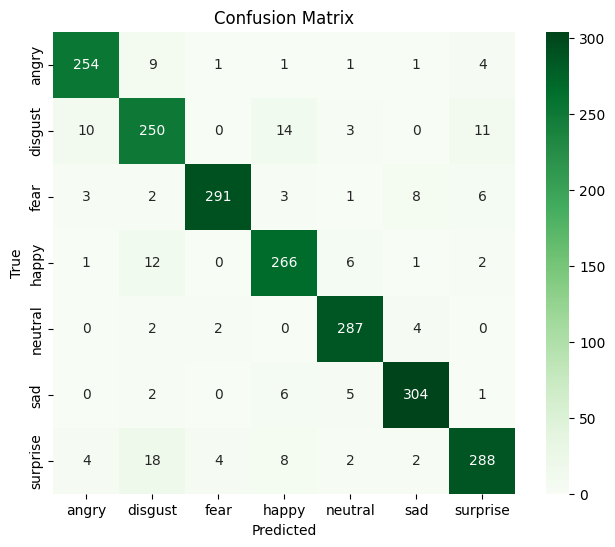



66/66 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

       angry       0.93      0.94      0.94       271
     disgust       0.85      0.87      0.86       288
        fear       0.98      0.93      0.95       314
       happy       0.89      0.92      0.91       288
     neutral       0.94      0.97      0.96       295
         sad       0.95      0.96      0.95       318
    surprise       0.92      0.88      0.90       326

    accuracy                           0.92      2100
   macro avg       0.92      0.92      0.92      2100
weighted avg       0.92      0.92      0.92      2100



66/66 [==============================] - 0s 2ms/step


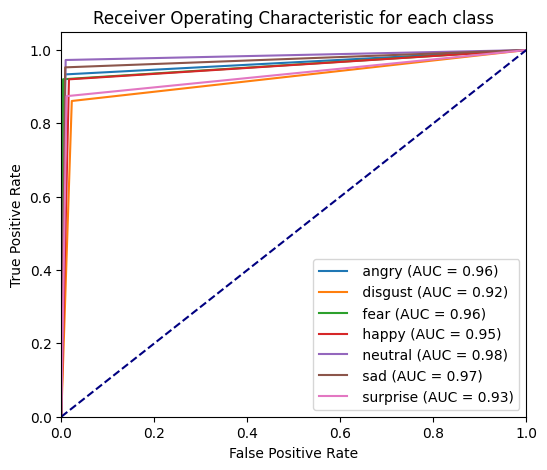

In [ ]:
results()

###**80-20**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = Sequential()

model.add(Conv1D(512, 5, padding='same', input_shape=(X_train.shape[1],1)))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Conv1D(256, 5, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv1D(128, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.3))

model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.1))

model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.1))

model.add(Dense(7, activation='softmax'))

initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=300, decay_rate=0.9, staircase=True
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=150, validation_data=(X_test, y_test),batch_size=64)

Epoch 1/150
88/88 [==============================] - 10s 18ms/step - loss: 1.5377 - accuracy: 0.3812 - val_loss: 2.4369 - val_accuracy: 0.2179
Epoch 2/150
88/88 [==============================] - 1s 14ms/step - loss: 1.3056 - accuracy: 0.4816 - val_loss: 1.5335 - val_accuracy: 0.4443
Epoch 3/150
88/88 [==============================] - 1s 14ms/step - loss: 1.1782 - accuracy: 0.5273 - val_loss: 1.1603 - val_accuracy: 0.5393
Epoch 4/150
88/88 [==============================] - 2s 18ms/step - loss: 1.0727 - accuracy: 0.5689 - val_loss: 0.9373 - val_accuracy: 0.6157
Epoch 5/150
88/88 [==============================] - 1s 13ms/step - loss: 0.9780 - accuracy: 0.6059 - val_loss: 0.9106 - val_accuracy: 0.6207
Epoch 6/150
88/88 [==============================] - 1s 11ms/step - loss: 0.9076 - accuracy: 0.6411 - val_loss: 0.8411 - val_accuracy: 0.6657
Epoch 7/150
88/88 [==============================] - 1s 13ms/step - loss: 0.8220 - accuracy: 0.6784 - val_loss: 0.7502 - val_accuracy: 0.7114
Epoch

44/44 [==============================] - 0s 4ms/step
Accuracy: 0.9428571428571428
Precision: 0.9424472480955147
Recall: 0.9423350039938612
F1 Score: 0.9423085085372548




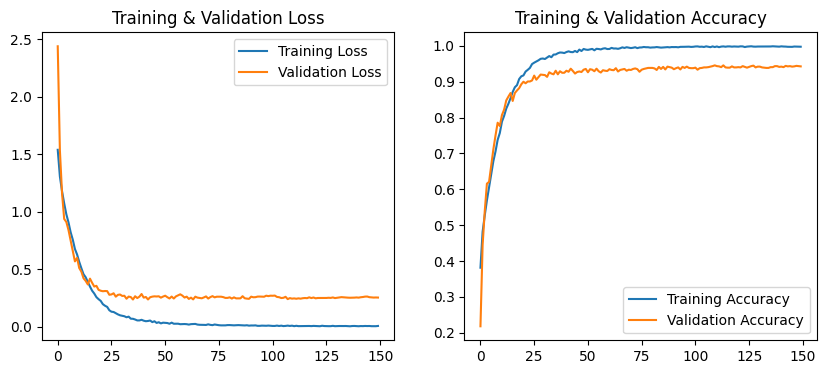



44/44 [==============================] - 0s 4ms/step


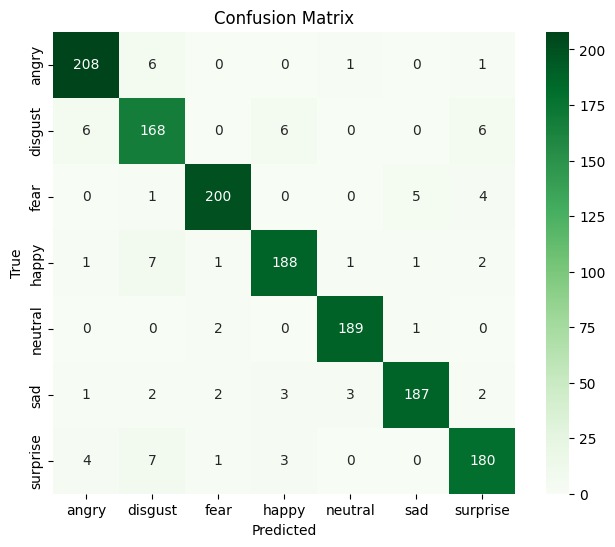



44/44 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

       angry       0.95      0.96      0.95       216
     disgust       0.88      0.90      0.89       186
        fear       0.97      0.95      0.96       210
       happy       0.94      0.94      0.94       201
     neutral       0.97      0.98      0.98       192
         sad       0.96      0.94      0.95       200
    surprise       0.92      0.92      0.92       195

    accuracy                           0.94      1400
   macro avg       0.94      0.94      0.94      1400
weighted avg       0.94      0.94      0.94      1400



44/44 [==============================] - 0s 4ms/step


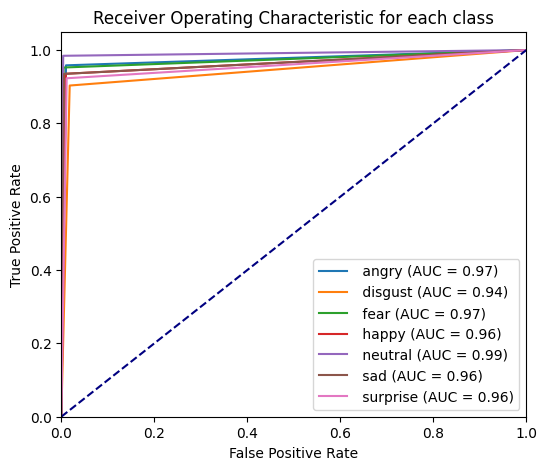

In [ ]:
results()

In [ ]:
model = Sequential()

model.add(Conv1D(512, 5, padding='same', input_shape=(X_train.shape[1],1)))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Conv1D(256, 5, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv1D(128, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.3))

model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.1))

model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.1))

model.add(Dense(7, activation='softmax'))

initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=300, decay_rate=0.9, staircase=True
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test),batch_size=64)

Epoch 1/200
88/88 [==============================] - 10s 18ms/step - loss: 1.5591 - accuracy: 0.3604 - val_loss: 2.1554 - val_accuracy: 0.2543
Epoch 2/200
88/88 [==============================] - 1s 9ms/step - loss: 1.2980 - accuracy: 0.4784 - val_loss: 1.3914 - val_accuracy: 0.4829
Epoch 3/200
88/88 [==============================] - 1s 9ms/step - loss: 1.1702 - accuracy: 0.5346 - val_loss: 1.1667 - val_accuracy: 0.5500
Epoch 4/200
88/88 [==============================] - 1s 9ms/step - loss: 1.0730 - accuracy: 0.5750 - val_loss: 0.9103 - val_accuracy: 0.6329
Epoch 5/200
88/88 [==============================] - 1s 9ms/step - loss: 0.9720 - accuracy: 0.6091 - val_loss: 0.9464 - val_accuracy: 0.6300
Epoch 6/200
88/88 [==============================] - 1s 10ms/step - loss: 0.8819 - accuracy: 0.6577 - val_loss: 0.8234 - val_accuracy: 0.6707
Epoch 7/200
88/88 [==============================] - 1s 9ms/step - loss: 0.7973 - accuracy: 0.6955 - val_loss: 0.7188 - val_accuracy: 0.7186
Epoch 8/20

44/44 [==============================] - 1s 8ms/step
Accuracy: 0.9435714285714286
Precision: 0.9429030424323835
Recall: 0.9438914859560426
F1 Score: 0.9431830957971844




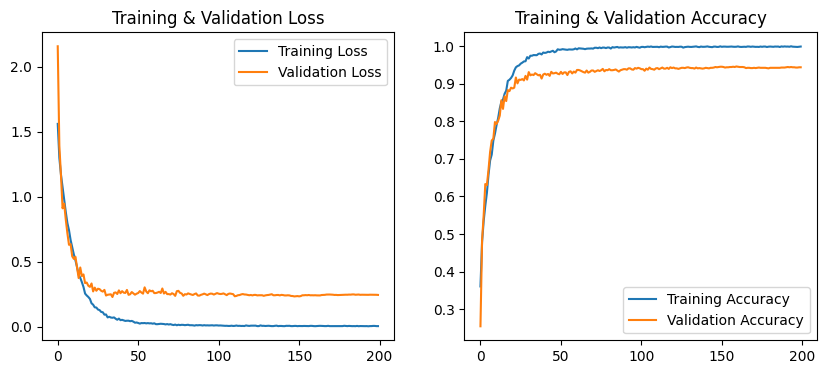



44/44 [==============================] - 0s 4ms/step


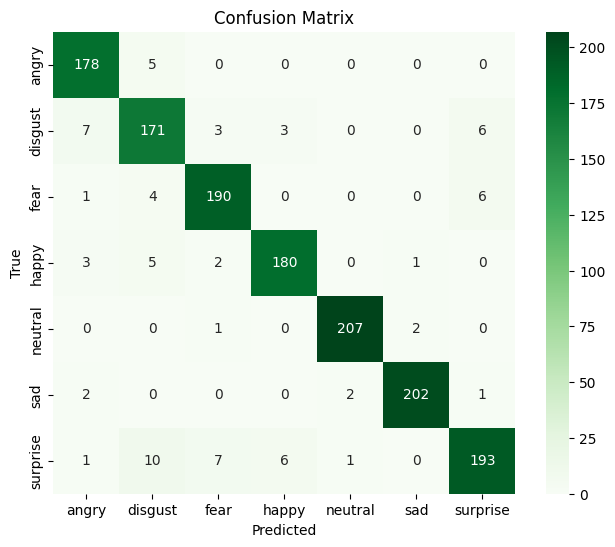



44/44 [==============================] - 0s 7ms/step
              precision    recall  f1-score   support

       angry       0.93      0.97      0.95       183
     disgust       0.88      0.90      0.89       190
        fear       0.94      0.95      0.94       201
       happy       0.95      0.94      0.95       191
     neutral       0.99      0.99      0.99       210
         sad       0.99      0.98      0.98       207
    surprise       0.94      0.89      0.91       218

    accuracy                           0.94      1400
   macro avg       0.94      0.94      0.94      1400
weighted avg       0.94      0.94      0.94      1400



44/44 [==============================] - 0s 5ms/step


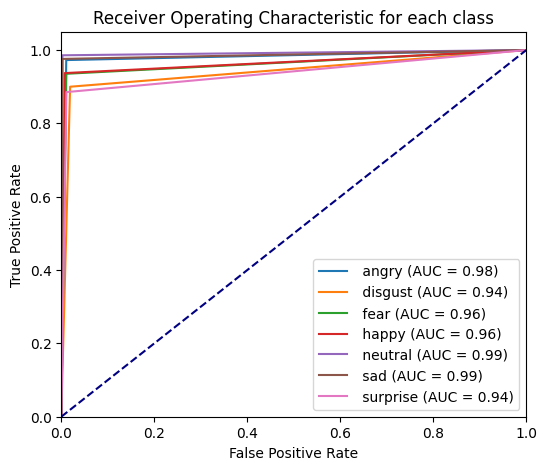

In [ ]:
results()

####**Highest Acc of CNN**

In [ ]:
model = Sequential()

model.add(Conv1D(512, 5, padding='same', input_shape=(X_train.shape[1],1)))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Conv1D(256, 5, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv1D(128, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(7, activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=1000, validation_data=(X_test, y_test),batch_size=64)

Epoch 1/1000
88/88 [==============================] - 29s 18ms/step - loss: 1.9946 - accuracy: 0.1993 - val_loss: 1.7846 - val_accuracy: 0.2371
Epoch 2/1000
88/88 [==============================] - 1s 13ms/step - loss: 1.7851 - accuracy: 0.2721 - val_loss: 1.6125 - val_accuracy: 0.3629
Epoch 3/1000
88/88 [==============================] - 1s 17ms/step - loss: 1.7315 - accuracy: 0.2866 - val_loss: 1.5888 - val_accuracy: 0.3471
Epoch 4/1000
88/88 [==============================] - 2s 18ms/step - loss: 1.6789 - accuracy: 0.3123 - val_loss: 1.5661 - val_accuracy: 0.3593
Epoch 5/1000
88/88 [==============================] - 2s 19ms/step - loss: 1.6455 - accuracy: 0.3032 - val_loss: 1.5338 - val_accuracy: 0.3764
Epoch 6/1000
88/88 [==============================] - 2s 21ms/step - loss: 1.6028 - accuracy: 0.3268 - val_loss: 1.5074 - val_accuracy: 0.3900
Epoch 7/1000
88/88 [==============================] - 2s 22ms/step - loss: 1.5812 - accuracy: 0.3459 - val_loss: 1.4825 - val_accuracy: 0.396

44/44 [==============================] - 1s 8ms/step
Accuracy: 0.9535714285714286
Precision: 0.9531383724688328
Recall: 0.9530590174839695
F1 Score: 0.953038506732615




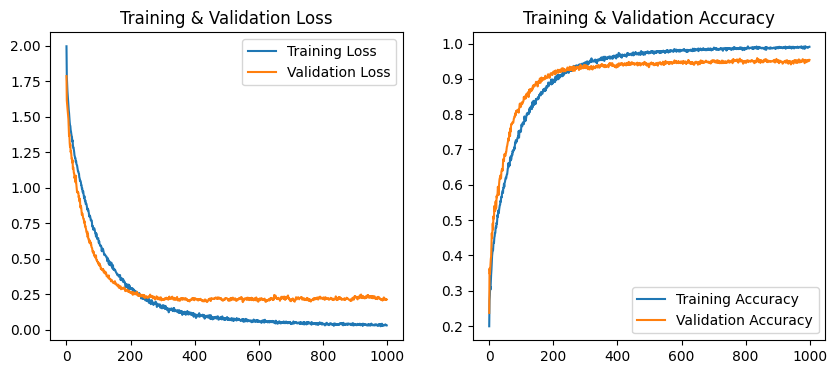



44/44 [==============================] - 1s 11ms/step


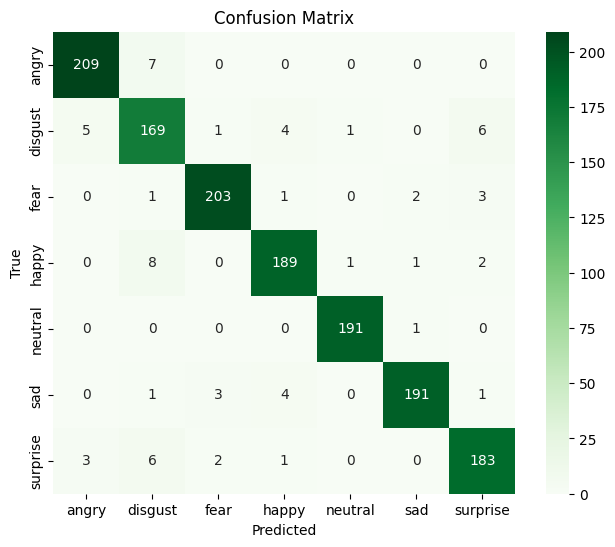



44/44 [==============================] - 0s 9ms/step
              precision    recall  f1-score   support

       angry       0.96      0.97      0.97       216
     disgust       0.88      0.91      0.89       186
        fear       0.97      0.97      0.97       210
       happy       0.95      0.94      0.95       201
     neutral       0.99      0.99      0.99       192
         sad       0.98      0.95      0.97       200
    surprise       0.94      0.94      0.94       195

    accuracy                           0.95      1400
   macro avg       0.95      0.95      0.95      1400
weighted avg       0.95      0.95      0.95      1400



44/44 [==============================] - 1s 11ms/step


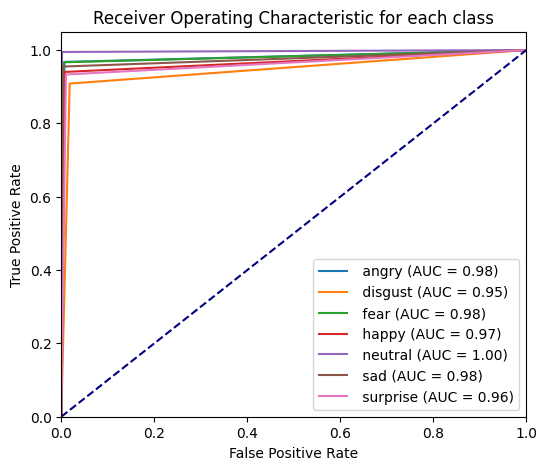

In [ ]:
results()

44/44 [==============================] - 0s 4ms/step


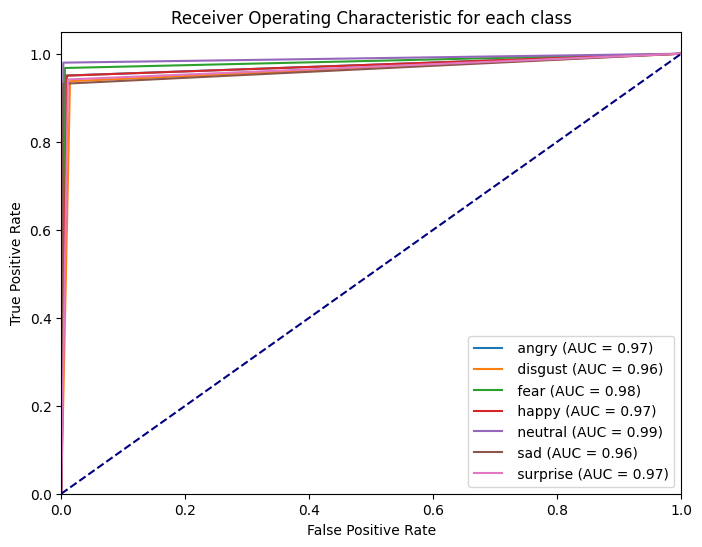

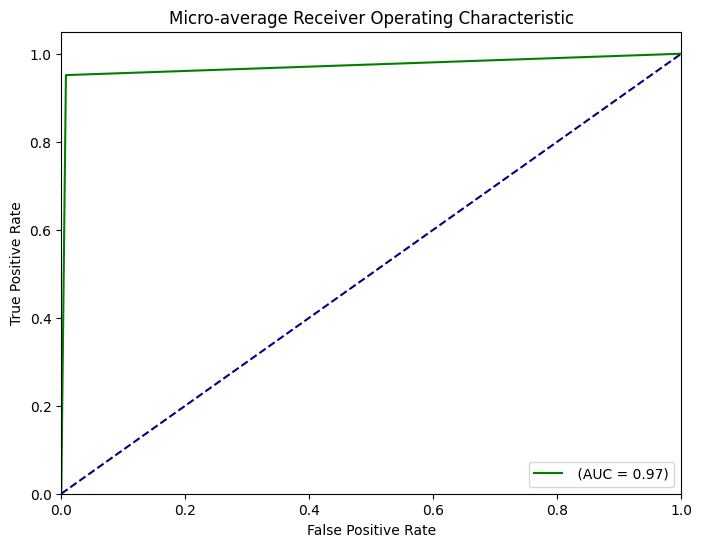

AUC =  0.9719642857142858


In [ ]:
Roc_curve()

In [ ]:
# Save the model to a file
model.save('/content/drive/MyDrive/Thesis/Audio/CNN_95.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


##**ANN**

###**60-40**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [ ]:
model = Sequential()
model.add(Flatten())

model.add(Dense(1024, activation='relu', input_shape=(X_train.shape[1],1)))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(7, activation='softmax'))

initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=300, decay_rate=0.9, staircase=True
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test),batch_size=64)

Epoch 1/200
66/66 [==============================] - 6s 13ms/step - loss: 1.4836 - accuracy: 0.4367 - val_loss: 5.5155 - val_accuracy: 0.1982
Epoch 2/200
66/66 [==============================] - 1s 10ms/step - loss: 1.1289 - accuracy: 0.5629 - val_loss: 1.6074 - val_accuracy: 0.4689
Epoch 3/200
66/66 [==============================] - 1s 11ms/step - loss: 0.9753 - accuracy: 0.6245 - val_loss: 0.9566 - val_accuracy: 0.6296
Epoch 4/200
66/66 [==============================] - 1s 15ms/step - loss: 0.8415 - accuracy: 0.6786 - val_loss: 0.7808 - val_accuracy: 0.6943
Epoch 5/200
66/66 [==============================] - 1s 15ms/step - loss: 0.7764 - accuracy: 0.7060 - val_loss: 0.7912 - val_accuracy: 0.7011
Epoch 6/200
66/66 [==============================] - 1s 10ms/step - loss: 0.6864 - accuracy: 0.7379 - val_loss: 0.7607 - val_accuracy: 0.7161
Epoch 7/200
66/66 [==============================] - 1s 9ms/step - loss: 0.6009 - accuracy: 0.7814 - val_loss: 0.6570 - val_accuracy: 0.7643
Epoch 8

88/88 [==============================] - 1s 6ms/step
Accuracy: 0.9414285714285714
Precision: 0.9406235872160627
Recall: 0.9412401013568559
F1 Score: 0.9407779246666649




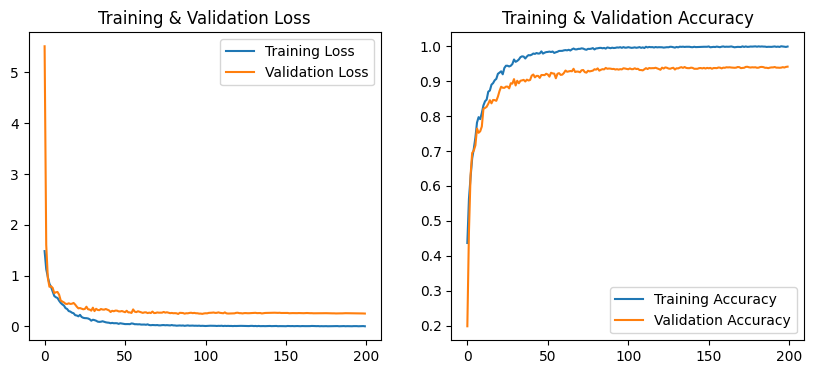



88/88 [==============================] - 0s 5ms/step


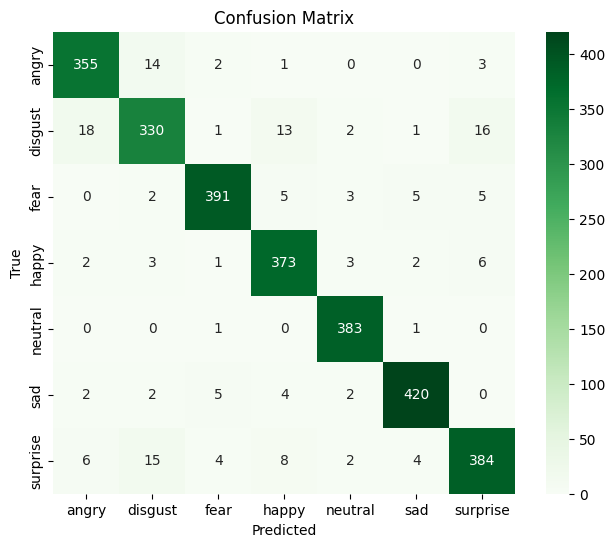



88/88 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

       angry       0.93      0.95      0.94       375
     disgust       0.90      0.87      0.88       381
        fear       0.97      0.95      0.96       411
       happy       0.92      0.96      0.94       390
     neutral       0.97      0.99      0.98       385
         sad       0.97      0.97      0.97       435
    surprise       0.93      0.91      0.92       423

    accuracy                           0.94      2800
   macro avg       0.94      0.94      0.94      2800
weighted avg       0.94      0.94      0.94      2800



88/88 [==============================] - 0s 3ms/step


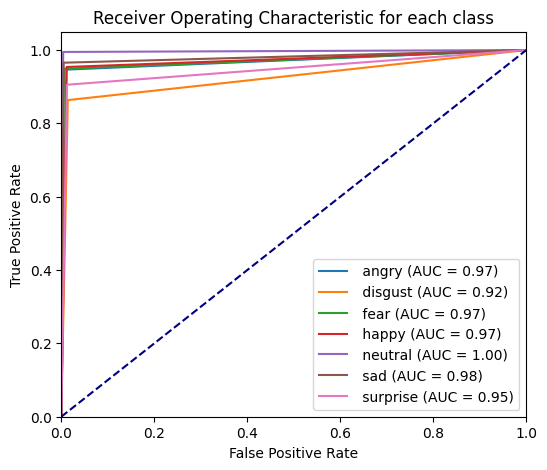

In [ ]:
results()

###**70-30**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
model = Sequential()
model.add(Flatten())

model.add(Dense(1024, activation='relu', input_shape=(X_train.shape[1],1)))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(7, activation='softmax'))

initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=300, decay_rate=0.9, staircase=True
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test),batch_size=64)

Epoch 1/200
77/77 [==============================] - 14s 29ms/step - loss: 1.4635 - accuracy: 0.4490 - val_loss: 2.6961 - val_accuracy: 0.2800
Epoch 2/200
77/77 [==============================] - 1s 18ms/step - loss: 1.0810 - accuracy: 0.5790 - val_loss: 1.2152 - val_accuracy: 0.5305
Epoch 3/200
77/77 [==============================] - 1s 16ms/step - loss: 0.9286 - accuracy: 0.6418 - val_loss: 0.8508 - val_accuracy: 0.6786
Epoch 4/200
77/77 [==============================] - 1s 16ms/step - loss: 0.8371 - accuracy: 0.6818 - val_loss: 0.7714 - val_accuracy: 0.7062
Epoch 5/200
77/77 [==============================] - 1s 15ms/step - loss: 0.7356 - accuracy: 0.7133 - val_loss: 0.7258 - val_accuracy: 0.7119
Epoch 6/200
77/77 [==============================] - 1s 14ms/step - loss: 0.6577 - accuracy: 0.7539 - val_loss: 0.6741 - val_accuracy: 0.7405
Epoch 7/200
77/77 [==============================] - 1s 19ms/step - loss: 0.6284 - accuracy: 0.7682 - val_loss: 0.6603 - val_accuracy: 0.7529
Epoch

66/66 [==============================] - 0s 2ms/step
Accuracy: 0.9476190476190476
Precision: 0.9469849546013585
Recall: 0.9480220307017941
F1 Score: 0.9473362130959491




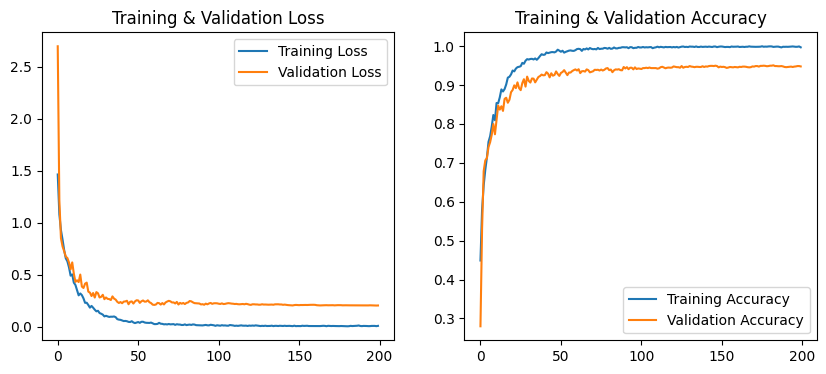



66/66 [==============================] - 0s 2ms/step


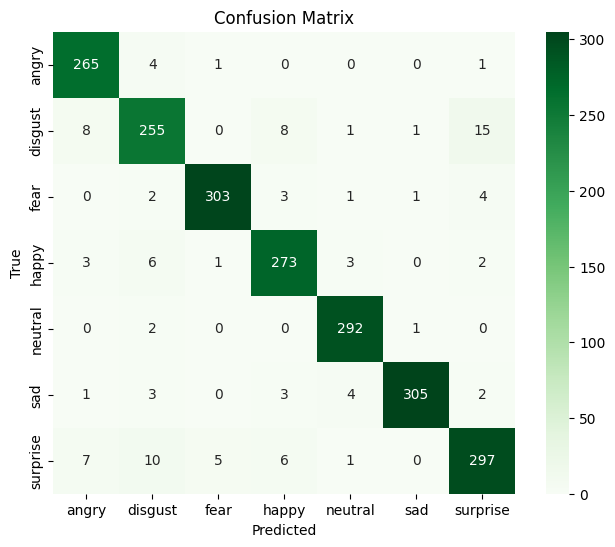



66/66 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

       angry       0.93      0.98      0.95       271
     disgust       0.90      0.89      0.89       288
        fear       0.98      0.96      0.97       314
       happy       0.93      0.95      0.94       288
     neutral       0.97      0.99      0.98       295
         sad       0.99      0.96      0.97       318
    surprise       0.93      0.91      0.92       326

    accuracy                           0.95      2100
   macro avg       0.95      0.95      0.95      2100
weighted avg       0.95      0.95      0.95      2100



66/66 [==============================] - 0s 3ms/step


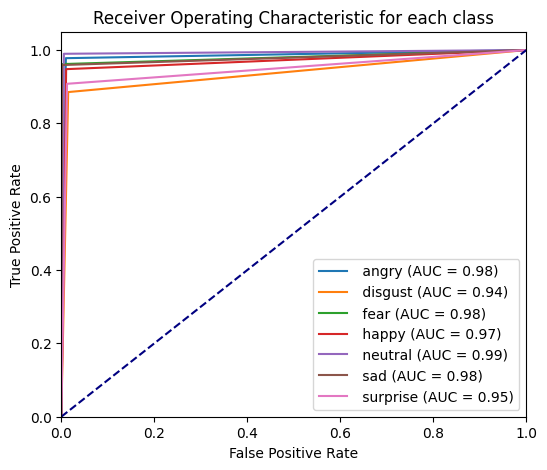

In [ ]:
results()

###**80-20**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = Sequential()
model.add(Flatten())

model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(7, activation='softmax'))

initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=300, decay_rate=0.9, staircase=True
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=150, validation_data=(X_test, y_test),batch_size=64)

Epoch 1/150
88/88 [==============================] - 9s 14ms/step - loss: 1.4742 - accuracy: 0.4527 - val_loss: 3.6389 - val_accuracy: 0.2514
Epoch 2/150
88/88 [==============================] - 1s 9ms/step - loss: 1.0820 - accuracy: 0.5816 - val_loss: 1.0594 - val_accuracy: 0.6014
Epoch 3/150
88/88 [==============================] - 1s 9ms/step - loss: 0.9453 - accuracy: 0.6429 - val_loss: 0.7911 - val_accuracy: 0.7014
Epoch 4/150
88/88 [==============================] - 1s 9ms/step - loss: 0.8066 - accuracy: 0.6963 - val_loss: 0.7399 - val_accuracy: 0.7143
Epoch 5/150
88/88 [==============================] - 1s 9ms/step - loss: 0.7229 - accuracy: 0.7296 - val_loss: 0.6792 - val_accuracy: 0.7414
Epoch 6/150
88/88 [==============================] - 1s 9ms/step - loss: 0.6431 - accuracy: 0.7595 - val_loss: 0.6336 - val_accuracy: 0.7707
Epoch 7/150
88/88 [==============================] - 1s 9ms/step - loss: 0.5948 - accuracy: 0.7745 - val_loss: 0.5602 - val_accuracy: 0.7950
Epoch 8/150


44/44 [==============================] - 0s 2ms/step
Accuracy: 0.95
Precision: 0.9496282529811919
Recall: 0.9506976345074566
F1 Score: 0.9498011229597216




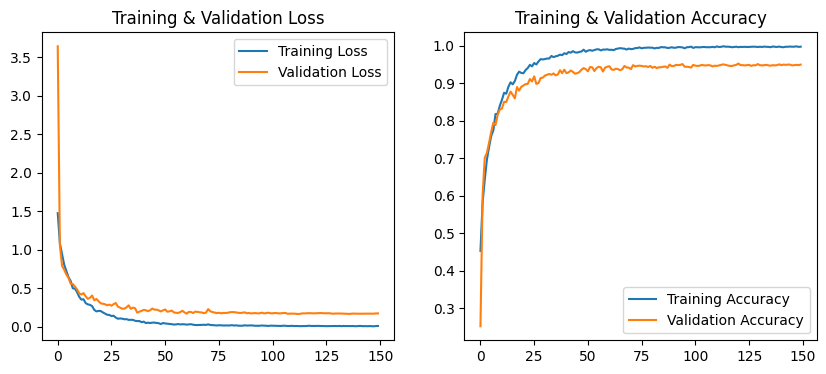



44/44 [==============================] - 0s 2ms/step


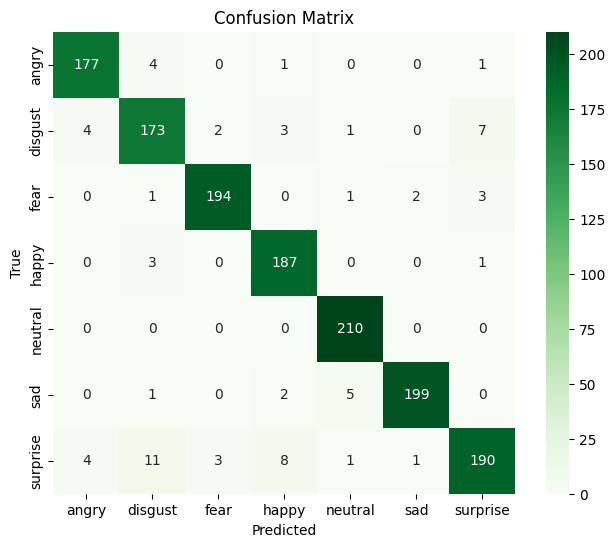



44/44 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

       angry       0.96      0.97      0.96       183
     disgust       0.90      0.91      0.90       190
        fear       0.97      0.97      0.97       201
       happy       0.93      0.98      0.95       191
     neutral       0.96      1.00      0.98       210
         sad       0.99      0.96      0.97       207
    surprise       0.94      0.87      0.90       218

    accuracy                           0.95      1400
   macro avg       0.95      0.95      0.95      1400
weighted avg       0.95      0.95      0.95      1400



44/44 [==============================] - 0s 2ms/step


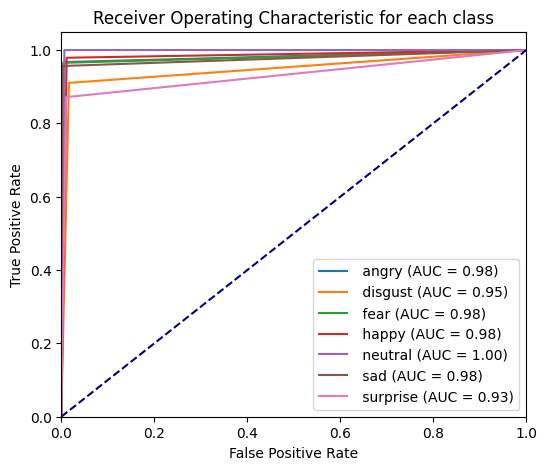

In [ ]:
results()

In [ ]:
model = Sequential()
model.add(Flatten())

model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(7, activation='softmax'))

initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=300, decay_rate=0.9, staircase=True
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test),batch_size=64)

Epoch 1/200
88/88 [==============================] - 5s 12ms/step - loss: 1.4527 - accuracy: 0.4493 - val_loss: 3.4633 - val_accuracy: 0.2729
Epoch 2/200
88/88 [==============================] - 1s 9ms/step - loss: 1.0684 - accuracy: 0.5830 - val_loss: 1.2189 - val_accuracy: 0.5229
Epoch 3/200
88/88 [==============================] - 1s 10ms/step - loss: 0.9315 - accuracy: 0.6368 - val_loss: 0.7995 - val_accuracy: 0.7014
Epoch 4/200
88/88 [==============================] - 1s 13ms/step - loss: 0.8196 - accuracy: 0.6854 - val_loss: 0.6942 - val_accuracy: 0.7300
Epoch 5/200
88/88 [==============================] - 1s 13ms/step - loss: 0.7304 - accuracy: 0.7296 - val_loss: 0.7281 - val_accuracy: 0.7193
Epoch 6/200
88/88 [==============================] - 1s 12ms/step - loss: 0.6519 - accuracy: 0.7561 - val_loss: 0.5460 - val_accuracy: 0.7857
Epoch 7/200
88/88 [==============================] - 1s 9ms/step - loss: 0.5991 - accuracy: 0.7805 - val_loss: 0.5986 - val_accuracy: 0.7814
Epoch 8/

44/44 [==============================] - 1s 5ms/step
Accuracy: 0.9578571428571429
Precision: 0.9574260437891507
Recall: 0.9582568543338301
F1 Score: 0.9576274923214223




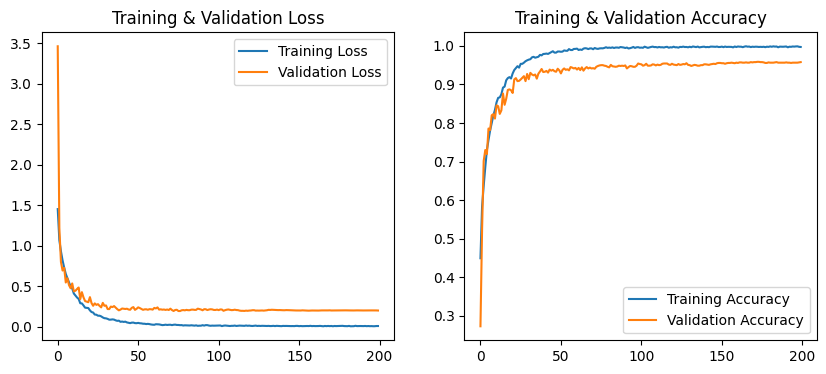



44/44 [==============================] - 0s 5ms/step


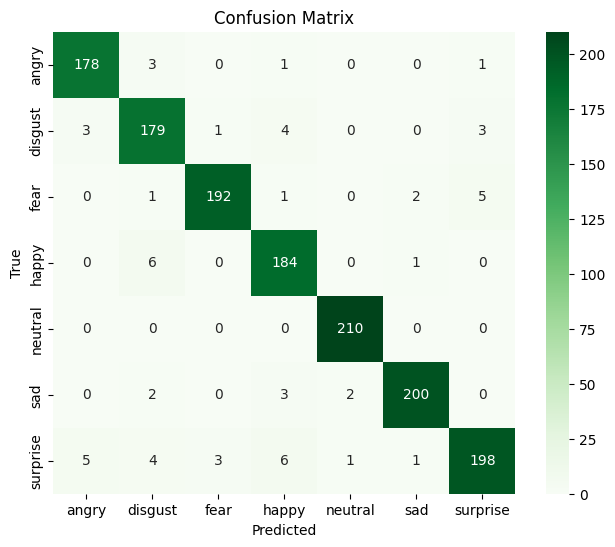



44/44 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

       angry       0.96      0.97      0.96       183
     disgust       0.92      0.94      0.93       190
        fear       0.98      0.96      0.97       201
       happy       0.92      0.96      0.94       191
     neutral       0.99      1.00      0.99       210
         sad       0.98      0.97      0.97       207
    surprise       0.96      0.91      0.93       218

    accuracy                           0.96      1400
   macro avg       0.96      0.96      0.96      1400
weighted avg       0.96      0.96      0.96      1400



44/44 [==============================] - 0s 5ms/step


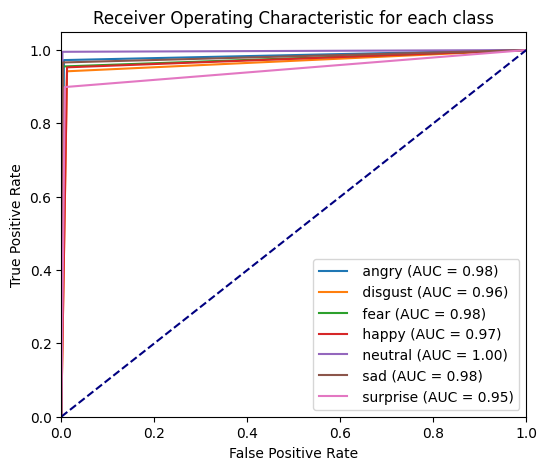

In [ ]:
results()

In [ ]:
model = Sequential()
model.add(Flatten())

model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(7, activation='softmax'))

initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=300, decay_rate=0.9, staircase=True
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test),batch_size=64)

Epoch 1/200
88/88 [==============================] - 5s 12ms/step - loss: 1.4698 - accuracy: 0.4546 - val_loss: 2.8021 - val_accuracy: 0.2886
Epoch 2/200
88/88 [==============================] - 1s 10ms/step - loss: 1.0779 - accuracy: 0.5750 - val_loss: 1.0728 - val_accuracy: 0.6014
Epoch 3/200
88/88 [==============================] - 1s 9ms/step - loss: 0.9128 - accuracy: 0.6523 - val_loss: 0.8396 - val_accuracy: 0.6843
Epoch 4/200
88/88 [==============================] - 1s 9ms/step - loss: 0.8009 - accuracy: 0.6921 - val_loss: 0.7876 - val_accuracy: 0.7136
Epoch 5/200
88/88 [==============================] - 1s 11ms/step - loss: 0.7103 - accuracy: 0.7289 - val_loss: 0.6611 - val_accuracy: 0.7636
Epoch 6/200
88/88 [==============================] - 1s 13ms/step - loss: 0.6449 - accuracy: 0.7586 - val_loss: 0.6646 - val_accuracy: 0.7550
Epoch 7/200
88/88 [==============================] - 1s 13ms/step - loss: 0.5974 - accuracy: 0.7764 - val_loss: 0.6812 - val_accuracy: 0.7400
Epoch 8/

44/44 [==============================] - 0s 3ms/step
Accuracy: 0.9585714285714285
Precision: 0.9580581569757276
Recall: 0.9594007851701497
F1 Score: 0.9584151167237724




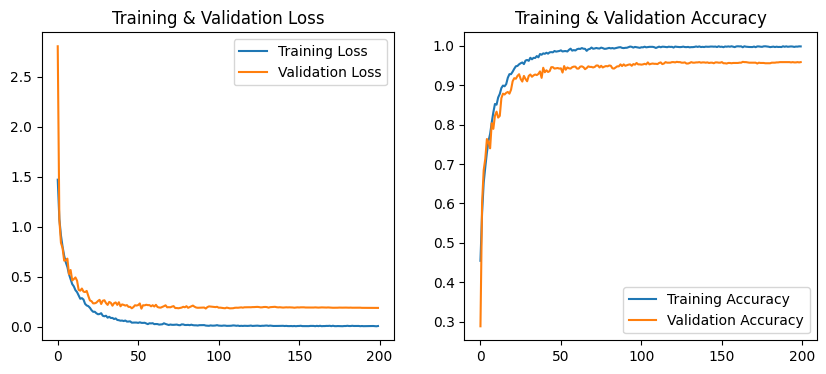



44/44 [==============================] - 0s 6ms/step


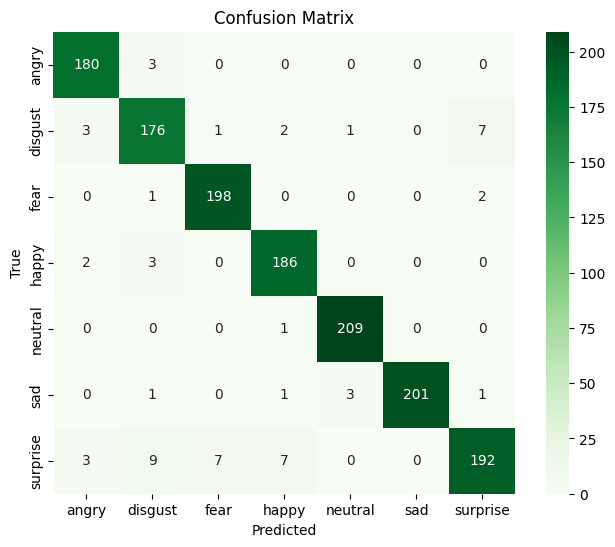



44/44 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

       angry       0.96      0.98      0.97       183
     disgust       0.91      0.93      0.92       190
        fear       0.96      0.99      0.97       201
       happy       0.94      0.97      0.96       191
     neutral       0.98      1.00      0.99       210
         sad       1.00      0.97      0.99       207
    surprise       0.95      0.88      0.91       218

    accuracy                           0.96      1400
   macro avg       0.96      0.96      0.96      1400
weighted avg       0.96      0.96      0.96      1400



44/44 [==============================] - 0s 4ms/step


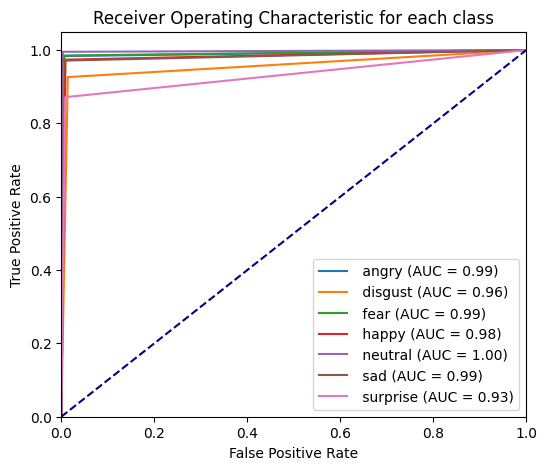

In [ ]:
results()

####**Highest Acc of ANN**

In [ ]:
model = Sequential()
model.add(Flatten())

model.add(Dense(2048, activation='relu', input_shape=(X_train.shape[1],1)))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(7, activation='softmax'))

initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=300, decay_rate=0.9, staircase=True
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test),batch_size=64)

Epoch 1/200
88/88 [==============================] - 8s 13ms/step - loss: 1.5111 - accuracy: 0.4196 - val_loss: 3.8890 - val_accuracy: 0.2271
Epoch 2/200
88/88 [==============================] - 1s 10ms/step - loss: 1.1253 - accuracy: 0.5482 - val_loss: 1.1820 - val_accuracy: 0.5714
Epoch 3/200
88/88 [==============================] - 1s 10ms/step - loss: 0.9875 - accuracy: 0.6152 - val_loss: 0.8365 - val_accuracy: 0.6821
Epoch 4/200
88/88 [==============================] - 1s 10ms/step - loss: 0.8717 - accuracy: 0.6641 - val_loss: 0.8410 - val_accuracy: 0.6757
Epoch 5/200
88/88 [==============================] - 1s 10ms/step - loss: 0.7504 - accuracy: 0.7216 - val_loss: 0.8371 - val_accuracy: 0.7050
Epoch 6/200
88/88 [==============================] - 1s 10ms/step - loss: 0.7024 - accuracy: 0.7380 - val_loss: 0.9033 - val_accuracy: 0.6636
Epoch 7/200
88/88 [==============================] - 1s 10ms/step - loss: 0.6153 - accuracy: 0.7691 - val_loss: 0.7960 - val_accuracy: 0.7107
Epoch 

44/44 [==============================] - 1s 4ms/step
Accuracy: 0.9592857142857143
Precision: 0.9589550047128129
Recall: 0.960215338863489
F1 Score: 0.9592258290640234




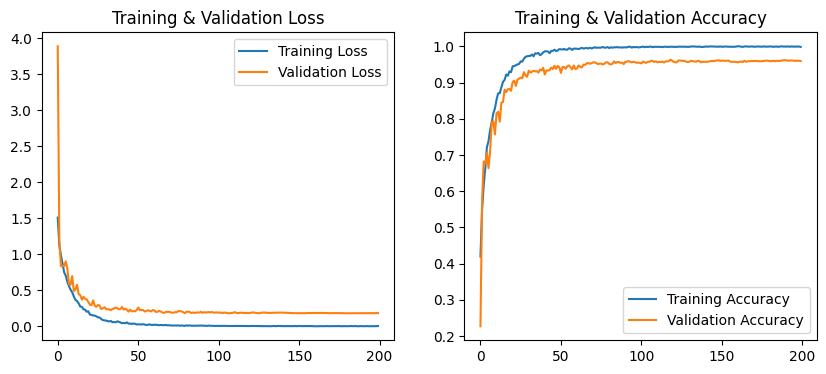



44/44 [==============================] - 0s 7ms/step


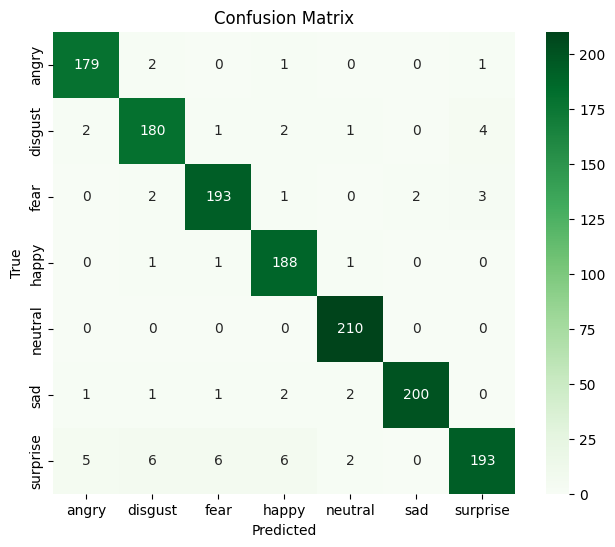



44/44 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

       angry       0.96      0.98      0.97       183
     disgust       0.94      0.95      0.94       190
        fear       0.96      0.96      0.96       201
       happy       0.94      0.98      0.96       191
     neutral       0.97      1.00      0.99       210
         sad       0.99      0.97      0.98       207
    surprise       0.96      0.89      0.92       218

    accuracy                           0.96      1400
   macro avg       0.96      0.96      0.96      1400
weighted avg       0.96      0.96      0.96      1400



44/44 [==============================] - 0s 4ms/step


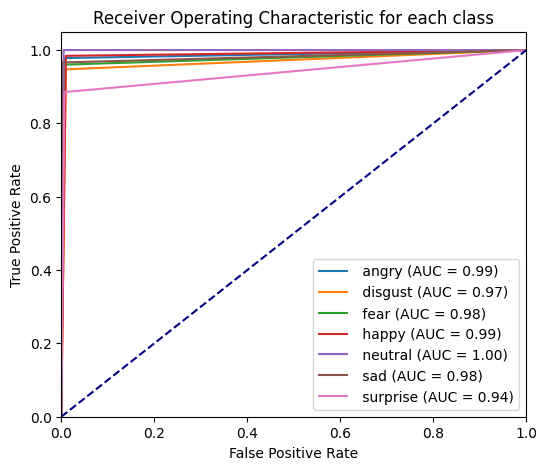

In [ ]:
results()

In [ ]:
model = Sequential()
model.add(Flatten())

model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(7, activation='softmax'))

initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=300, decay_rate=0.9, staircase=True
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test),batch_size=64)

Epoch 1/200
88/88 [==============================] - 11s 24ms/step - loss: 1.4486 - accuracy: 0.4582 - val_loss: 3.6269 - val_accuracy: 0.2843
Epoch 2/200
88/88 [==============================] - 1s 16ms/step - loss: 1.0666 - accuracy: 0.5921 - val_loss: 1.0685 - val_accuracy: 0.5857
Epoch 3/200
88/88 [==============================] - 1s 13ms/step - loss: 0.9294 - accuracy: 0.6425 - val_loss: 0.8930 - val_accuracy: 0.6557
Epoch 4/200
88/88 [==============================] - 1s 13ms/step - loss: 0.7902 - accuracy: 0.7045 - val_loss: 0.8176 - val_accuracy: 0.6950
Epoch 5/200
88/88 [==============================] - 1s 9ms/step - loss: 0.7167 - accuracy: 0.7304 - val_loss: 0.6554 - val_accuracy: 0.7614
Epoch 6/200
88/88 [==============================] - 1s 8ms/step - loss: 0.6523 - accuracy: 0.7595 - val_loss: 0.6029 - val_accuracy: 0.7757
Epoch 7/200
88/88 [==============================] - 1s 9ms/step - loss: 0.5714 - accuracy: 0.7891 - val_loss: 0.6477 - val_accuracy: 0.7593
Epoch 8/

44/44 [==============================] - 0s 2ms/step
Accuracy: 0.9564285714285714
Precision: 0.95581961430445
Recall: 0.9571865013152409
F1 Score: 0.9560717265349974




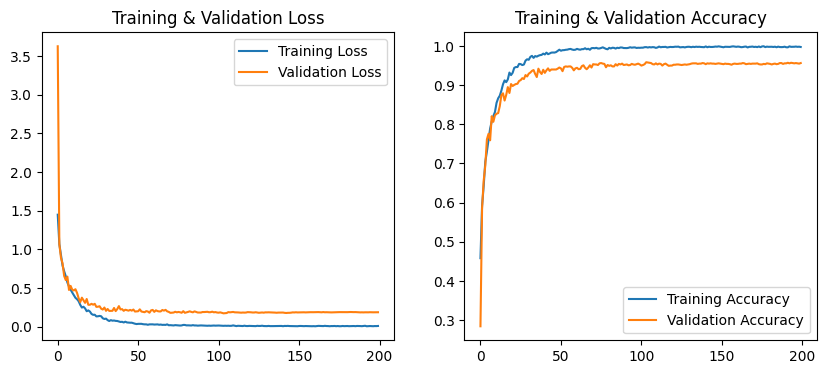



44/44 [==============================] - 0s 2ms/step


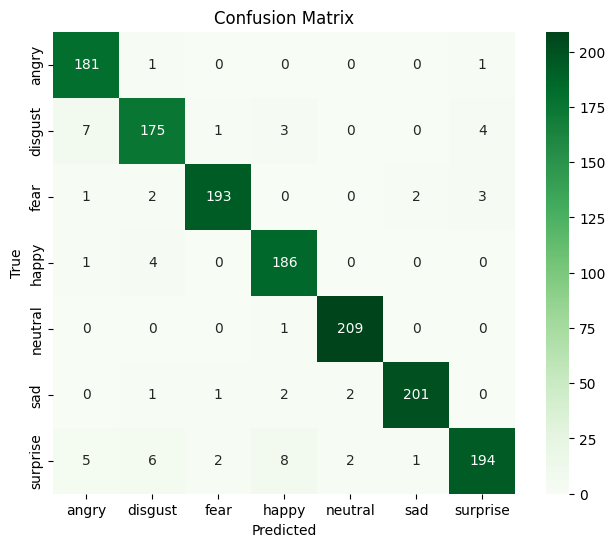



44/44 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

       angry       0.93      0.99      0.96       183
     disgust       0.93      0.92      0.92       190
        fear       0.98      0.96      0.97       201
       happy       0.93      0.97      0.95       191
     neutral       0.98      1.00      0.99       210
         sad       0.99      0.97      0.98       207
    surprise       0.96      0.89      0.92       218

    accuracy                           0.96      1400
   macro avg       0.96      0.96      0.96      1400
weighted avg       0.96      0.96      0.96      1400



44/44 [==============================] - 0s 2ms/step


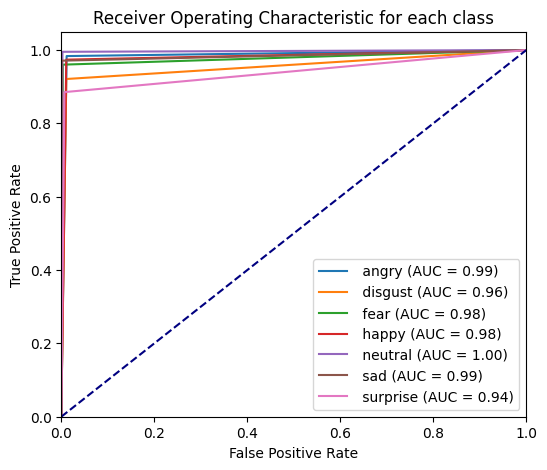

In [ ]:
results()

In [ ]:
model = Sequential()
model.add(Flatten())

model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(7, activation='softmax'))

initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=300, decay_rate=0.9, staircase=True
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test),batch_size=64)

Epoch 1/200
88/88 [==============================] - 9s 19ms/step - loss: 1.4437 - accuracy: 0.4529 - val_loss: 3.2214 - val_accuracy: 0.2729
Epoch 2/200
88/88 [==============================] - 2s 19ms/step - loss: 1.0494 - accuracy: 0.5939 - val_loss: 0.9921 - val_accuracy: 0.6407
Epoch 3/200
88/88 [==============================] - 1s 15ms/step - loss: 0.8894 - accuracy: 0.6573 - val_loss: 0.7507 - val_accuracy: 0.7143
Epoch 4/200
88/88 [==============================] - 1s 16ms/step - loss: 0.7999 - accuracy: 0.6986 - val_loss: 0.7378 - val_accuracy: 0.7364
Epoch 5/200
88/88 [==============================] - 1s 12ms/step - loss: 0.7038 - accuracy: 0.7304 - val_loss: 0.7270 - val_accuracy: 0.7221
Epoch 6/200
88/88 [==============================] - 1s 14ms/step - loss: 0.6243 - accuracy: 0.7729 - val_loss: 0.6055 - val_accuracy: 0.7757
Epoch 7/200
88/88 [==============================] - 1s 13ms/step - loss: 0.5694 - accuracy: 0.7864 - val_loss: 0.4834 - val_accuracy: 0.8279
Epoch 

44/44 [==============================] - 0s 2ms/step
Accuracy: 0.9557142857142857
Precision: 0.9550376423371914
Recall: 0.9560195070061327
F1 Score: 0.95528163977804




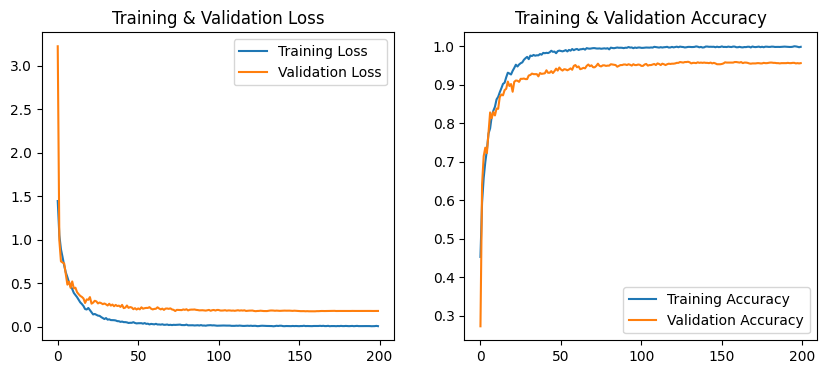



44/44 [==============================] - 0s 2ms/step


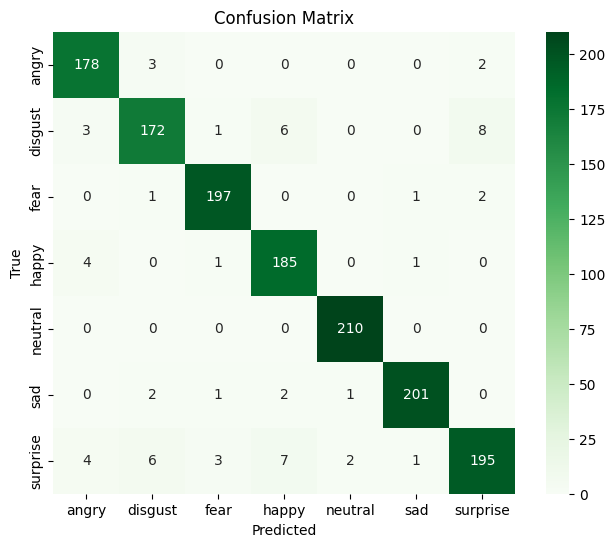



44/44 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

       angry       0.94      0.97      0.96       183
     disgust       0.93      0.91      0.92       190
        fear       0.97      0.98      0.98       201
       happy       0.93      0.97      0.95       191
     neutral       0.99      1.00      0.99       210
         sad       0.99      0.97      0.98       207
    surprise       0.94      0.89      0.92       218

    accuracy                           0.96      1400
   macro avg       0.96      0.96      0.96      1400
weighted avg       0.96      0.96      0.96      1400



44/44 [==============================] - 0s 2ms/step


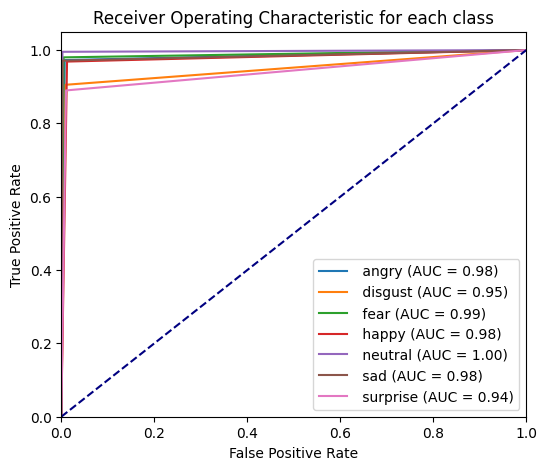

In [ ]:
results()

##**LSTM**

###**60-40**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [ ]:
from keras.layers import LSTM, Dense, Activation, BatchNormalization, Dropout, Flatten, Concatenate
from keras import Input, Model
import tensorflow as tf

inputs = Input(shape=(X_train.shape[1], 1))
lstm_out_1 = LSTM(128, return_sequences=True)(inputs)
lstm_out_1 = Dropout(0.5)(lstm_out_1)
lstm_out_1 = BatchNormalization()(lstm_out_1)

lstm_out_2 = LSTM(128, return_sequences=True)(lstm_out_1)
lstm_out_2 = Dropout(0.5)(lstm_out_2)
lstm_out_2 = BatchNormalization()(lstm_out_2)

context_vector = tf.keras.layers.Attention()([lstm_out_2, lstm_out_2])

flattened = Flatten()(context_vector)

output = Dense(256, activation='relu')(flattened)
output = Dense(128, activation='relu')(output)
output = Dense(64, activation='relu')(output)
output = Dense(7, activation='softmax')(output)

model = Model(inputs=inputs, outputs=output)

initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=300, decay_rate=0.9, staircase=True
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
epochs = 100
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test),batch_size=64)

Epoch 1/200
66/66 [==============================] - 7s 25ms/step - loss: 1.6161 - accuracy: 0.3421 - val_loss: 1.7325 - val_accuracy: 0.2646
Epoch 2/200
66/66 [==============================] - 1s 12ms/step - loss: 1.3721 - accuracy: 0.4543 - val_loss: 1.3761 - val_accuracy: 0.4596
Epoch 3/200
66/66 [==============================] - 1s 12ms/step - loss: 1.2258 - accuracy: 0.5121 - val_loss: 1.2386 - val_accuracy: 0.5050
Epoch 4/200
66/66 [==============================] - 1s 12ms/step - loss: 1.1339 - accuracy: 0.5500 - val_loss: 1.1319 - val_accuracy: 0.5486
Epoch 5/200
66/66 [==============================] - 1s 15ms/step - loss: 1.0336 - accuracy: 0.5914 - val_loss: 0.9985 - val_accuracy: 0.6046
Epoch 6/200
66/66 [==============================] - 1s 17ms/step - loss: 0.9345 - accuracy: 0.6283 - val_loss: 0.9034 - val_accuracy: 0.6582
Epoch 7/200
66/66 [==============================] - 1s 18ms/step - loss: 0.8542 - accuracy: 0.6581 - val_loss: 0.9778 - val_accuracy: 0.6332
Epoch 

88/88 [==============================] - 1s 4ms/step
Accuracy: 0.8714285714285714
Precision: 0.8705710109575886
Recall: 0.8720174029541179
F1 Score: 0.8707128572220968




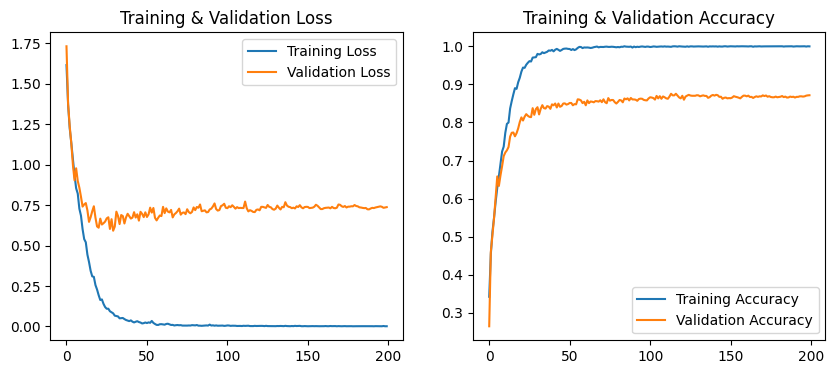



88/88 [==============================] - 0s 4ms/step


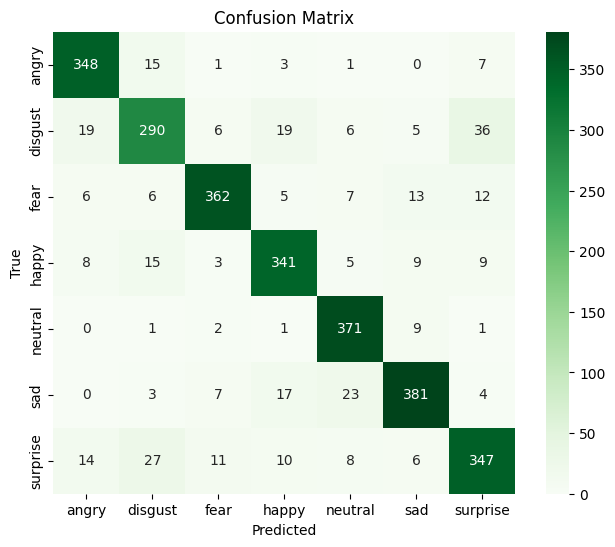



88/88 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

       angry       0.88      0.93      0.90       375
     disgust       0.81      0.76      0.79       381
        fear       0.92      0.88      0.90       411
       happy       0.86      0.87      0.87       390
     neutral       0.88      0.96      0.92       385
         sad       0.90      0.88      0.89       435
    surprise       0.83      0.82      0.83       423

    accuracy                           0.87      2800
   macro avg       0.87      0.87      0.87      2800
weighted avg       0.87      0.87      0.87      2800



88/88 [==============================] - 0s 3ms/step


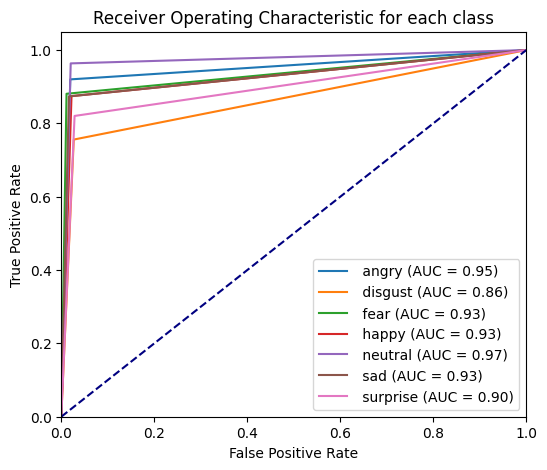

In [ ]:
results()

###**70-30**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
from keras.layers import LSTM, Dense, Activation, BatchNormalization, Dropout, Flatten, Concatenate
from keras import Input, Model
import tensorflow as tf

inputs = Input(shape=(X_train.shape[1], 1))
lstm_out_1 = LSTM(128, return_sequences=True)(inputs)
lstm_out_1 = Dropout(0.5)(lstm_out_1)
lstm_out_1 = BatchNormalization()(lstm_out_1)

lstm_out_2 = LSTM(128, return_sequences=True)(lstm_out_1)
lstm_out_2 = Dropout(0.5)(lstm_out_2)
lstm_out_2 = BatchNormalization()(lstm_out_2)

context_vector = tf.keras.layers.Attention()([lstm_out_2, lstm_out_2])

flattened = Flatten()(context_vector)

output = Dense(256, activation='relu')(flattened)
output = Dense(128, activation='relu')(output)
output = Dense(64, activation='relu')(output)
output = Dense(7, activation='softmax')(output)

model = Model(inputs=inputs, outputs=output)

initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=300, decay_rate=0.9, staircase=True
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
epochs = 100
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test),batch_size=64)

Epoch 1/200
77/77 [==============================] - 7s 21ms/step - loss: 1.5737 - accuracy: 0.3731 - val_loss: 1.6253 - val_accuracy: 0.4357
Epoch 2/200
77/77 [==============================] - 1s 11ms/step - loss: 1.3057 - accuracy: 0.4865 - val_loss: 1.4143 - val_accuracy: 0.4438
Epoch 3/200
77/77 [==============================] - 1s 12ms/step - loss: 1.1776 - accuracy: 0.5400 - val_loss: 1.1895 - val_accuracy: 0.5352
Epoch 4/200
77/77 [==============================] - 1s 11ms/step - loss: 1.0578 - accuracy: 0.5851 - val_loss: 1.0202 - val_accuracy: 0.6190
Epoch 5/200
77/77 [==============================] - 1s 11ms/step - loss: 0.9752 - accuracy: 0.6163 - val_loss: 0.9863 - val_accuracy: 0.6124
Epoch 6/200
77/77 [==============================] - 1s 11ms/step - loss: 0.8825 - accuracy: 0.6555 - val_loss: 1.1813 - val_accuracy: 0.5695
Epoch 7/200
77/77 [==============================] - 1s 11ms/step - loss: 0.8164 - accuracy: 0.6857 - val_loss: 0.8898 - val_accuracy: 0.6790
Epoch 

66/66 [==============================] - 1s 3ms/step
Accuracy: 0.9019047619047619
Precision: 0.9015790396104165
Recall: 0.9022508214822998
F1 Score: 0.901585025363171




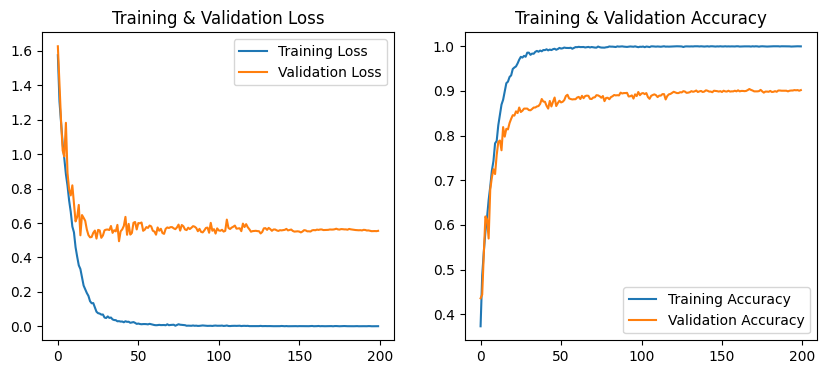



66/66 [==============================] - 0s 3ms/step


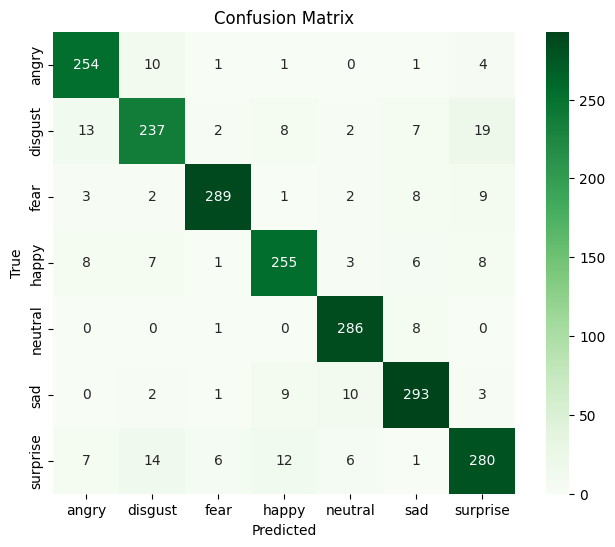



66/66 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

       angry       0.89      0.94      0.91       271
     disgust       0.87      0.82      0.85       288
        fear       0.96      0.92      0.94       314
       happy       0.89      0.89      0.89       288
     neutral       0.93      0.97      0.95       295
         sad       0.90      0.92      0.91       318
    surprise       0.87      0.86      0.86       326

    accuracy                           0.90      2100
   macro avg       0.90      0.90      0.90      2100
weighted avg       0.90      0.90      0.90      2100



66/66 [==============================] - 0s 4ms/step


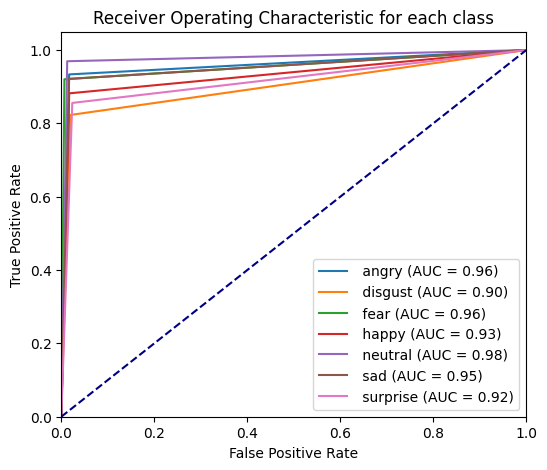

In [ ]:
results()

###**80-20**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

####**Highest Acc of LSTM**

In [ ]:
from keras.layers import LSTM, Dense, Activation, BatchNormalization, Dropout, Flatten, Concatenate
from keras import Input, Model
import tensorflow as tf

inputs = Input(shape=(X_train.shape[1], 1))
lstm_out_1 = LSTM(128, return_sequences=True)(inputs)
lstm_out_1 = Dropout(0.5)(lstm_out_1)
lstm_out_1 = BatchNormalization()(lstm_out_1)

lstm_out_2 = LSTM(128, return_sequences=True)(lstm_out_1)
lstm_out_2 = Dropout(0.5)(lstm_out_2)
lstm_out_2 = BatchNormalization()(lstm_out_2)

context_vector = tf.keras.layers.Attention()([lstm_out_2, lstm_out_2])

flattened = Flatten()(context_vector)

output = Dense(256, activation='relu')(flattened)
output = Dense(128, activation='relu')(output)
output = Dense(64, activation='relu')(output)
output = Dense(7, activation='softmax')(output)

model = Model(inputs=inputs, outputs=output)

initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=300, decay_rate=0.9, staircase=True
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
epochs = 100
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test),batch_size=64)

Epoch 1/200
88/88 [==============================] - 7s 23ms/step - loss: 1.5352 - accuracy: 0.3973 - val_loss: 1.5769 - val_accuracy: 0.4043
Epoch 2/200
88/88 [==============================] - 1s 16ms/step - loss: 1.2786 - accuracy: 0.4932 - val_loss: 1.3123 - val_accuracy: 0.4850
Epoch 3/200
88/88 [==============================] - 1s 16ms/step - loss: 1.1258 - accuracy: 0.5487 - val_loss: 1.0879 - val_accuracy: 0.5886
Epoch 4/200
88/88 [==============================] - 2s 21ms/step - loss: 1.0465 - accuracy: 0.5807 - val_loss: 1.0238 - val_accuracy: 0.6021
Epoch 5/200
88/88 [==============================] - 2s 18ms/step - loss: 0.9180 - accuracy: 0.6363 - val_loss: 1.0026 - val_accuracy: 0.6207
Epoch 6/200
88/88 [==============================] - 2s 18ms/step - loss: 0.8502 - accuracy: 0.6737 - val_loss: 0.8733 - val_accuracy: 0.6821
Epoch 7/200
88/88 [==============================] - 1s 15ms/step - loss: 0.7608 - accuracy: 0.7046 - val_loss: 0.7997 - val_accuracy: 0.6957
Epoch 

44/44 [==============================] - 4s 7ms/step
Accuracy: 0.9085714285714286
Precision: 0.9084645171751958
Recall: 0.9091577767924136
F1 Score: 0.9085484693830705




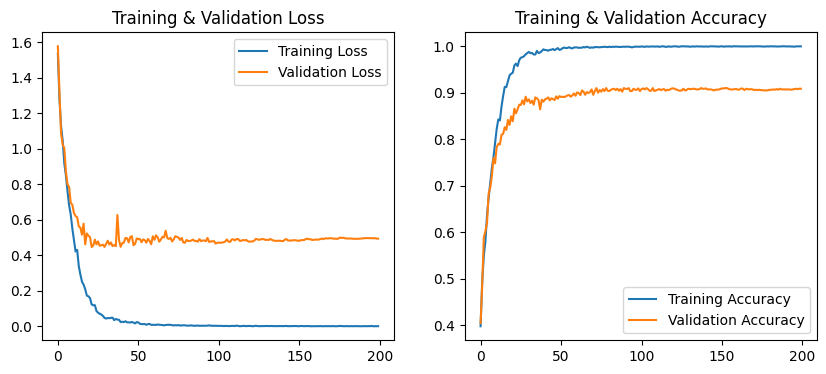



44/44 [==============================] - 0s 6ms/step


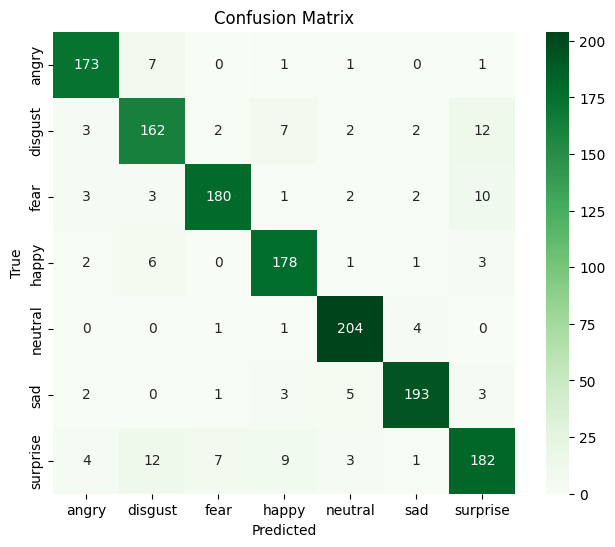



44/44 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

       angry       0.93      0.95      0.94       183
     disgust       0.85      0.85      0.85       190
        fear       0.94      0.90      0.92       201
       happy       0.89      0.93      0.91       191
     neutral       0.94      0.97      0.95       210
         sad       0.95      0.93      0.94       207
    surprise       0.86      0.83      0.85       218

    accuracy                           0.91      1400
   macro avg       0.91      0.91      0.91      1400
weighted avg       0.91      0.91      0.91      1400



44/44 [==============================] - 0s 7ms/step


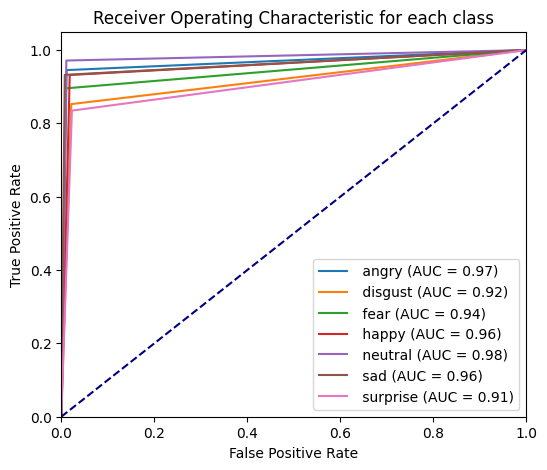

In [ ]:
results()

##**Machine Learning**

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Thesis/Audio/features.csv')

In [ ]:
df

feature1   feature2   feature3   feature4   feature5   feature6  \
0     -81.51889  60.381310  -8.750255  37.333330  19.925490 -10.303067   
1    -205.81566  98.912575  -7.838481   6.259947   3.377407  -7.288666   
2    -287.47890  69.791650  11.438355  36.551910  -3.720656  -9.046013   
3    -282.20800  92.042310  -2.016865  38.696430  -3.255724 -18.861254   
4    -261.79025  44.257940   3.655003  39.999336   0.309264 -22.350810   
...         ...        ...        ...        ...        ...        ...   
6995  -92.42775  60.818590 -15.947881  14.417720  -8.106504  -3.438355   
6996 -164.59933  54.725655  11.676369  21.254402  10.308422  -3.832710   
6997 -164.36948  70.324860  -4.080932  24.548504   1.531596  -5.048026   
6998  -65.59468  41.872690  -8.251931  11.704505  -3.161511  -4.947111   
6999 -216.51003  65.851720   4.883995  31.837143   3.786554 -24.132906   

       feature7   feature8   feature9  feature10  ...  feature32  feature33  \
0     -8.078856  11.806390 -12.251641  -9.557299  ...   2.269923  -2.918496   
1     -6.208662  -3.598792 -15.433932   1.999314  ...   3.266270  -3.967942   
2     -8.148148  -7.686802 -31.929403  -2.355287  ...   1.185361  -3.760918   
3    -19.376840 -14.277868 -30.191656  13.522091  ...   7.014323  -1.536536   
4     -0.745244   1.425302 -30.098612  -1.265044  ...  -1.382179  -5.096261   
...         ...        ...        ...        ...  ...        ...        ...   
6995  -1.483631  -5.615319 -13.796732  -6.261109  ...   5.875216  -1.365492   
6996  -7.717126   7.598620 -22.075872  -5.891316  ...   6.992015  -1.351654   
6997  -9.318872  -3.707200 -20.170390  -3.279395  ...   6.261546   2.346918   
6998 -12.737878   1.003236 -17.917645  -2.085602  ...   1.794857  -1.731647   
6999   1.848336  -7.126493 -23.954058  -9.383267  ...   5.744874  -0.259267   

      feature34  feature35  feature36  feature37  feature38  feature39  \
0      1.661691  -2.392677   0.765987   0.609252   2.679197  -3.179437   
1      1.459997  -0.202032   3.404291   1.739866   1.452109   1.015928   
2      2.753493   1.658616   0.056745  -0.099750  -2.579343   0.366117   
3      3.676686   1.445685   4.275633   3.213146   2.418258  -0.914322   
4      1.846607  -0.828133   1.176946   0.869583   3.332840   1.513070   
...         ...        ...        ...        ...        ...        ...   
6995   3.917298   0.774234   2.306461  -2.097592  -0.199551  -0.280677   
6996   5.403003  -1.120681  -0.282716  -2.232190   1.705995   0.806300   
6997   5.425534   0.477858   1.261319  -1.055698  -0.280947  -0.090864   
6998   5.709963   1.341387   4.011292   0.930854   6.010147   1.664747   
6999   6.506476   1.436526   2.882405  -1.014756   2.682735   0.376299   

      feature40  label  
0      0.425090      0  
1      1.012675      4  
2      0.272857      4  
3     -0.770554      4  
4      0.696034      2  
...         ...    ...  
6995   2.323187      6  
6996   0.698475      6  
6997   0.671015      6  
6998   2.061325      0  
6999   2.505656      3  

[7000 rows x 41 columns]

In [ ]:
X = df.drop(columns = 'label')
y = df['label']

In [ ]:
X

feature1   feature2   feature3   feature4   feature5   feature6  \
0     -81.51889  60.381310  -8.750255  37.333330  19.925490 -10.303067   
1    -205.81566  98.912575  -7.838481   6.259947   3.377407  -7.288666   
2    -287.47890  69.791650  11.438355  36.551910  -3.720656  -9.046013   
3    -282.20800  92.042310  -2.016865  38.696430  -3.255724 -18.861254   
4    -261.79025  44.257940   3.655003  39.999336   0.309264 -22.350810   
...         ...        ...        ...        ...        ...        ...   
6995  -92.42775  60.818590 -15.947881  14.417720  -8.106504  -3.438355   
6996 -164.59933  54.725655  11.676369  21.254402  10.308422  -3.832710   
6997 -164.36948  70.324860  -4.080932  24.548504   1.531596  -5.048026   
6998  -65.59468  41.872690  -8.251931  11.704505  -3.161511  -4.947111   
6999 -216.51003  65.851720   4.883995  31.837143   3.786554 -24.132906   

       feature7   feature8   feature9  feature10  ...  feature31  feature32  \
0     -8.078856  11.806390 -12.251641  -9.557299  ...  -0.470436   2.269923   
1     -6.208662  -3.598792 -15.433932   1.999314  ...  -0.924364   3.266270   
2     -8.148148  -7.686802 -31.929403  -2.355287  ...   0.189997   1.185361   
3    -19.376840 -14.277868 -30.191656  13.522091  ...   2.709023   7.014323   
4     -0.745244   1.425302 -30.098612  -1.265044  ...  -6.712309  -1.382179   
...         ...        ...        ...        ...  ...        ...        ...   
6995  -1.483631  -5.615319 -13.796732  -6.261109  ...   3.427436   5.875216   
6996  -7.717126   7.598620 -22.075872  -5.891316  ...   2.826179   6.992015   
6997  -9.318872  -3.707200 -20.170390  -3.279395  ...  -2.388400   6.261546   
6998 -12.737878   1.003236 -17.917645  -2.085602  ...  -1.741748   1.794857   
6999   1.848336  -7.126493 -23.954058  -9.383267  ...   1.991004   5.744874   

      feature33  feature34  feature35  feature36  feature37  feature38  \
0     -2.918496   1.661691  -2.392677   0.765987   0.609252   2.679197   
1     -3.967942   1.459997  -0.202032   3.404291   1.739866   1.452109   
2     -3.760918   2.753493   1.658616   0.056745  -0.099750  -2.579343   
3     -1.536536   3.676686   1.445685   4.275633   3.213146   2.418258   
4     -5.096261   1.846607  -0.828133   1.176946   0.869583   3.332840   
...         ...        ...        ...        ...        ...        ...   
6995  -1.365492   3.917298   0.774234   2.306461  -2.097592  -0.199551   
6996  -1.351654   5.403003  -1.120681  -0.282716  -2.232190   1.705995   
6997   2.346918   5.425534   0.477858   1.261319  -1.055698  -0.280947   
6998  -1.731647   5.709963   1.341387   4.011292   0.930854   6.010147   
6999  -0.259267   6.506476   1.436526   2.882405  -1.014756   2.682735   

      feature39  feature40  
0     -3.179437   0.425090  
1      1.015928   1.012675  
2      0.366117   0.272857  
3     -0.914322  -0.770554  
4      1.513070   0.696034  
...         ...        ...  
6995  -0.280677   2.323187  
6996   0.806300   0.698475  
6997  -0.090864   0.671015  
6998   1.664747   2.061325  
6999   0.376299   2.505656  

[7000 rows x 40 columns]

In [ ]:
y

0       0
1       4
2       4
3       4
4       2
       ..
6995    6
6996    6
6997    6
6998    0
6999    3
Name: label, Length: 7000, dtype: int64

###**60-40**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

Training Decision Tree...
Evaluating Decision Tree...
Accuracy: 0.5421428571428571
Precision: 0.5408953822081941
Recall: 0.5429433407588068
F1 Score: 0.5414925591157339


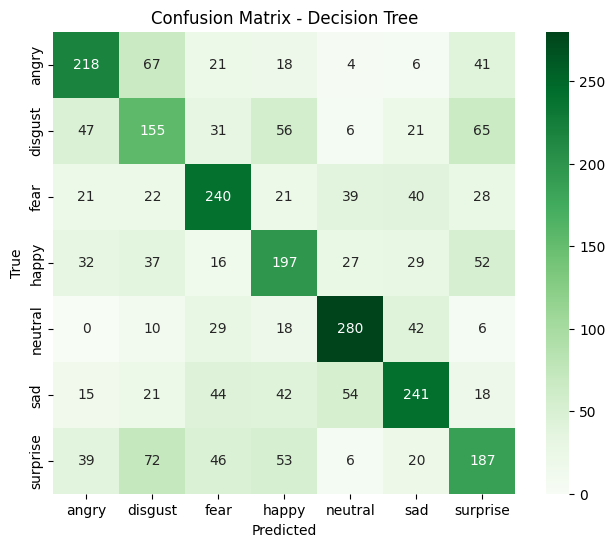

Classification Report:
              precision    recall  f1-score   support

       angry       0.59      0.58      0.58       375
     disgust       0.40      0.41      0.41       381
        fear       0.56      0.58      0.57       411
       happy       0.49      0.51      0.50       390
     neutral       0.67      0.73      0.70       385
         sad       0.60      0.55      0.58       435
    surprise       0.47      0.44      0.46       423

    accuracy                           0.54      2800
   macro avg       0.54      0.54      0.54      2800
weighted avg       0.54      0.54      0.54      2800



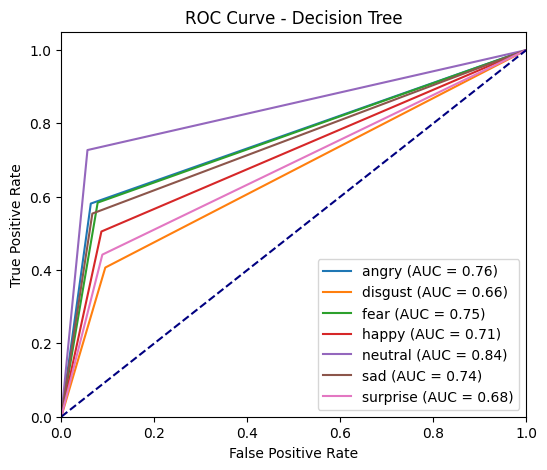




Training K-Nearest Neighbors...
Evaluating K-Nearest Neighbors...
Accuracy: 0.7921428571428571
Precision: 0.8076131123801948
Recall: 0.7969424251532595
F1 Score: 0.7901825729031627


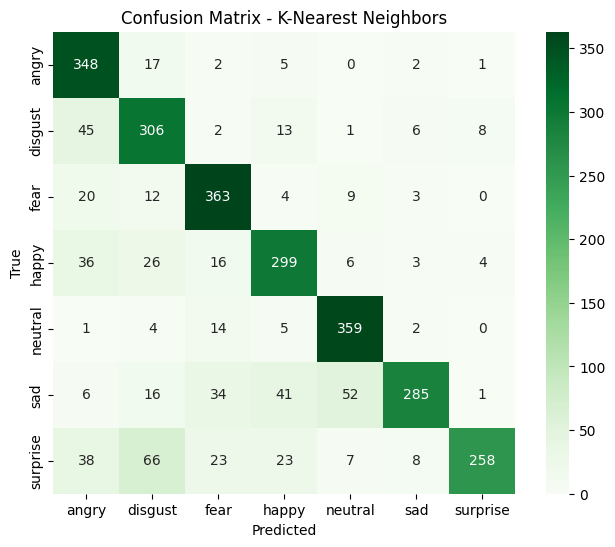

Classification Report:
              precision    recall  f1-score   support

       angry       0.70      0.93      0.80       375
     disgust       0.68      0.80      0.74       381
        fear       0.80      0.88      0.84       411
       happy       0.77      0.77      0.77       390
     neutral       0.83      0.93      0.88       385
         sad       0.92      0.66      0.77       435
    surprise       0.95      0.61      0.74       423

    accuracy                           0.79      2800
   macro avg       0.81      0.80      0.79      2800
weighted avg       0.81      0.79      0.79      2800



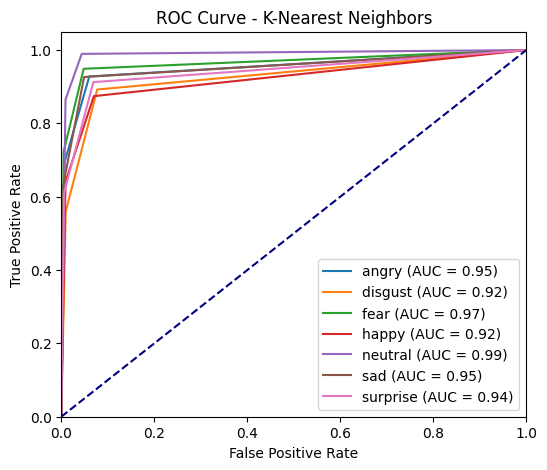




Training Random Forest...
Evaluating Random Forest...
Accuracy: 0.8325
Precision: 0.8332825796820186
Recall: 0.8339958032910193
F1 Score: 0.8312323302202724


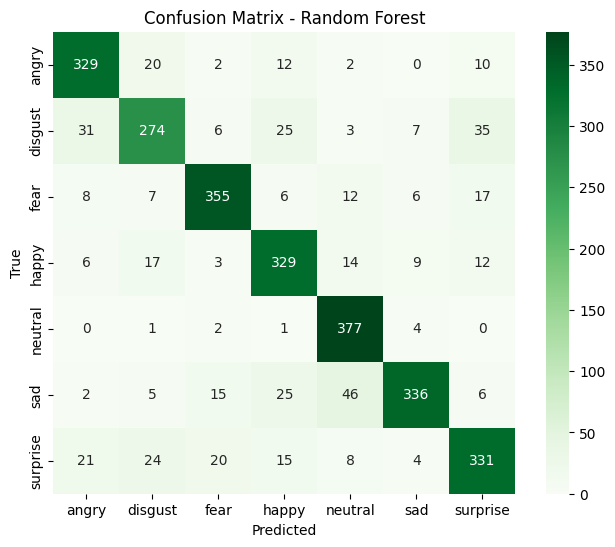

Classification Report:
              precision    recall  f1-score   support

       angry       0.83      0.88      0.85       375
     disgust       0.79      0.72      0.75       381
        fear       0.88      0.86      0.87       411
       happy       0.80      0.84      0.82       390
     neutral       0.82      0.98      0.89       385
         sad       0.92      0.77      0.84       435
    surprise       0.81      0.78      0.79       423

    accuracy                           0.83      2800
   macro avg       0.83      0.83      0.83      2800
weighted avg       0.83      0.83      0.83      2800



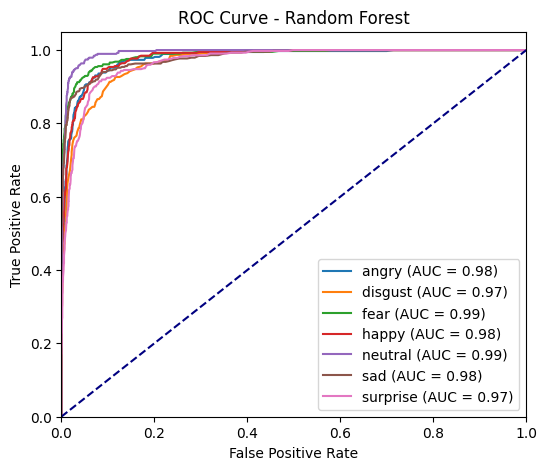




Training Multi-Layer Perceptron...
Evaluating Multi-Layer Perceptron...
Accuracy: 0.85
Precision: 0.8504962256892673
Recall: 0.8495177883250374
F1 Score: 0.8491731044714595


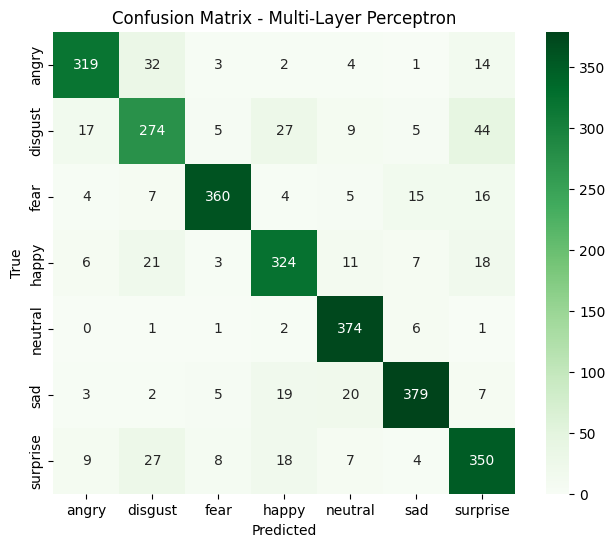

Classification Report:
              precision    recall  f1-score   support

       angry       0.89      0.85      0.87       375
     disgust       0.75      0.72      0.74       381
        fear       0.94      0.88      0.90       411
       happy       0.82      0.83      0.82       390
     neutral       0.87      0.97      0.92       385
         sad       0.91      0.87      0.89       435
    surprise       0.78      0.83      0.80       423

    accuracy                           0.85      2800
   macro avg       0.85      0.85      0.85      2800
weighted avg       0.85      0.85      0.85      2800



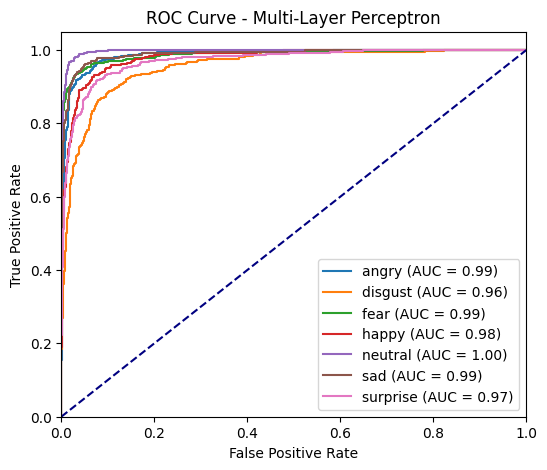




Training Support Vector Machine...
Evaluating Support Vector Machine...
Accuracy: 0.5139285714285714
Precision: 0.5136199427740827
Recall: 0.5199547468671023
F1 Score: 0.4940536650737414


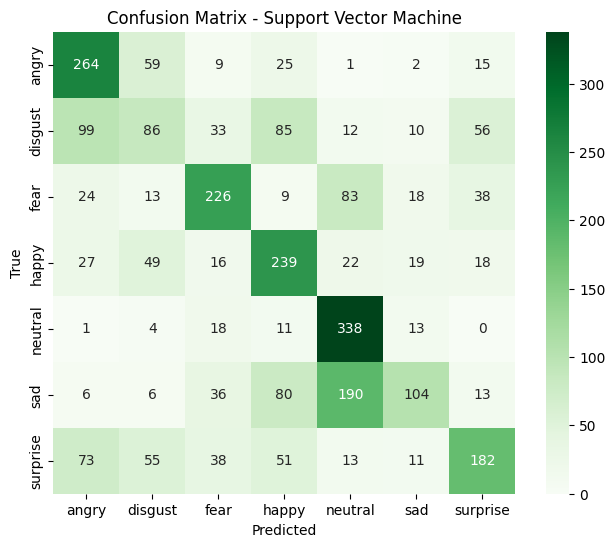

Classification Report:
              precision    recall  f1-score   support

       angry       0.53      0.70      0.61       375
     disgust       0.32      0.23      0.26       381
        fear       0.60      0.55      0.57       411
       happy       0.48      0.61      0.54       390
     neutral       0.51      0.88      0.65       385
         sad       0.59      0.24      0.34       435
    surprise       0.57      0.43      0.49       423

    accuracy                           0.51      2800
   macro avg       0.51      0.52      0.49      2800
weighted avg       0.52      0.51      0.49      2800



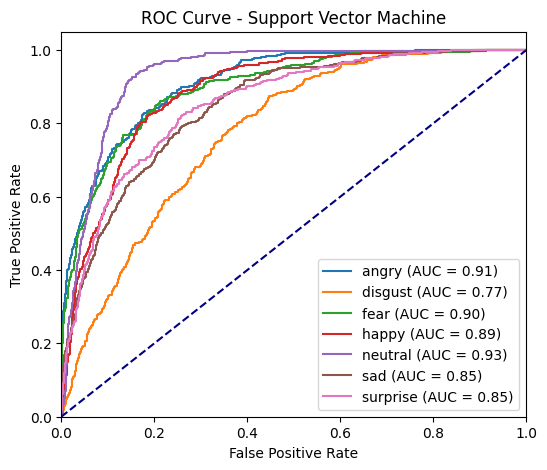

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

def model_comparison(X_train, y_train, X_test, y_test, emotions):
    models = {
        "Decision Tree": DecisionTreeClassifier(),
        "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=2),
        "Random Forest": RandomForestClassifier(n_estimators = 500),
        "Multi-Layer Perceptron": MLPClassifier(alpha=0.01, batch_size=270, epsilon=1e-08, hidden_layer_sizes=(400,), learning_rate='adaptive', max_iter=400),
        "Support Vector Machine": SVC(probability = True)
    }

    for name, model in models.items():
        print(f"Training {name}...")
        model.fit(X_train, y_train)

        print(f"Evaluating {name}...")
        y_pred = model.predict(X_test)

        print("Accuracy:", accuracy_score(y_test, y_pred))
        print("Precision:", precision_score(y_test, y_pred, average='macro'))
        print("Recall:", recall_score(y_test, y_pred, average='macro'))
        print("F1 Score:", f1_score(y_test, y_pred, average='macro'))

        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, cmap='Greens', fmt='d', square=True, xticklabels=np.unique(emotions), yticklabels=np.unique(emotions))
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'Confusion Matrix - {name}')
        plt.show()

        # Classification report
        print("Classification Report:")
        print(classification_report(y_test, y_pred, target_names=np.unique(emotions)))

        # ROC curve
        y_pred_proba = model.predict_proba(X_test)
        n_classes = len(np.unique(y_test))
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve((y_test == i).astype(int), y_pred_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        plt.figure(figsize=(6, 5))
        for i in range(n_classes):
            plt.plot(fpr[i], tpr[i], label=f'{emotions[i]} (AUC = {roc_auc[i]:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {name}')
        plt.legend(loc="lower right")
        plt.show()

        print("\n\n")

model_comparison(X_train, y_train, X_test, y_test, emotions)

###**70-30**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Training Decision Tree...
Evaluating Decision Tree...
Accuracy: 0.5728571428571428
Precision: 0.5714158746856632
Recall: 0.5741531807342113
F1 Score: 0.5720273466550803


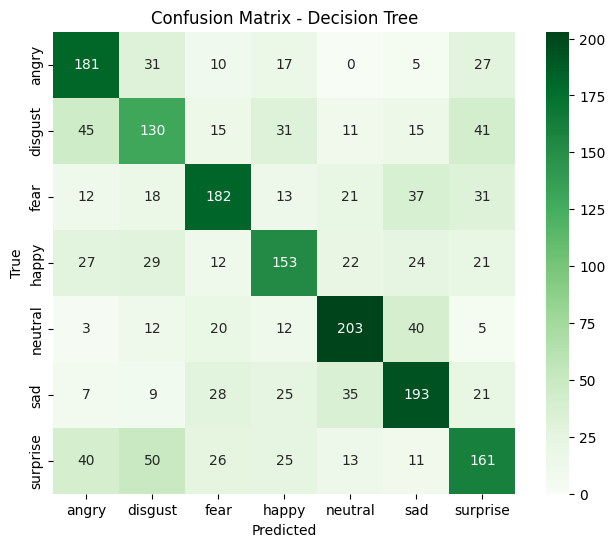

Classification Report:
              precision    recall  f1-score   support

       angry       0.57      0.67      0.62       271
     disgust       0.47      0.45      0.46       288
        fear       0.62      0.58      0.60       314
       happy       0.55      0.53      0.54       288
     neutral       0.67      0.69      0.68       295
         sad       0.59      0.61      0.60       318
    surprise       0.52      0.49      0.51       326

    accuracy                           0.57      2100
   macro avg       0.57      0.57      0.57      2100
weighted avg       0.57      0.57      0.57      2100



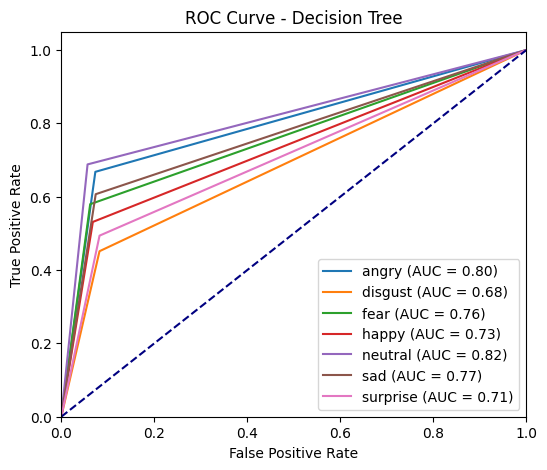




Training K-Nearest Neighbors...
Evaluating K-Nearest Neighbors...
Accuracy: 0.8295238095238096
Precision: 0.8406039953760087
Recall: 0.8336622095967854
F1 Score: 0.8285927455445056


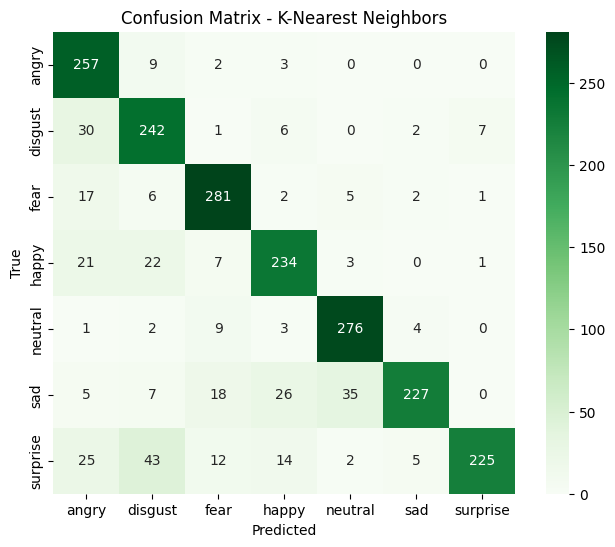

Classification Report:
              precision    recall  f1-score   support

       angry       0.72      0.95      0.82       271
     disgust       0.73      0.84      0.78       288
        fear       0.85      0.89      0.87       314
       happy       0.81      0.81      0.81       288
     neutral       0.86      0.94      0.90       295
         sad       0.95      0.71      0.81       318
    surprise       0.96      0.69      0.80       326

    accuracy                           0.83      2100
   macro avg       0.84      0.83      0.83      2100
weighted avg       0.85      0.83      0.83      2100



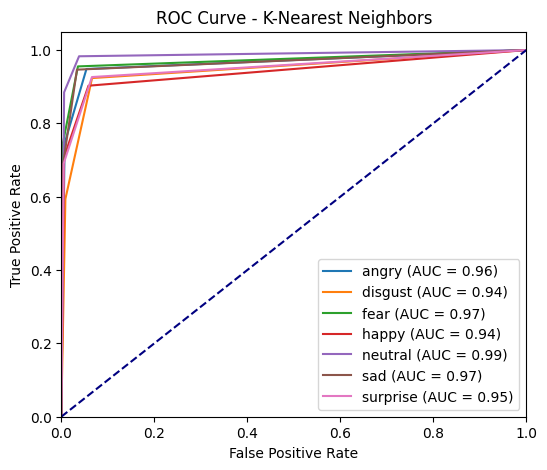




Training Random Forest...
Evaluating Random Forest...
Accuracy: 0.85
Precision: 0.8503520408251133
Recall: 0.8514810512061338
F1 Score: 0.8493442870763974


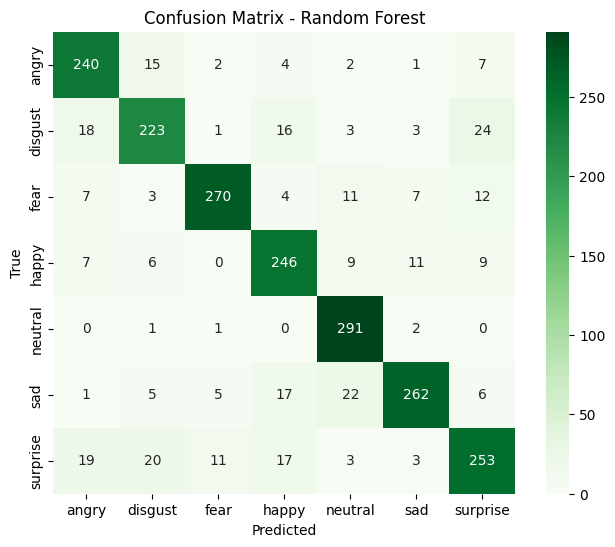

Classification Report:
              precision    recall  f1-score   support

       angry       0.82      0.89      0.85       271
     disgust       0.82      0.77      0.80       288
        fear       0.93      0.86      0.89       314
       happy       0.81      0.85      0.83       288
     neutral       0.85      0.99      0.92       295
         sad       0.91      0.82      0.86       318
    surprise       0.81      0.78      0.79       326

    accuracy                           0.85      2100
   macro avg       0.85      0.85      0.85      2100
weighted avg       0.85      0.85      0.85      2100



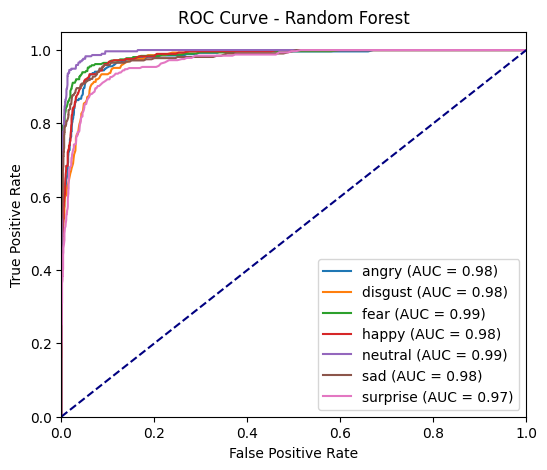




Training Multi-Layer Perceptron...
Evaluating Multi-Layer Perceptron...
Accuracy: 0.8442857142857143
Precision: 0.8443503920215931
Recall: 0.8457209870326193
F1 Score: 0.8421840314263164


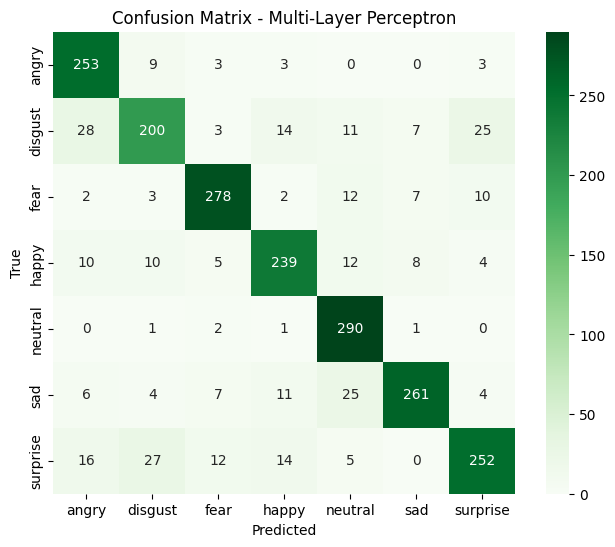

Classification Report:
              precision    recall  f1-score   support

       angry       0.80      0.93      0.86       271
     disgust       0.79      0.69      0.74       288
        fear       0.90      0.89      0.89       314
       happy       0.84      0.83      0.84       288
     neutral       0.82      0.98      0.89       295
         sad       0.92      0.82      0.87       318
    surprise       0.85      0.77      0.81       326

    accuracy                           0.84      2100
   macro avg       0.84      0.85      0.84      2100
weighted avg       0.85      0.84      0.84      2100



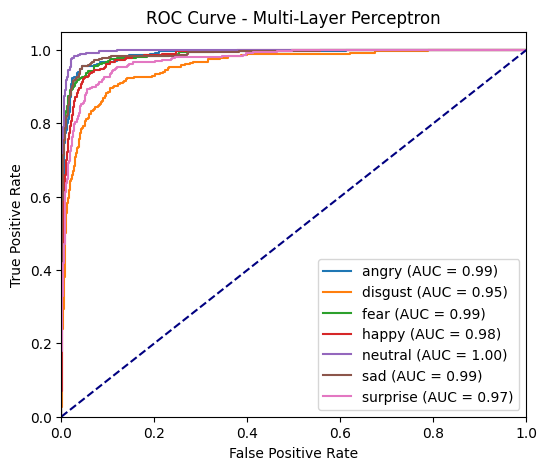




Training Support Vector Machine...
Evaluating Support Vector Machine...
Accuracy: 0.5295238095238095
Precision: 0.5262388910877451
Recall: 0.5343500871328868
F1 Score: 0.5121772422541142


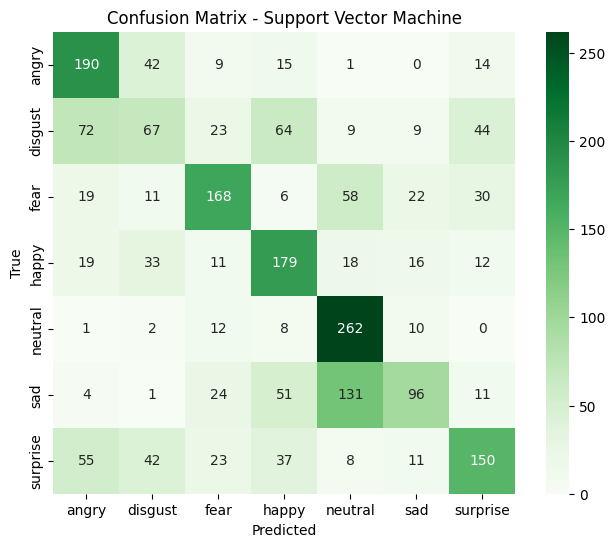

Classification Report:
              precision    recall  f1-score   support

       angry       0.53      0.70      0.60       271
     disgust       0.34      0.23      0.28       288
        fear       0.62      0.54      0.58       314
       happy       0.50      0.62      0.55       288
     neutral       0.54      0.89      0.67       295
         sad       0.59      0.30      0.40       318
    surprise       0.57      0.46      0.51       326

    accuracy                           0.53      2100
   macro avg       0.53      0.53      0.51      2100
weighted avg       0.53      0.53      0.51      2100



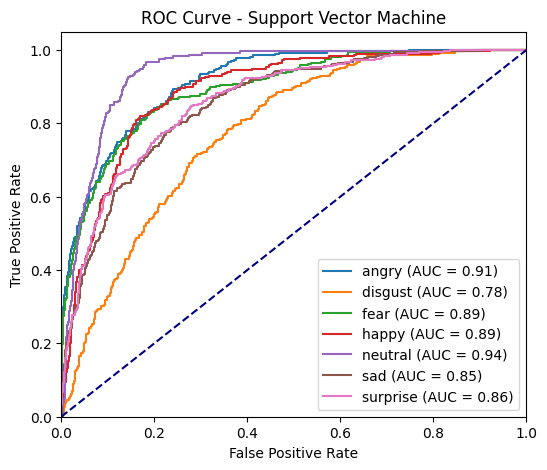

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

def model_comparison(X_train, y_train, X_test, y_test, emotions):
    models = {
        "Decision Tree": DecisionTreeClassifier(),
        "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=2),
        "Random Forest": RandomForestClassifier(n_estimators = 500),
        "Multi-Layer Perceptron": MLPClassifier(alpha=0.01, batch_size=270, epsilon=1e-08, hidden_layer_sizes=(400,), learning_rate='adaptive', max_iter=400),
        "Support Vector Machine": SVC(probability = True)
    }

    for name, model in models.items():
        print(f"Training {name}...")
        model.fit(X_train, y_train)

        print(f"Evaluating {name}...")
        y_pred = model.predict(X_test)

        print("Accuracy:", accuracy_score(y_test, y_pred))
        print("Precision:", precision_score(y_test, y_pred, average='macro'))
        print("Recall:", recall_score(y_test, y_pred, average='macro'))
        print("F1 Score:", f1_score(y_test, y_pred, average='macro'))

        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, cmap='Greens', fmt='d', square=True, xticklabels=np.unique(emotions), yticklabels=np.unique(emotions))
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'Confusion Matrix - {name}')
        plt.show()

        # Classification report
        print("Classification Report:")
        print(classification_report(y_test, y_pred, target_names=np.unique(emotions)))

        # ROC curve
        y_pred_proba = model.predict_proba(X_test)
        n_classes = len(np.unique(y_test))
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve((y_test == i).astype(int), y_pred_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        plt.figure(figsize=(6, 5))
        for i in range(n_classes):
            plt.plot(fpr[i], tpr[i], label=f'{emotions[i]} (AUC = {roc_auc[i]:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {name}')
        plt.legend(loc="lower right")
        plt.show()

        print("\n\n")

model_comparison(X_train, y_train, X_test, y_test, emotions)

###**80-20**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Training Decision Tree...
Evaluating Decision Tree...
Accuracy: 0.6
Precision: 0.5995357345901285
Recall: 0.6010118767241793
F1 Score: 0.5981973636495445


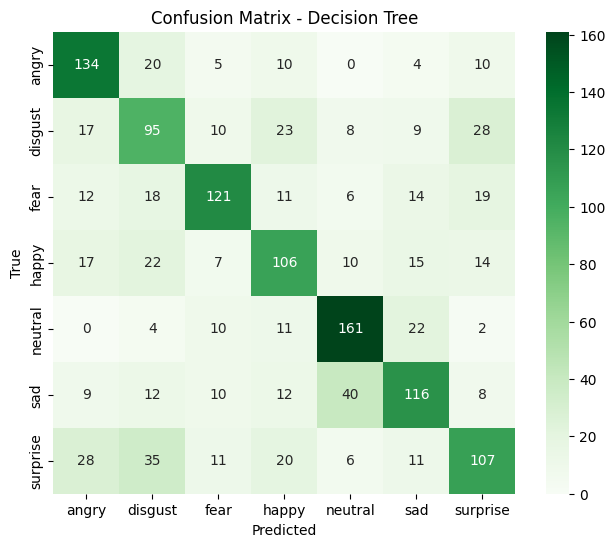

Classification Report:
              precision    recall  f1-score   support

       angry       0.62      0.73      0.67       183
     disgust       0.46      0.50      0.48       190
        fear       0.70      0.60      0.65       201
       happy       0.55      0.55      0.55       191
     neutral       0.70      0.77      0.73       210
         sad       0.61      0.56      0.58       207
    surprise       0.57      0.49      0.53       218

    accuracy                           0.60      1400
   macro avg       0.60      0.60      0.60      1400
weighted avg       0.60      0.60      0.60      1400



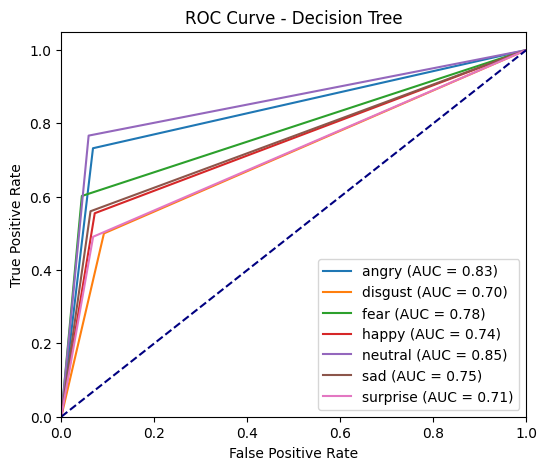




Training K-Nearest Neighbors...
Evaluating K-Nearest Neighbors...
Accuracy: 0.8471428571428572
Precision: 0.8554963326751149
Recall: 0.8498208685373115
F1 Score: 0.8461734578987599


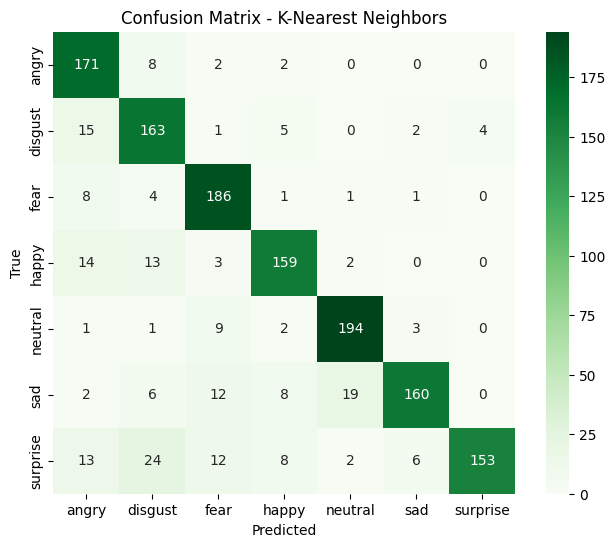

Classification Report:
              precision    recall  f1-score   support

       angry       0.76      0.93      0.84       183
     disgust       0.74      0.86      0.80       190
        fear       0.83      0.93      0.87       201
       happy       0.86      0.83      0.85       191
     neutral       0.89      0.92      0.91       210
         sad       0.93      0.77      0.84       207
    surprise       0.97      0.70      0.82       218

    accuracy                           0.85      1400
   macro avg       0.86      0.85      0.85      1400
weighted avg       0.86      0.85      0.85      1400



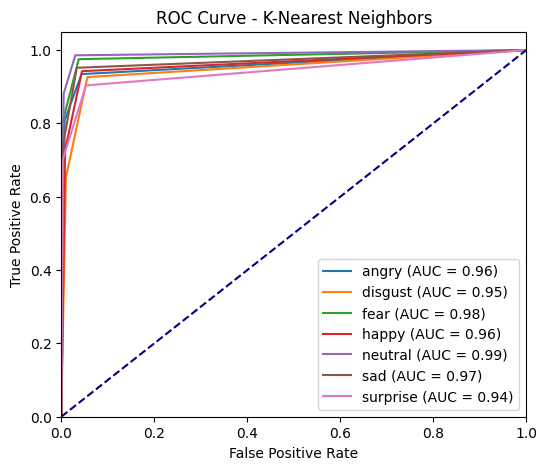




Training Random Forest...
Evaluating Random Forest...
Accuracy: 0.8592857142857143
Precision: 0.8590863945470595
Recall: 0.8595004054299603
F1 Score: 0.8579710956752684


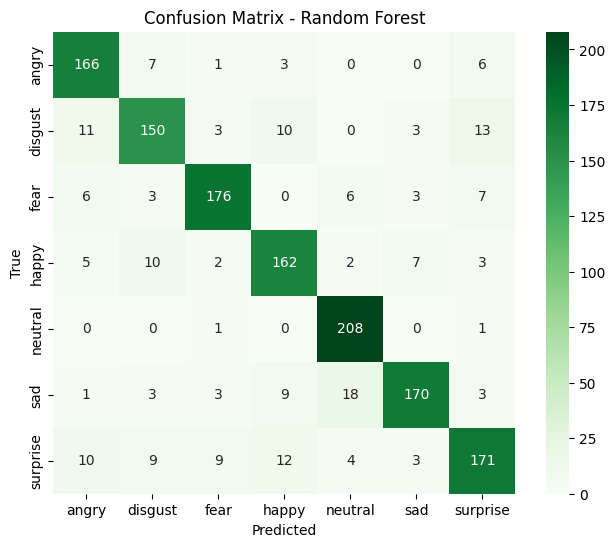

Classification Report:
              precision    recall  f1-score   support

       angry       0.83      0.91      0.87       183
     disgust       0.82      0.79      0.81       190
        fear       0.90      0.88      0.89       201
       happy       0.83      0.85      0.84       191
     neutral       0.87      0.99      0.93       210
         sad       0.91      0.82      0.87       207
    surprise       0.84      0.78      0.81       218

    accuracy                           0.86      1400
   macro avg       0.86      0.86      0.86      1400
weighted avg       0.86      0.86      0.86      1400



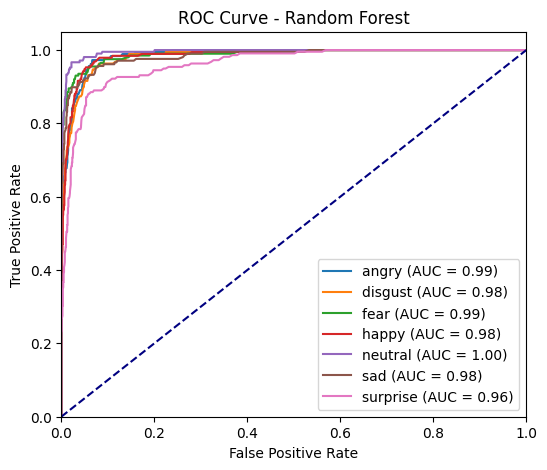




Training Multi-Layer Perceptron...
Evaluating Multi-Layer Perceptron...
Accuracy: 0.8792857142857143
Precision: 0.8786915021919613
Recall: 0.8795423805850702
F1 Score: 0.8786470896744003


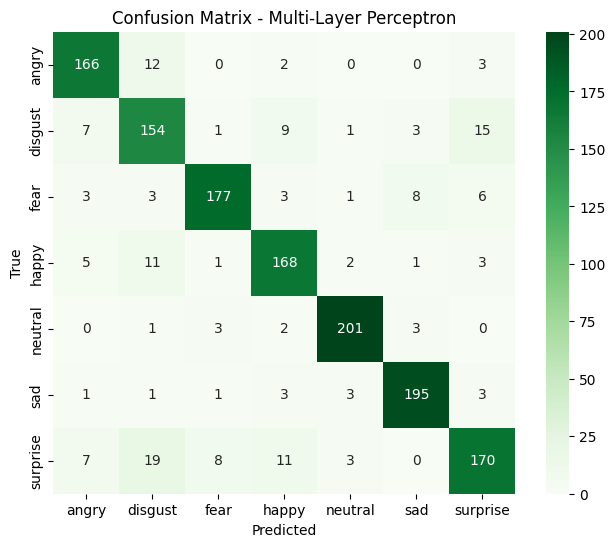

Classification Report:
              precision    recall  f1-score   support

       angry       0.88      0.91      0.89       183
     disgust       0.77      0.81      0.79       190
        fear       0.93      0.88      0.90       201
       happy       0.85      0.88      0.86       191
     neutral       0.95      0.96      0.95       210
         sad       0.93      0.94      0.94       207
    surprise       0.85      0.78      0.81       218

    accuracy                           0.88      1400
   macro avg       0.88      0.88      0.88      1400
weighted avg       0.88      0.88      0.88      1400



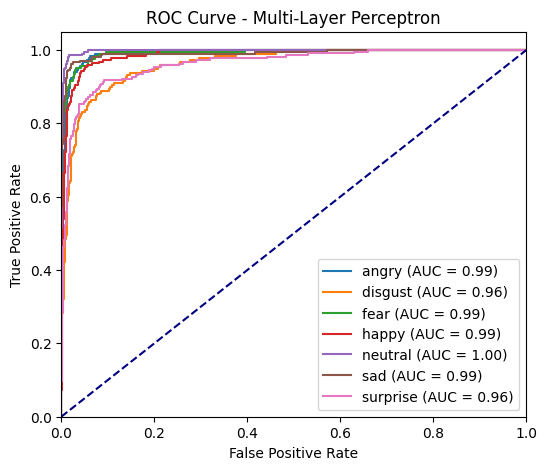




Training Support Vector Machine...
Evaluating Support Vector Machine...
Accuracy: 0.5471428571428572
Precision: 0.534125933770062
Recall: 0.5463053813513857
F1 Score: 0.5245328427488013


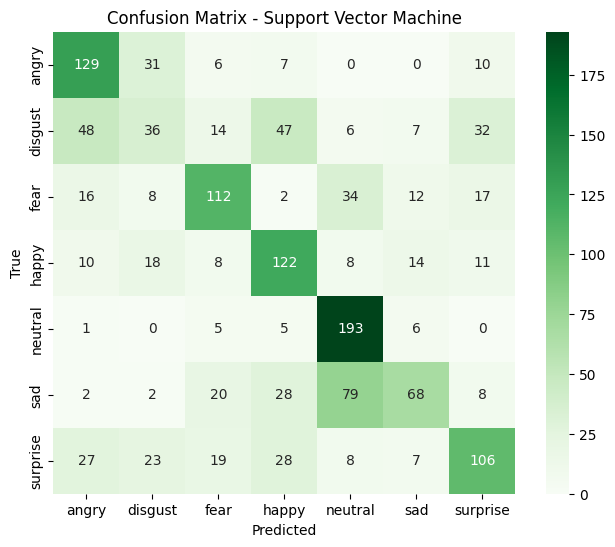

Classification Report:
              precision    recall  f1-score   support

       angry       0.55      0.70      0.62       183
     disgust       0.31      0.19      0.23       190
        fear       0.61      0.56      0.58       201
       happy       0.51      0.64      0.57       191
     neutral       0.59      0.92      0.72       210
         sad       0.60      0.33      0.42       207
    surprise       0.58      0.49      0.53       218

    accuracy                           0.55      1400
   macro avg       0.53      0.55      0.52      1400
weighted avg       0.54      0.55      0.53      1400



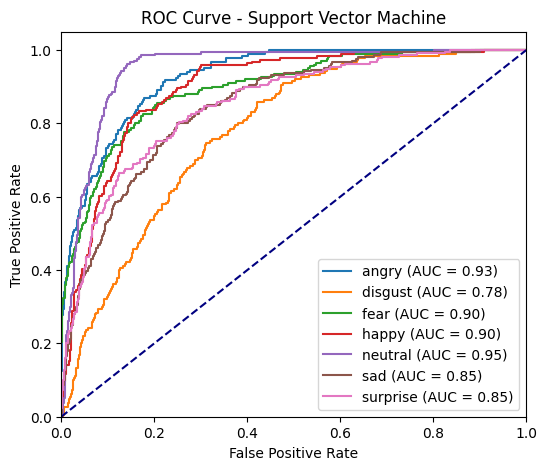

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

def model_comparison(X_train, y_train, X_test, y_test, emotions):
    models = {
        "Decision Tree": DecisionTreeClassifier(),
        "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=2),
        "Random Forest": RandomForestClassifier(n_estimators = 500),
        "Multi-Layer Perceptron": MLPClassifier(alpha=0.01, batch_size=270, epsilon=1e-08, hidden_layer_sizes=(400,), learning_rate='adaptive', max_iter=400),
        "Support Vector Machine": SVC(probability = True)
    }

    for name, model in models.items():
        print(f"Training {name}...")
        model.fit(X_train, y_train)

        print(f"Evaluating {name}...")
        y_pred = model.predict(X_test)

        print("Accuracy:", accuracy_score(y_test, y_pred))
        print("Precision:", precision_score(y_test, y_pred, average='macro'))
        print("Recall:", recall_score(y_test, y_pred, average='macro'))
        print("F1 Score:", f1_score(y_test, y_pred, average='macro'))

        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, cmap='Greens', fmt='d', square=True, xticklabels=np.unique(emotions), yticklabels=np.unique(emotions))
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'Confusion Matrix - {name}')
        plt.show()

        # Classification report
        print("Classification Report:")
        print(classification_report(y_test, y_pred, target_names=np.unique(emotions)))

        # ROC curve
        y_pred_proba = model.predict_proba(X_test)
        n_classes = len(np.unique(y_test))
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve((y_test == i).astype(int), y_pred_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        plt.figure(figsize=(6, 5))
        for i in range(n_classes):
            plt.plot(fpr[i], tpr[i], label=f'{emotions[i]} (AUC = {roc_auc[i]:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {name}')
        plt.legend(loc="lower right")
        plt.show()

        print("\n\n")

model_comparison(X_train, y_train, X_test, y_test, emotions)

##**Ensemble Learning**

###**60-40**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Evaluating AdaBoost_XGBoost_GBM...
Accuracy: 0.765
Precision: 0.769084245123583
Recall: 0.7656723537483182
F1 Score: 0.7624582286946177


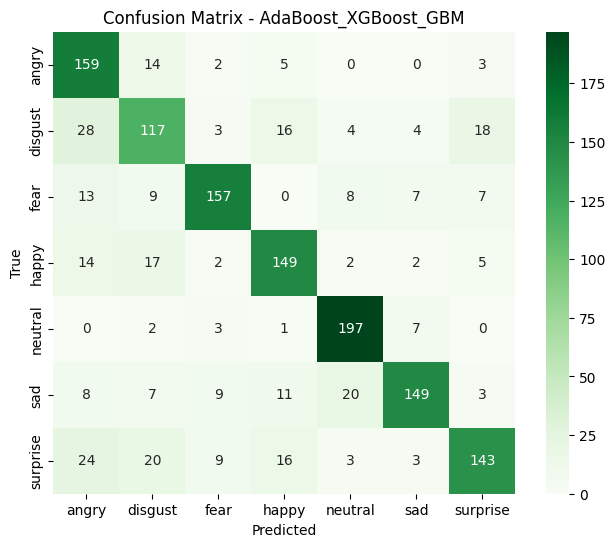

Classification Report:
              precision    recall  f1-score   support

       angry       0.65      0.87      0.74       183
     disgust       0.63      0.62      0.62       190
        fear       0.85      0.78      0.81       201
       happy       0.75      0.78      0.77       191
     neutral       0.84      0.94      0.89       210
         sad       0.87      0.72      0.79       207
    surprise       0.80      0.66      0.72       218

    accuracy                           0.77      1400
   macro avg       0.77      0.77      0.76      1400
weighted avg       0.77      0.77      0.76      1400




Evaluating AdaBoost_GBM_RF...
Accuracy: 0.7678571428571429
Precision: 0.7728072420068861
Recall: 0.7690311466449248
F1 Score: 0.7645454563871503


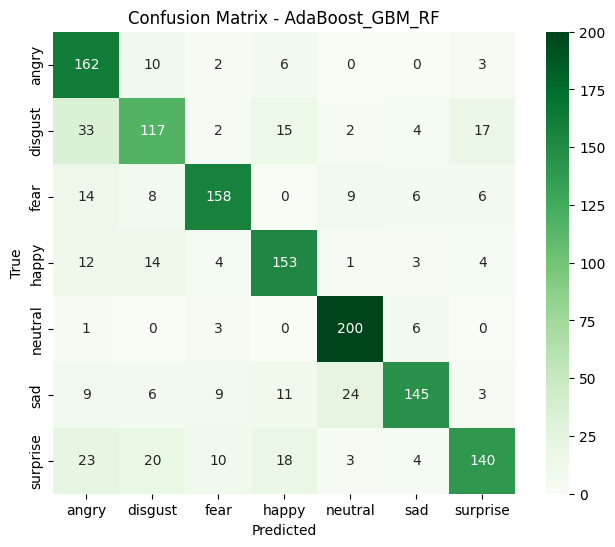

Classification Report:
              precision    recall  f1-score   support

       angry       0.64      0.89      0.74       183
     disgust       0.67      0.62      0.64       190
        fear       0.84      0.79      0.81       201
       happy       0.75      0.80      0.78       191
     neutral       0.84      0.95      0.89       210
         sad       0.86      0.70      0.77       207
    surprise       0.81      0.64      0.72       218

    accuracy                           0.77      1400
   macro avg       0.77      0.77      0.76      1400
weighted avg       0.78      0.77      0.77      1400




Evaluating AdaBoost_XGB_RF...
Accuracy: 0.835
Precision: 0.8362063106267001
Recall: 0.8352595835311869
F1 Score: 0.8329171323971014


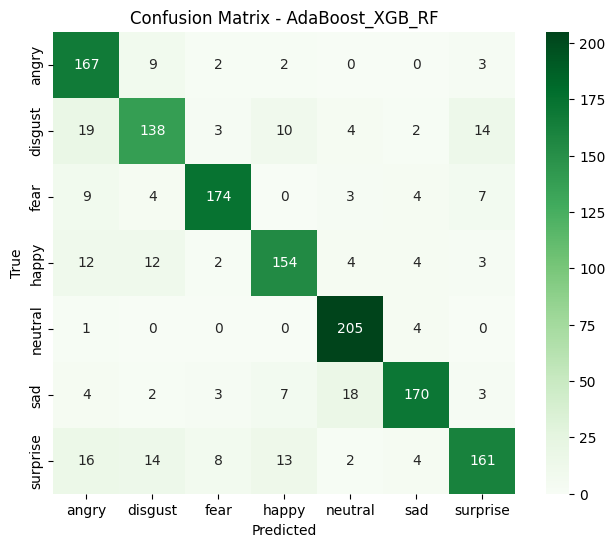

Classification Report:
              precision    recall  f1-score   support

       angry       0.73      0.91      0.81       183
     disgust       0.77      0.73      0.75       190
        fear       0.91      0.87      0.89       201
       happy       0.83      0.81      0.82       191
     neutral       0.87      0.98      0.92       210
         sad       0.90      0.82      0.86       207
    surprise       0.84      0.74      0.79       218

    accuracy                           0.83      1400
   macro avg       0.84      0.84      0.83      1400
weighted avg       0.84      0.83      0.83      1400




Evaluating RF_DT_MLP...
Accuracy: 0.8657142857142858
Precision: 0.8684011359726143
Recall: 0.8670284920154794
F1 Score: 0.8649422821888434


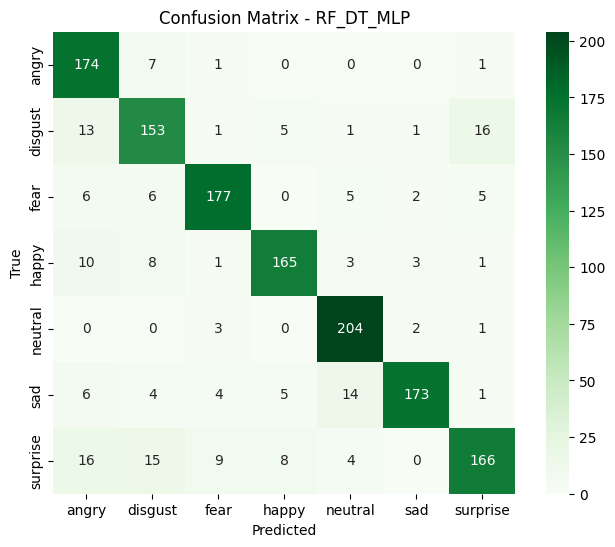

Classification Report:
              precision    recall  f1-score   support

       angry       0.77      0.95      0.85       183
     disgust       0.79      0.81      0.80       190
        fear       0.90      0.88      0.89       201
       happy       0.90      0.86      0.88       191
     neutral       0.88      0.97      0.93       210
         sad       0.96      0.84      0.89       207
    surprise       0.87      0.76      0.81       218

    accuracy                           0.87      1400
   macro avg       0.87      0.87      0.86      1400
weighted avg       0.87      0.87      0.87      1400




Evaluating RF_DT_KNN...
Accuracy: 0.8464285714285714
Precision: 0.8516691574766255
Recall: 0.8489253378476532
F1 Score: 0.8453537450298946


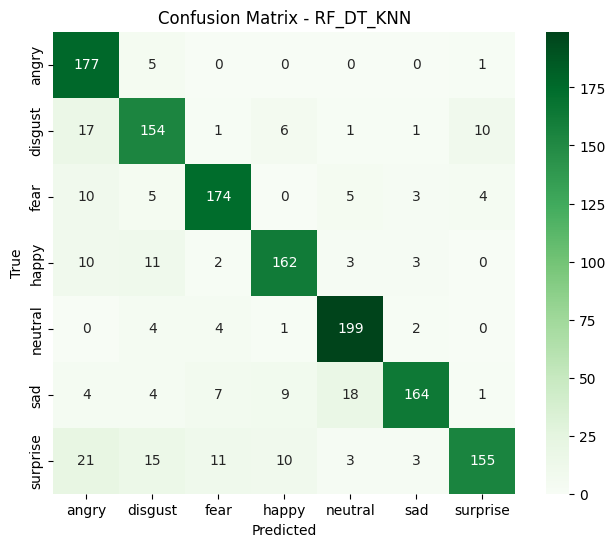

Classification Report:
              precision    recall  f1-score   support

       angry       0.74      0.97      0.84       183
     disgust       0.78      0.81      0.79       190
        fear       0.87      0.87      0.87       201
       happy       0.86      0.85      0.85       191
     neutral       0.87      0.95      0.91       210
         sad       0.93      0.79      0.86       207
    surprise       0.91      0.71      0.80       218

    accuracy                           0.85      1400
   macro avg       0.85      0.85      0.85      1400
weighted avg       0.85      0.85      0.85      1400




Evaluating RF_SVM_MLP...
Accuracy: 0.8407142857142857
Precision: 0.8425492835758054
Recall: 0.8415630015690535
F1 Score: 0.8379617005537233


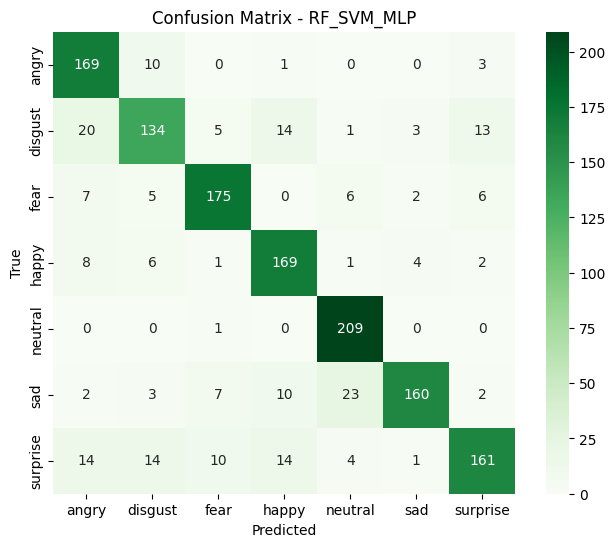

Classification Report:
              precision    recall  f1-score   support

       angry       0.77      0.92      0.84       183
     disgust       0.78      0.71      0.74       190
        fear       0.88      0.87      0.88       201
       happy       0.81      0.88      0.85       191
     neutral       0.86      1.00      0.92       210
         sad       0.94      0.77      0.85       207
    surprise       0.86      0.74      0.80       218

    accuracy                           0.84      1400
   macro avg       0.84      0.84      0.84      1400
weighted avg       0.84      0.84      0.84      1400




Evaluating DT_MLP_KNN...
Accuracy: 0.8614285714285714
Precision: 0.867064140990797
Recall: 0.8636067026061537
F1 Score: 0.8606707457095029


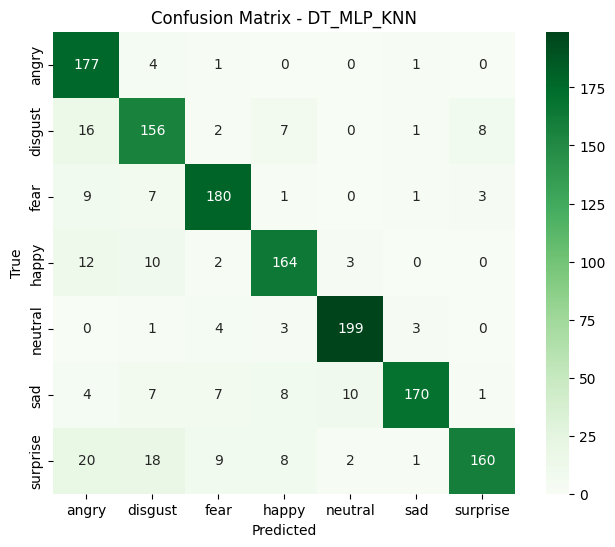

Classification Report:
              precision    recall  f1-score   support

       angry       0.74      0.97      0.84       183
     disgust       0.77      0.82      0.79       190
        fear       0.88      0.90      0.89       201
       happy       0.86      0.86      0.86       191
     neutral       0.93      0.95      0.94       210
         sad       0.96      0.82      0.89       207
    surprise       0.93      0.73      0.82       218

    accuracy                           0.86      1400
   macro avg       0.87      0.86      0.86      1400
weighted avg       0.87      0.86      0.86      1400






In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.ensemble import VotingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

ensemble_models = [
    ('AdaBoost_XGBoost_GBM', VotingClassifier(estimators=[('AdaBoost', AdaBoostClassifier()), ('XGBoost', xgb.XGBClassifier()), ('GBM', GradientBoostingClassifier())])),
    ('AdaBoost_GBM_RF', VotingClassifier(estimators=[('AdaBoost', AdaBoostClassifier()), ('GBM', GradientBoostingClassifier()), ('RF', RandomForestClassifier(n_estimators=500))])),
    ('AdaBoost_XGB_RF', VotingClassifier(estimators=[('AdaBoost', AdaBoostClassifier()), ('XGBoost', xgb.XGBClassifier()), ('RF', RandomForestClassifier(n_estimators=500))])),
    ('RF_DT_MLP', VotingClassifier(estimators=[('RF', RandomForestClassifier(n_estimators=500)), ('DT', DecisionTreeClassifier()), ('MLP', MLPClassifier(alpha=0.01, batch_size=270, epsilon=1e-08, hidden_layer_sizes=(400,), learning_rate='adaptive', max_iter=400))])),
    ('RF_DT_KNN', VotingClassifier(estimators=[('RF', RandomForestClassifier(n_estimators=500)), ('DT', DecisionTreeClassifier()), ('KNN', KNeighborsClassifier(n_neighbors=2))])),
    ('RF_SVM_MLP', VotingClassifier(estimators=[('RF', RandomForestClassifier(n_estimators=500)), ('SVM', SVC()), ('MLP', MLPClassifier(alpha=0.01, batch_size=270, epsilon=1e-08, hidden_layer_sizes=(400,), learning_rate='adaptive', max_iter=400))])),
    ('DT_MLP_KNN', VotingClassifier(estimators=[('DT', DecisionTreeClassifier()), ('MLP', MLPClassifier(alpha=0.01, batch_size=270, epsilon=1e-08, hidden_layer_sizes=(400,), learning_rate='adaptive', max_iter=400)), ('KNN', KNeighborsClassifier(n_neighbors=2))]))
]


for name, model in ensemble_models:
    print(f"Evaluating {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred, average='macro'))
    print("Recall:", recall_score(y_test, y_pred, average='macro'))
    print("F1 Score:", f1_score(y_test, y_pred, average='macro'))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Greens', fmt='d', square=True, xticklabels=np.unique(emotions), yticklabels=np.unique(emotions))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=np.unique(emotions)))

    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)
        n_classes = len(np.unique(y_test))
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve((y_test == i).astype(int), y_pred_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        plt.figure(figsize=(6, 5))
        for i in range(n_classes):
            plt.plot(fpr[i], tpr[i], label=f'{emotions[i]} (AUC = {roc_auc[i]:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {name}')
        plt.legend(loc="lower right")
        plt.show()

    print("\n\n")


###**70-30**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Evaluating AdaBoost_XGBoost_GBM...
Accuracy: 0.7361904761904762
Precision: 0.7438018558724868
Recall: 0.7396166637073669
F1 Score: 0.7346806666571233


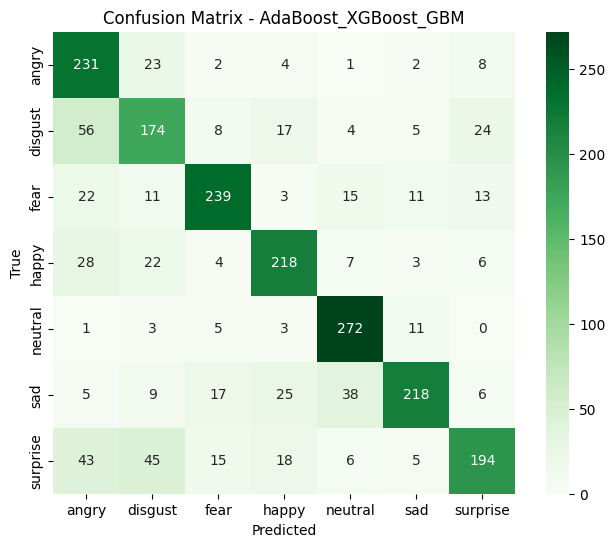

Classification Report:
              precision    recall  f1-score   support

       angry       0.60      0.85      0.70       271
     disgust       0.61      0.60      0.61       288
        fear       0.82      0.76      0.79       314
       happy       0.76      0.76      0.76       288
     neutral       0.79      0.92      0.85       295
         sad       0.85      0.69      0.76       318
    surprise       0.77      0.60      0.67       326

    accuracy                           0.74      2100
   macro avg       0.74      0.74      0.73      2100
weighted avg       0.75      0.74      0.74      2100




Evaluating AdaBoost_GBM_RF...
Accuracy: 0.7347619047619047
Precision: 0.7420126599280463
Recall: 0.7381415844674023
F1 Score: 0.7325657790179039


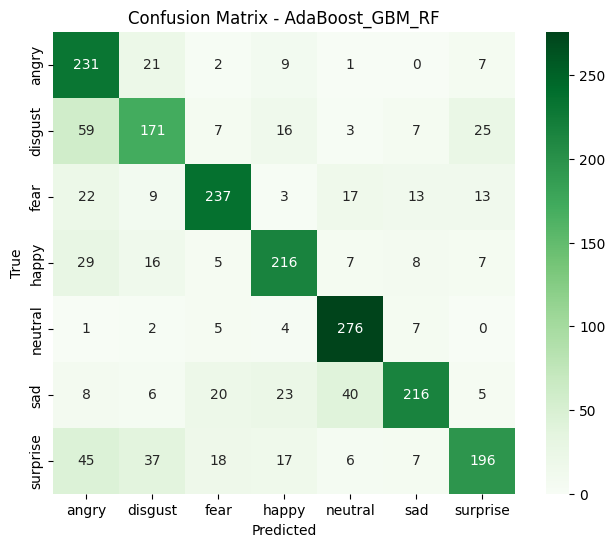

Classification Report:
              precision    recall  f1-score   support

       angry       0.58      0.85      0.69       271
     disgust       0.65      0.59      0.62       288
        fear       0.81      0.75      0.78       314
       happy       0.75      0.75      0.75       288
     neutral       0.79      0.94      0.86       295
         sad       0.84      0.68      0.75       318
    surprise       0.77      0.60      0.68       326

    accuracy                           0.73      2100
   macro avg       0.74      0.74      0.73      2100
weighted avg       0.75      0.73      0.73      2100




Evaluating AdaBoost_XGB_RF...
Accuracy: 0.8247619047619048
Precision: 0.8272051405326745
Recall: 0.8267740863963065
F1 Score: 0.823838279385843


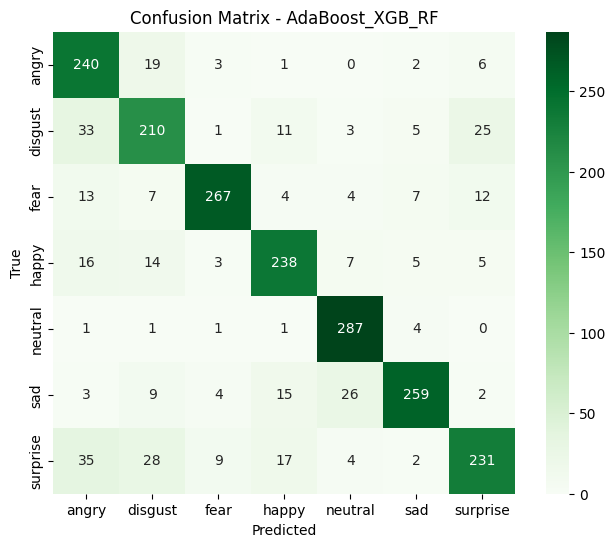

Classification Report:
              precision    recall  f1-score   support

       angry       0.70      0.89      0.78       271
     disgust       0.73      0.73      0.73       288
        fear       0.93      0.85      0.89       314
       happy       0.83      0.83      0.83       288
     neutral       0.87      0.97      0.92       295
         sad       0.91      0.81      0.86       318
    surprise       0.82      0.71      0.76       326

    accuracy                           0.82      2100
   macro avg       0.83      0.83      0.82      2100
weighted avg       0.83      0.82      0.82      2100




Evaluating RF_DT_MLP...
Accuracy: 0.8504761904761905
Precision: 0.8516101333663221
Recall: 0.8518107819838773
F1 Score: 0.8496022684361144


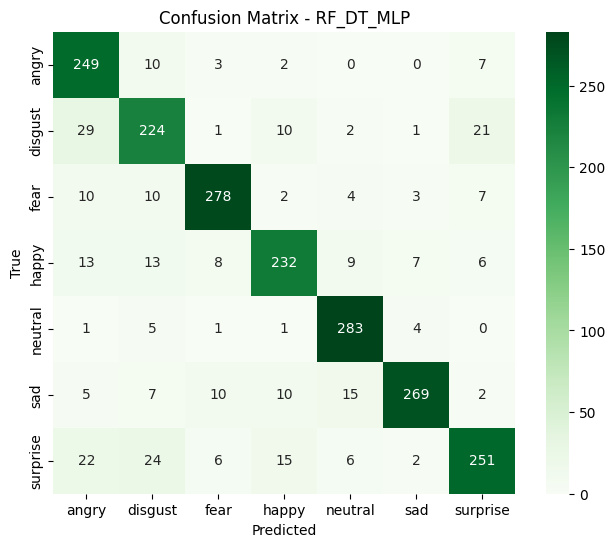

Classification Report:
              precision    recall  f1-score   support

       angry       0.76      0.92      0.83       271
     disgust       0.76      0.78      0.77       288
        fear       0.91      0.89      0.90       314
       happy       0.85      0.81      0.83       288
     neutral       0.89      0.96      0.92       295
         sad       0.94      0.85      0.89       318
    surprise       0.85      0.77      0.81       326

    accuracy                           0.85      2100
   macro avg       0.85      0.85      0.85      2100
weighted avg       0.85      0.85      0.85      2100




Evaluating RF_DT_KNN...
Accuracy: 0.8342857142857143
Precision: 0.8413766336197731
Recall: 0.8376968708240075
F1 Score: 0.8335069015558491


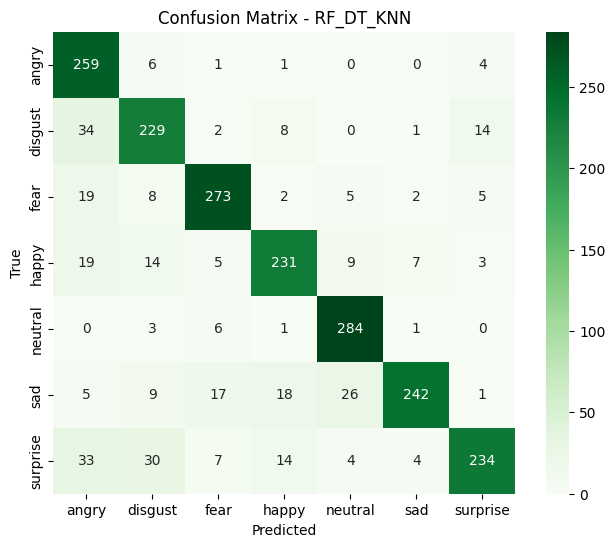

Classification Report:
              precision    recall  f1-score   support

       angry       0.70      0.96      0.81       271
     disgust       0.77      0.80      0.78       288
        fear       0.88      0.87      0.87       314
       happy       0.84      0.80      0.82       288
     neutral       0.87      0.96      0.91       295
         sad       0.94      0.76      0.84       318
    surprise       0.90      0.72      0.80       326

    accuracy                           0.83      2100
   macro avg       0.84      0.84      0.83      2100
weighted avg       0.85      0.83      0.83      2100




Evaluating RF_SVM_MLP...
Accuracy: 0.8295238095238096
Precision: 0.831765021959718
Recall: 0.8312362905271123
F1 Score: 0.8278408890868773


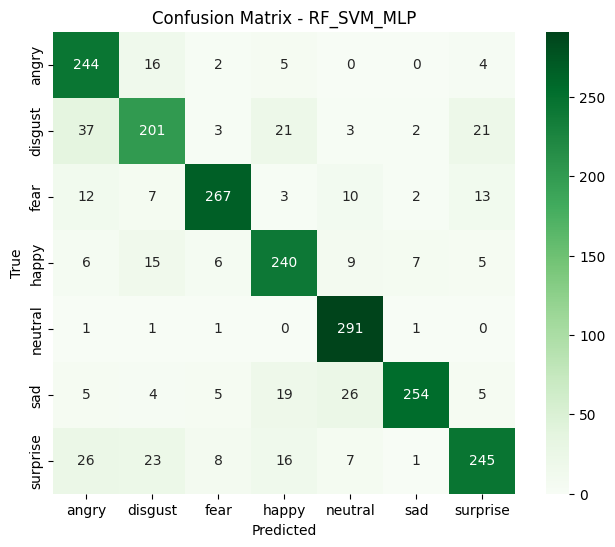

Classification Report:
              precision    recall  f1-score   support

       angry       0.74      0.90      0.81       271
     disgust       0.75      0.70      0.72       288
        fear       0.91      0.85      0.88       314
       happy       0.79      0.83      0.81       288
     neutral       0.84      0.99      0.91       295
         sad       0.95      0.80      0.87       318
    surprise       0.84      0.75      0.79       326

    accuracy                           0.83      2100
   macro avg       0.83      0.83      0.83      2100
weighted avg       0.84      0.83      0.83      2100




Evaluating DT_MLP_KNN...
Accuracy: 0.8423809523809523
Precision: 0.8533595865527587
Recall: 0.8454462988453991
F1 Score: 0.8427880177648691


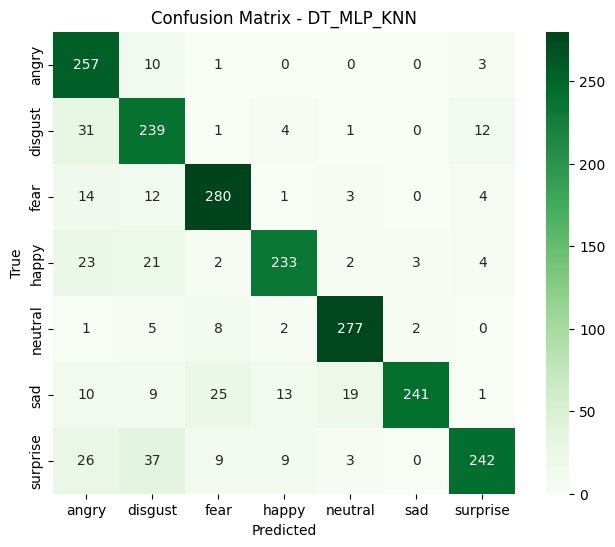

Classification Report:
              precision    recall  f1-score   support

       angry       0.71      0.95      0.81       271
     disgust       0.72      0.83      0.77       288
        fear       0.86      0.89      0.87       314
       happy       0.89      0.81      0.85       288
     neutral       0.91      0.94      0.92       295
         sad       0.98      0.76      0.85       318
    surprise       0.91      0.74      0.82       326

    accuracy                           0.84      2100
   macro avg       0.85      0.85      0.84      2100
weighted avg       0.86      0.84      0.84      2100






In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.ensemble import VotingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

ensemble_models = [
    ('AdaBoost_XGBoost_GBM', VotingClassifier(estimators=[('AdaBoost', AdaBoostClassifier()), ('XGBoost', xgb.XGBClassifier()), ('GBM', GradientBoostingClassifier())])),
    ('AdaBoost_GBM_RF', VotingClassifier(estimators=[('AdaBoost', AdaBoostClassifier()), ('GBM', GradientBoostingClassifier()), ('RF', RandomForestClassifier(n_estimators=500))])),
    ('AdaBoost_XGB_RF', VotingClassifier(estimators=[('AdaBoost', AdaBoostClassifier()), ('XGBoost', xgb.XGBClassifier()), ('RF', RandomForestClassifier(n_estimators=500))])),
    ('RF_DT_MLP', VotingClassifier(estimators=[('RF', RandomForestClassifier(n_estimators=500)), ('DT', DecisionTreeClassifier()), ('MLP', MLPClassifier(alpha=0.01, batch_size=270, epsilon=1e-08, hidden_layer_sizes=(400,), learning_rate='adaptive', max_iter=400))])),
    ('RF_DT_KNN', VotingClassifier(estimators=[('RF', RandomForestClassifier(n_estimators=500)), ('DT', DecisionTreeClassifier()), ('KNN', KNeighborsClassifier(n_neighbors=2))])),
    ('RF_SVM_MLP', VotingClassifier(estimators=[('RF', RandomForestClassifier(n_estimators=500)), ('SVM', SVC()), ('MLP', MLPClassifier(alpha=0.01, batch_size=270, epsilon=1e-08, hidden_layer_sizes=(400,), learning_rate='adaptive', max_iter=400))])),
    ('DT_MLP_KNN', VotingClassifier(estimators=[('DT', DecisionTreeClassifier()), ('MLP', MLPClassifier(alpha=0.01, batch_size=270, epsilon=1e-08, hidden_layer_sizes=(400,), learning_rate='adaptive', max_iter=400)), ('KNN', KNeighborsClassifier(n_neighbors=2))]))
]


for name, model in ensemble_models:
    print(f"Evaluating {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred, average='macro'))
    print("Recall:", recall_score(y_test, y_pred, average='macro'))
    print("F1 Score:", f1_score(y_test, y_pred, average='macro'))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Greens', fmt='d', square=True, xticklabels=np.unique(emotions), yticklabels=np.unique(emotions))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=np.unique(emotions)))

    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)
        n_classes = len(np.unique(y_test))
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve((y_test == i).astype(int), y_pred_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        plt.figure(figsize=(6, 5))
        for i in range(n_classes):
            plt.plot(fpr[i], tpr[i], label=f'{emotions[i]} (AUC = {roc_auc[i]:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {name}')
        plt.legend(loc="lower right")
        plt.show()

    print("\n\n")


###**80-20**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Evaluating AdaBoost_XGBoost_GBM...
Accuracy: 0.76
Precision: 0.7663199245861197
Recall: 0.7574807157872964
F1 Score: 0.7574288678473456


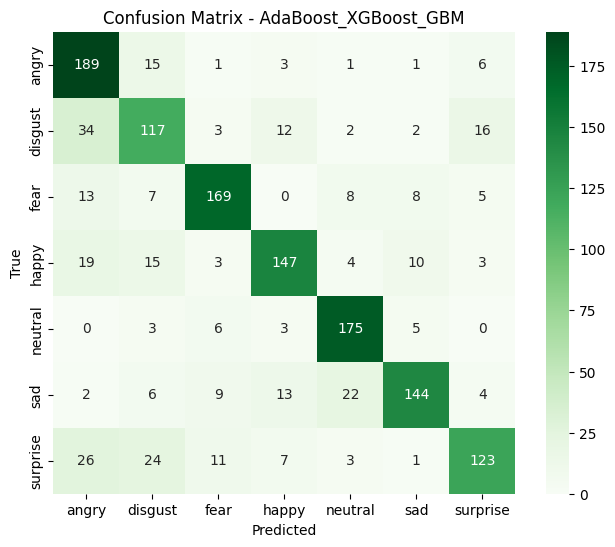

Classification Report:
              precision    recall  f1-score   support

       angry       0.67      0.88      0.76       216
     disgust       0.63      0.63      0.63       186
        fear       0.84      0.80      0.82       210
       happy       0.79      0.73      0.76       201
     neutral       0.81      0.91      0.86       192
         sad       0.84      0.72      0.78       200
    surprise       0.78      0.63      0.70       195

    accuracy                           0.76      1400
   macro avg       0.77      0.76      0.76      1400
weighted avg       0.77      0.76      0.76      1400




Evaluating AdaBoost_GBM_RF...
Accuracy: 0.7635714285714286
Precision: 0.7710753039526911
Recall: 0.761266024048884
F1 Score: 0.761705572356303


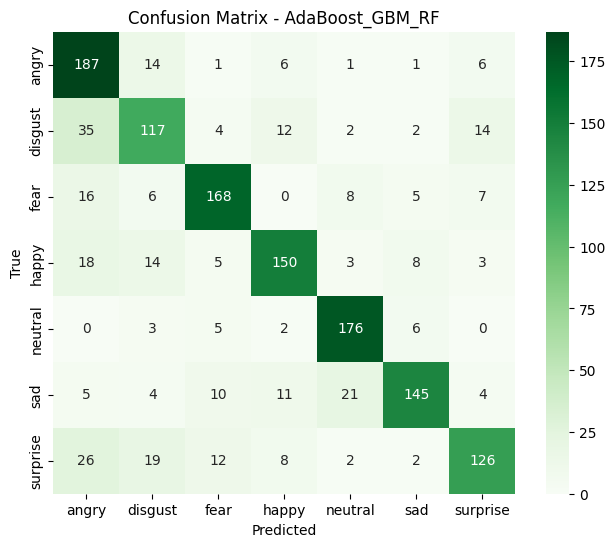

Classification Report:
              precision    recall  f1-score   support

       angry       0.65      0.87      0.74       216
     disgust       0.66      0.63      0.64       186
        fear       0.82      0.80      0.81       210
       happy       0.79      0.75      0.77       201
     neutral       0.83      0.92      0.87       192
         sad       0.86      0.72      0.79       200
    surprise       0.79      0.65      0.71       195

    accuracy                           0.76      1400
   macro avg       0.77      0.76      0.76      1400
weighted avg       0.77      0.76      0.76      1400




Evaluating AdaBoost_XGB_RF...
Accuracy: 0.8578571428571429
Precision: 0.8619070883888567
Recall: 0.8561752716396691
F1 Score: 0.8566328545929462


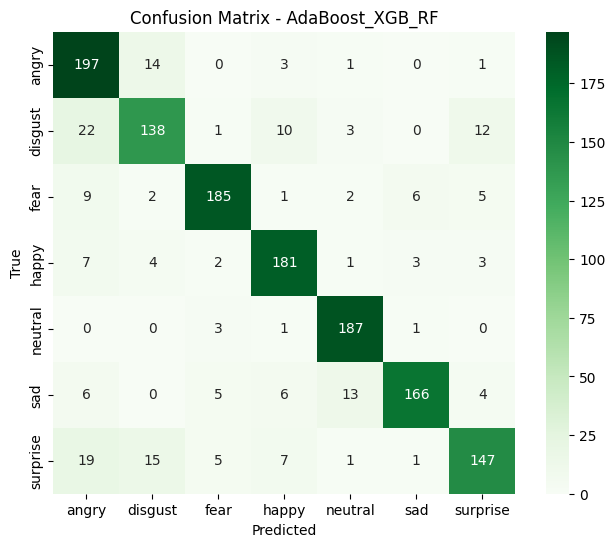

Classification Report:
              precision    recall  f1-score   support

       angry       0.76      0.91      0.83       216
     disgust       0.80      0.74      0.77       186
        fear       0.92      0.88      0.90       210
       happy       0.87      0.90      0.88       201
     neutral       0.90      0.97      0.94       192
         sad       0.94      0.83      0.88       200
    surprise       0.85      0.75      0.80       195

    accuracy                           0.86      1400
   macro avg       0.86      0.86      0.86      1400
weighted avg       0.86      0.86      0.86      1400




Evaluating RF_DT_MLP...
Accuracy: 0.8478571428571429
Precision: 0.8500865715497746
Recall: 0.8457154868714725
F1 Score: 0.8458050115405504


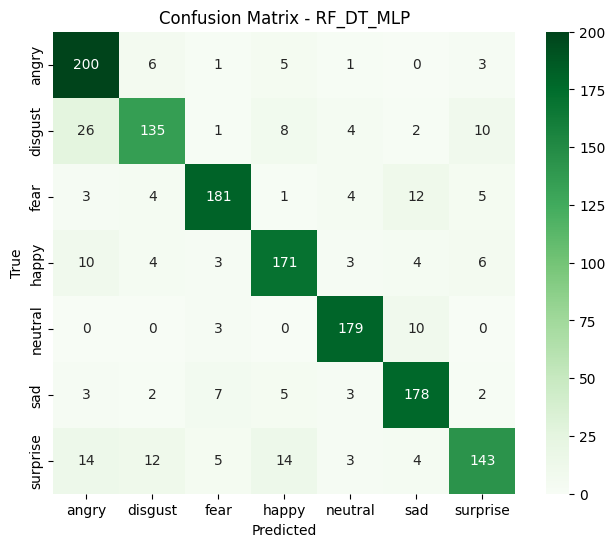

Classification Report:
              precision    recall  f1-score   support

       angry       0.78      0.93      0.85       216
     disgust       0.83      0.73      0.77       186
        fear       0.90      0.86      0.88       210
       happy       0.84      0.85      0.84       201
     neutral       0.91      0.93      0.92       192
         sad       0.85      0.89      0.87       200
    surprise       0.85      0.73      0.79       195

    accuracy                           0.85      1400
   macro avg       0.85      0.85      0.85      1400
weighted avg       0.85      0.85      0.85      1400




Evaluating RF_DT_KNN...
Accuracy: 0.8614285714285714
Precision: 0.8678943894759398
Recall: 0.8598935235118947
F1 Score: 0.8608402570748606


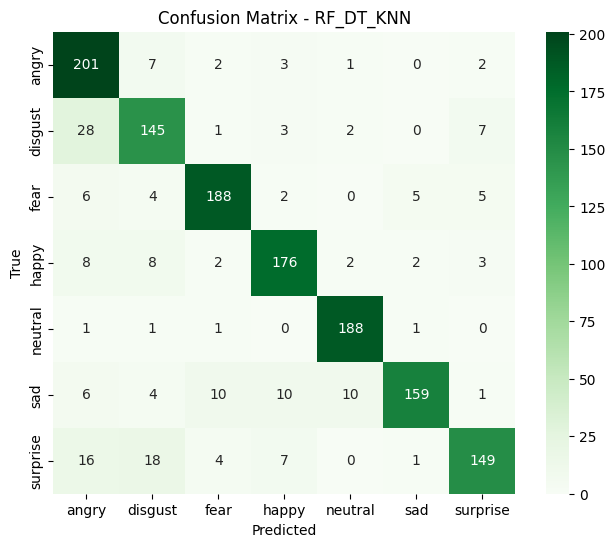

Classification Report:
              precision    recall  f1-score   support

       angry       0.76      0.93      0.83       216
     disgust       0.78      0.78      0.78       186
        fear       0.90      0.90      0.90       210
       happy       0.88      0.88      0.88       201
     neutral       0.93      0.98      0.95       192
         sad       0.95      0.80      0.86       200
    surprise       0.89      0.76      0.82       195

    accuracy                           0.86      1400
   macro avg       0.87      0.86      0.86      1400
weighted avg       0.87      0.86      0.86      1400




Evaluating RF_SVM_MLP...
Accuracy: 0.8507142857142858
Precision: 0.8508194325228926
Recall: 0.8486331857183532
F1 Score: 0.8481393015060634


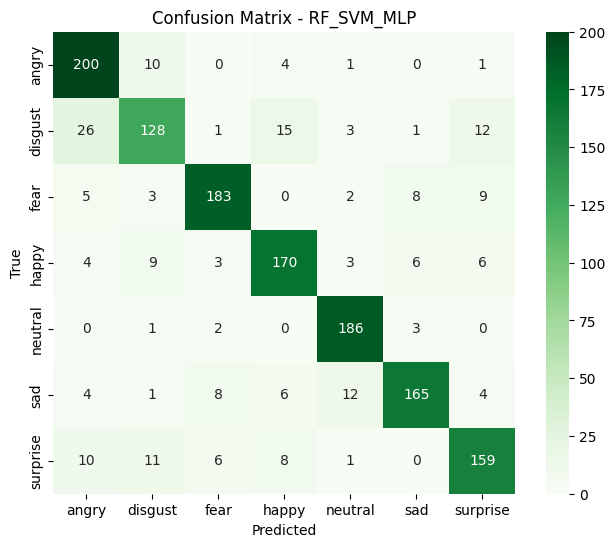

Classification Report:
              precision    recall  f1-score   support

       angry       0.80      0.93      0.86       216
     disgust       0.79      0.69      0.73       186
        fear       0.90      0.87      0.89       210
       happy       0.84      0.85      0.84       201
     neutral       0.89      0.97      0.93       192
         sad       0.90      0.82      0.86       200
    surprise       0.83      0.82      0.82       195

    accuracy                           0.85      1400
   macro avg       0.85      0.85      0.85      1400
weighted avg       0.85      0.85      0.85      1400




Evaluating DT_MLP_KNN...
Accuracy: 0.8628571428571429
Precision: 0.8710278768268837
Recall: 0.8608701136436451
F1 Score: 0.8622378587588273


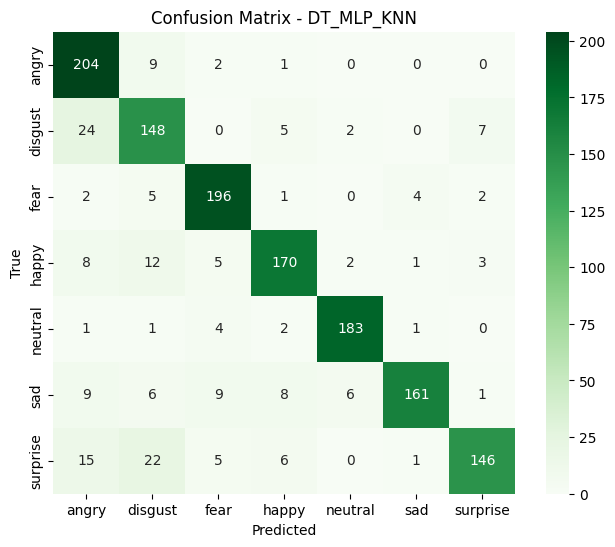

Classification Report:
              precision    recall  f1-score   support

       angry       0.78      0.94      0.85       216
     disgust       0.73      0.80      0.76       186
        fear       0.89      0.93      0.91       210
       happy       0.88      0.85      0.86       201
     neutral       0.95      0.95      0.95       192
         sad       0.96      0.81      0.88       200
    surprise       0.92      0.75      0.82       195

    accuracy                           0.86      1400
   macro avg       0.87      0.86      0.86      1400
weighted avg       0.87      0.86      0.86      1400






In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.ensemble import VotingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

ensemble_models = [
    ('AdaBoost_XGBoost_GBM', VotingClassifier(estimators=[('AdaBoost', AdaBoostClassifier()), ('XGBoost', xgb.XGBClassifier()), ('GBM', GradientBoostingClassifier())])),
    ('AdaBoost_GBM_RF', VotingClassifier(estimators=[('AdaBoost', AdaBoostClassifier()), ('GBM', GradientBoostingClassifier()), ('RF', RandomForestClassifier(n_estimators=500))])),
    ('AdaBoost_XGB_RF', VotingClassifier(estimators=[('AdaBoost', AdaBoostClassifier()), ('XGBoost', xgb.XGBClassifier()), ('RF', RandomForestClassifier(n_estimators=500))])),
    ('RF_DT_MLP', VotingClassifier(estimators=[('RF', RandomForestClassifier(n_estimators=500)), ('DT', DecisionTreeClassifier()), ('MLP', MLPClassifier(alpha=0.01, batch_size=270, epsilon=1e-08, hidden_layer_sizes=(400,), learning_rate='adaptive', max_iter=400))])),
    ('RF_DT_KNN', VotingClassifier(estimators=[('RF', RandomForestClassifier(n_estimators=500)), ('DT', DecisionTreeClassifier()), ('KNN', KNeighborsClassifier(n_neighbors=2))])),
    ('RF_SVM_MLP', VotingClassifier(estimators=[('RF', RandomForestClassifier(n_estimators=500)), ('SVM', SVC()), ('MLP', MLPClassifier(alpha=0.01, batch_size=270, epsilon=1e-08, hidden_layer_sizes=(400,), learning_rate='adaptive', max_iter=400))])),
    ('DT_MLP_KNN', VotingClassifier(estimators=[('DT', DecisionTreeClassifier()), ('MLP', MLPClassifier(alpha=0.01, batch_size=270, epsilon=1e-08, hidden_layer_sizes=(400,), learning_rate='adaptive', max_iter=400)), ('KNN', KNeighborsClassifier(n_neighbors=2))]))
]


for name, model in ensemble_models:
    print(f"Evaluating {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred, average='macro'))
    print("Recall:", recall_score(y_test, y_pred, average='macro'))
    print("F1 Score:", f1_score(y_test, y_pred, average='macro'))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Greens', fmt='d', square=True, xticklabels=np.unique(emotions), yticklabels=np.unique(emotions))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=np.unique(emotions)))

    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)
        n_classes = len(np.unique(y_test))
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve((y_test == i).astype(int), y_pred_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        plt.figure(figsize=(6, 5))
        for i in range(n_classes):
            plt.plot(fpr[i], tpr[i], label=f'{emotions[i]} (AUC = {roc_auc[i]:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {name}')
        plt.legend(loc="lower right")
        plt.show()

    print("\n\n")


##**Stacking Classifier**

###**60-40**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

Training Stacking Classifier...
Evaluating Stacking Classifier...
Accuracy: 0.9
Precision: 0.8995156150476377
Recall: 0.9003041198939679
F1 Score: 0.8996877734007149


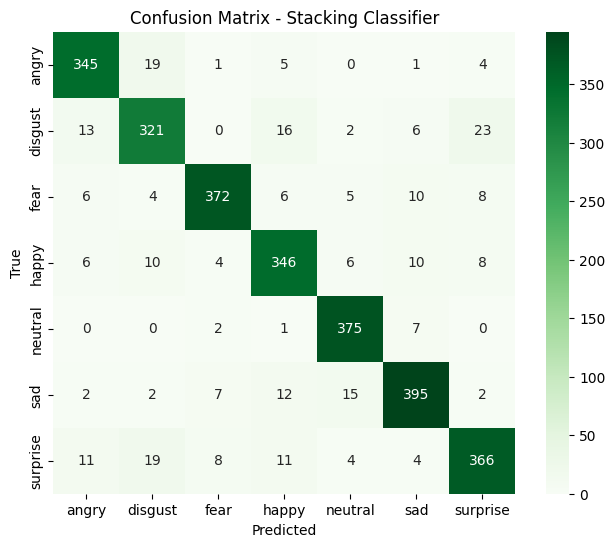

Classification Report:
              precision    recall  f1-score   support

       angry       0.90      0.92      0.91       375
     disgust       0.86      0.84      0.85       381
        fear       0.94      0.91      0.92       411
       happy       0.87      0.89      0.88       390
     neutral       0.92      0.97      0.95       385
         sad       0.91      0.91      0.91       435
    surprise       0.89      0.87      0.88       423

    accuracy                           0.90      2800
   macro avg       0.90      0.90      0.90      2800
weighted avg       0.90      0.90      0.90      2800



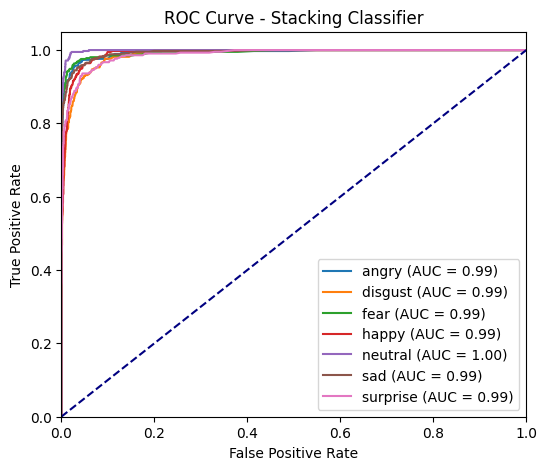

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

base_models = [
    ('AdaBoost', AdaBoostClassifier(n_estimators=100, learning_rate=1.0)),
    ('XGBoost', xgb.XGBClassifier(n_estimators=100, learning_rate=0.1)),
    ('GBM', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1)),
    ('RF', RandomForestClassifier(n_estimators=500)),
    ('DT', DecisionTreeClassifier()),
    ('MLP', MLPClassifier(alpha=0.01, batch_size=270, epsilon=1e-08, hidden_layer_sizes=(400,), learning_rate='adaptive', max_iter=400)),
    ('KNN', KNeighborsClassifier(n_neighbors=2)),
    ('SVM', SVC()),
    ('LR', LogisticRegression(max_iter=10000)),
    ('GNB', GaussianNB())
]

estimators = [(name, model) for name, model in base_models]

stacking_model = StackingClassifier(estimators=estimators, final_estimator=RandomForestClassifier(n_estimators=500))

print("Training Stacking Classifier...")
stacking_model.fit(X_train, y_train)

print("Evaluating Stacking Classifier...")
y_pred_stacking = stacking_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_stacking))
print("Precision:", precision_score(y_test, y_pred_stacking, average='macro'))
print("Recall:", recall_score(y_test, y_pred_stacking, average='macro'))
print("F1 Score:", f1_score(y_test, y_pred_stacking, average='macro'))

cm = confusion_matrix(y_test, y_pred_stacking)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Greens', fmt='d', square=True, xticklabels=np.unique(emotions), yticklabels=np.unique(emotions))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix - Stacking Classifier')
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred_stacking, target_names=np.unique(emotions)))

if hasattr(stacking_model, "predict_proba"):
    y_pred_proba_stacking = stacking_model.predict_proba(X_test)
    n_classes = len(np.unique(y_test))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve((y_test == i).astype(int), y_pred_proba_stacking[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(6, 5))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'{emotions[i]} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Stacking Classifier')
    plt.legend(loc="lower right")
    plt.show()


###**70-30**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Training Stacking Classifier...
Evaluating Stacking Classifier...
Accuracy: 0.9095238095238095
Precision: 0.9091373149761225
Recall: 0.9094755928816866
F1 Score: 0.9089356691588987


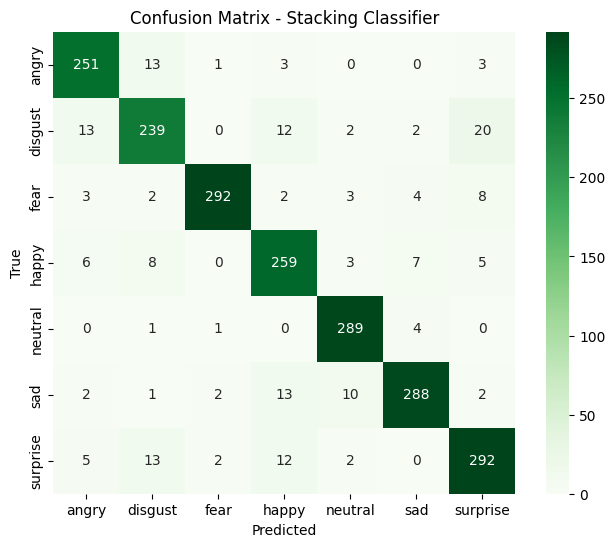

Classification Report:
              precision    recall  f1-score   support

       angry       0.90      0.93      0.91       271
     disgust       0.86      0.83      0.85       288
        fear       0.98      0.93      0.95       314
       happy       0.86      0.90      0.88       288
     neutral       0.94      0.98      0.96       295
         sad       0.94      0.91      0.92       318
    surprise       0.88      0.90      0.89       326

    accuracy                           0.91      2100
   macro avg       0.91      0.91      0.91      2100
weighted avg       0.91      0.91      0.91      2100



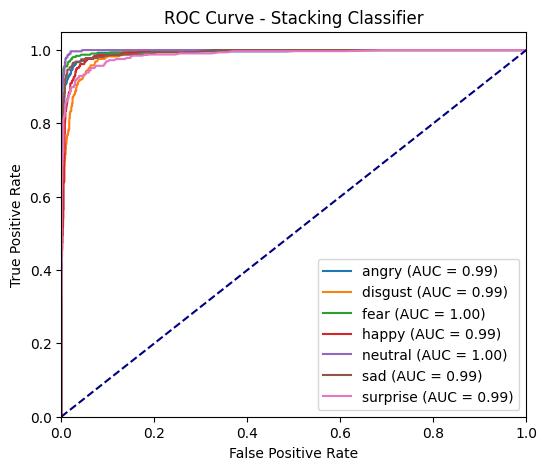

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

base_models = [
    ('AdaBoost', AdaBoostClassifier(n_estimators=100, learning_rate=1.0)),
    ('XGBoost', xgb.XGBClassifier(n_estimators=100, learning_rate=0.1)),
    ('GBM', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1)),
    ('RF', RandomForestClassifier(n_estimators=500)),
    ('DT', DecisionTreeClassifier()),
    ('MLP', MLPClassifier(alpha=0.01, batch_size=270, epsilon=1e-08, hidden_layer_sizes=(400,), learning_rate='adaptive', max_iter=400)),
    ('KNN', KNeighborsClassifier(n_neighbors=2)),
    ('SVM', SVC()),
    ('LR', LogisticRegression(max_iter=10000)),
    ('GNB', GaussianNB())
]

estimators = [(name, model) for name, model in base_models]

stacking_model = StackingClassifier(estimators=estimators, final_estimator=RandomForestClassifier(n_estimators=500))

print("Training Stacking Classifier...")
stacking_model.fit(X_train, y_train)

print("Evaluating Stacking Classifier...")
y_pred_stacking = stacking_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_stacking))
print("Precision:", precision_score(y_test, y_pred_stacking, average='macro'))
print("Recall:", recall_score(y_test, y_pred_stacking, average='macro'))
print("F1 Score:", f1_score(y_test, y_pred_stacking, average='macro'))

cm = confusion_matrix(y_test, y_pred_stacking)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Greens', fmt='d', square=True, xticklabels=np.unique(emotions), yticklabels=np.unique(emotions))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix - Stacking Classifier')
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred_stacking, target_names=np.unique(emotions)))

if hasattr(stacking_model, "predict_proba"):
    y_pred_proba_stacking = stacking_model.predict_proba(X_test)
    n_classes = len(np.unique(y_test))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve((y_test == i).astype(int), y_pred_proba_stacking[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(6, 5))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'{emotions[i]} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Stacking Classifier')
    plt.legend(loc="lower right")
    plt.show()


###**80-20**

Training Stacking Classifier...
Evaluating Stacking Classifier...
Accuracy: 0.9257142857142857
Precision: 0.9255749825898109
Recall: 0.9266049393523358
F1 Score: 0.9254426833176336


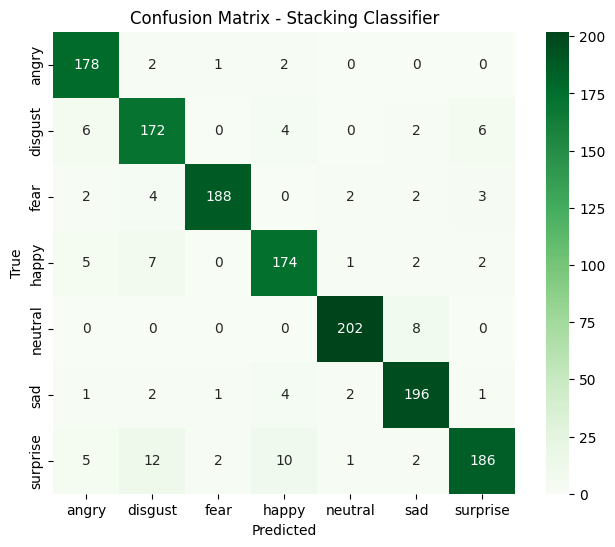

Classification Report:
              precision    recall  f1-score   support

       angry       0.90      0.97      0.94       183
     disgust       0.86      0.91      0.88       190
        fear       0.98      0.94      0.96       201
       happy       0.90      0.91      0.90       191
     neutral       0.97      0.96      0.97       210
         sad       0.92      0.95      0.94       207
    surprise       0.94      0.85      0.89       218

    accuracy                           0.93      1400
   macro avg       0.93      0.93      0.93      1400
weighted avg       0.93      0.93      0.93      1400



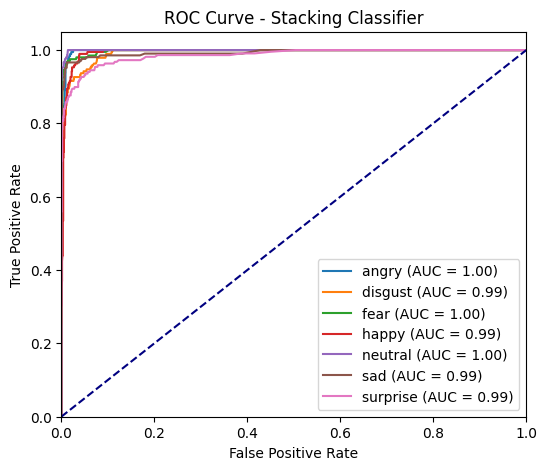

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

base_models = [
    ('AdaBoost', AdaBoostClassifier(n_estimators=100, learning_rate=1.0)),
    ('XGBoost', xgb.XGBClassifier(n_estimators=100, learning_rate=0.1)),
    ('GBM', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1)),
    ('RF', RandomForestClassifier(n_estimators=500)),
    ('DT', DecisionTreeClassifier()),
    ('MLP', MLPClassifier(alpha=0.01, batch_size=270, epsilon=1e-08, hidden_layer_sizes=(400,), learning_rate='adaptive', max_iter=400)),
    ('KNN', KNeighborsClassifier(n_neighbors=2)),
    ('SVM', SVC()),
    ('LR', LogisticRegression(max_iter=10000)),
    ('GNB', GaussianNB())
]

estimators = [(name, model) for name, model in base_models]

stacking_model = StackingClassifier(estimators=estimators, final_estimator=RandomForestClassifier(n_estimators=500))

print("Training Stacking Classifier...")
stacking_model.fit(X_train, y_train)

print("Evaluating Stacking Classifier...")
y_pred_stacking = stacking_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_stacking))
print("Precision:", precision_score(y_test, y_pred_stacking, average='macro'))
print("Recall:", recall_score(y_test, y_pred_stacking, average='macro'))
print("F1 Score:", f1_score(y_test, y_pred_stacking, average='macro'))

cm = confusion_matrix(y_test, y_pred_stacking)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Greens', fmt='d', square=True, xticklabels=np.unique(emotions), yticklabels=np.unique(emotions))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix - Stacking Classifier')
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred_stacking, target_names=np.unique(emotions)))

if hasattr(stacking_model, "predict_proba"):
    y_pred_proba_stacking = stacking_model.predict_proba(X_test)
    n_classes = len(np.unique(y_test))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve((y_test == i).astype(int), y_pred_proba_stacking[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(6, 5))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'{emotions[i]} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Stacking Classifier')
    plt.legend(loc="lower right")
    plt.show()
